### 1-Exploring data samples :

In [1]:
#!pip install librosa

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


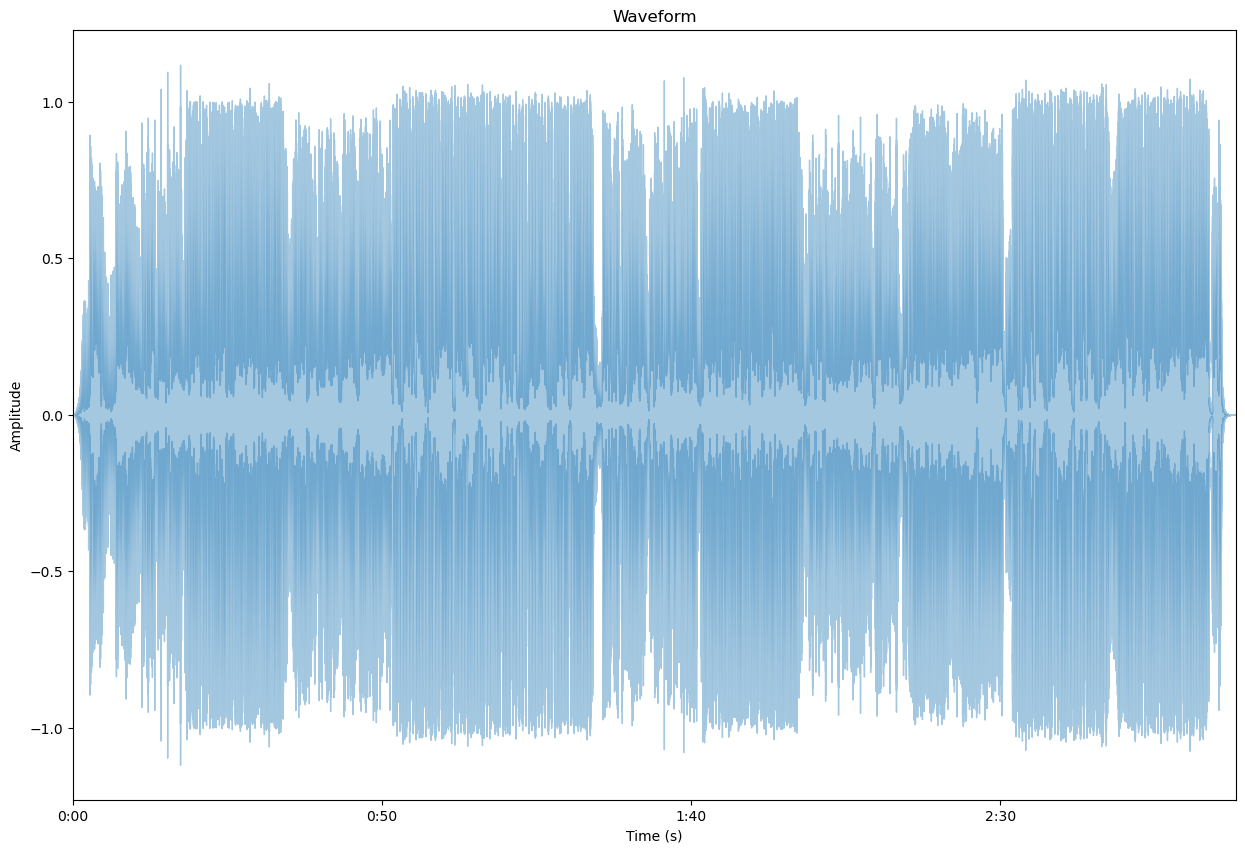

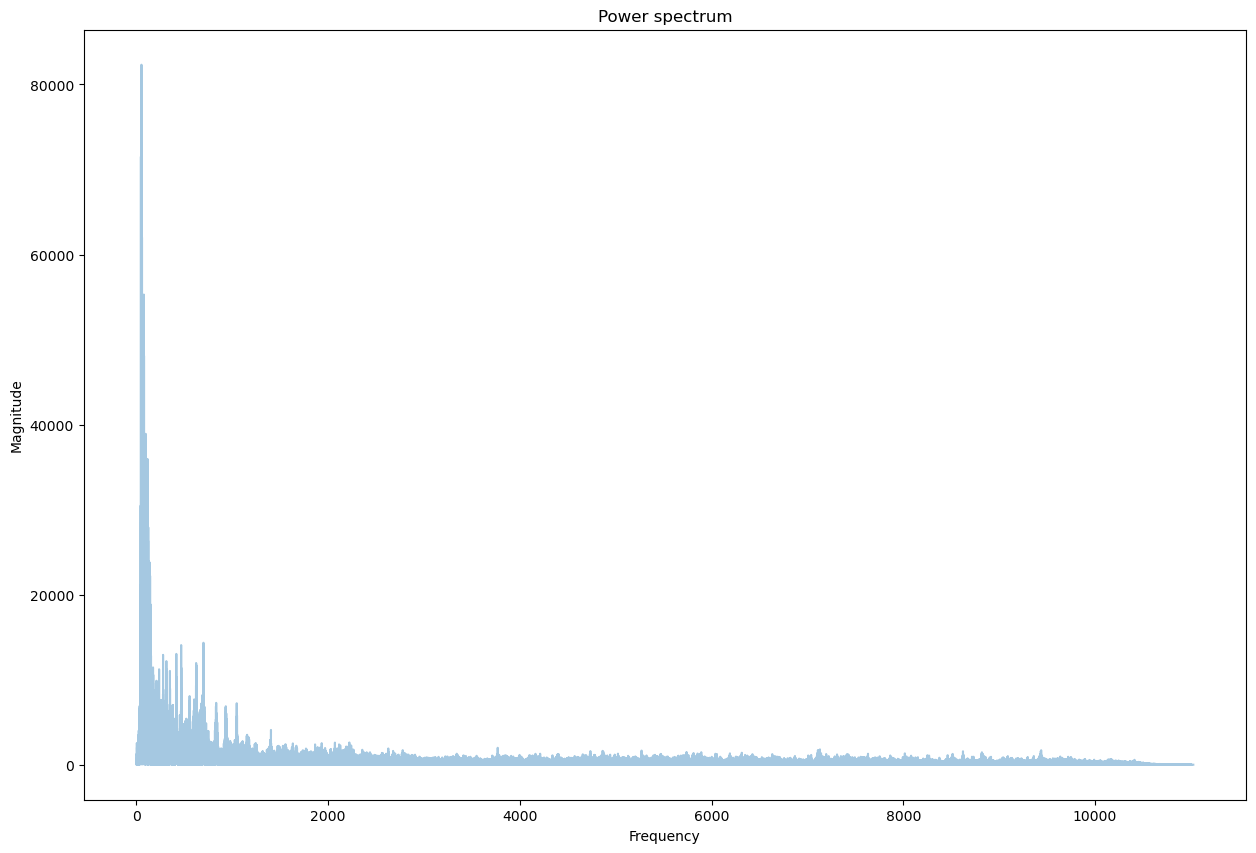

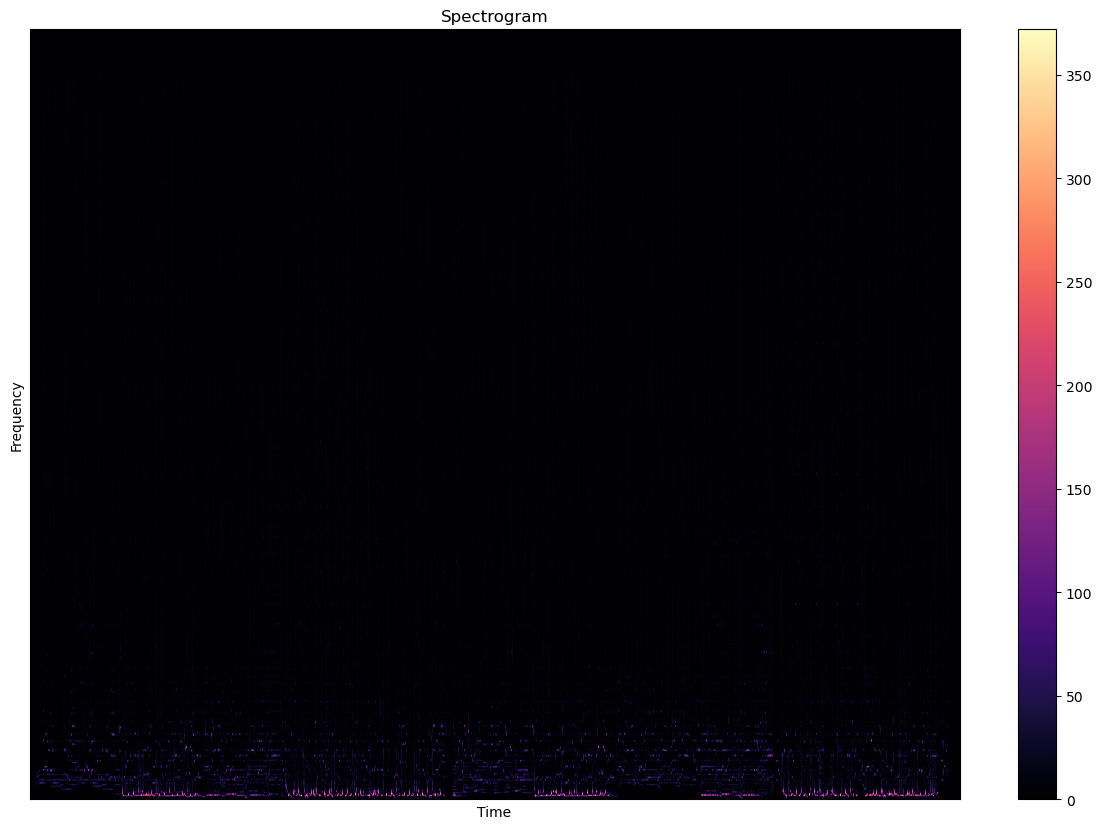

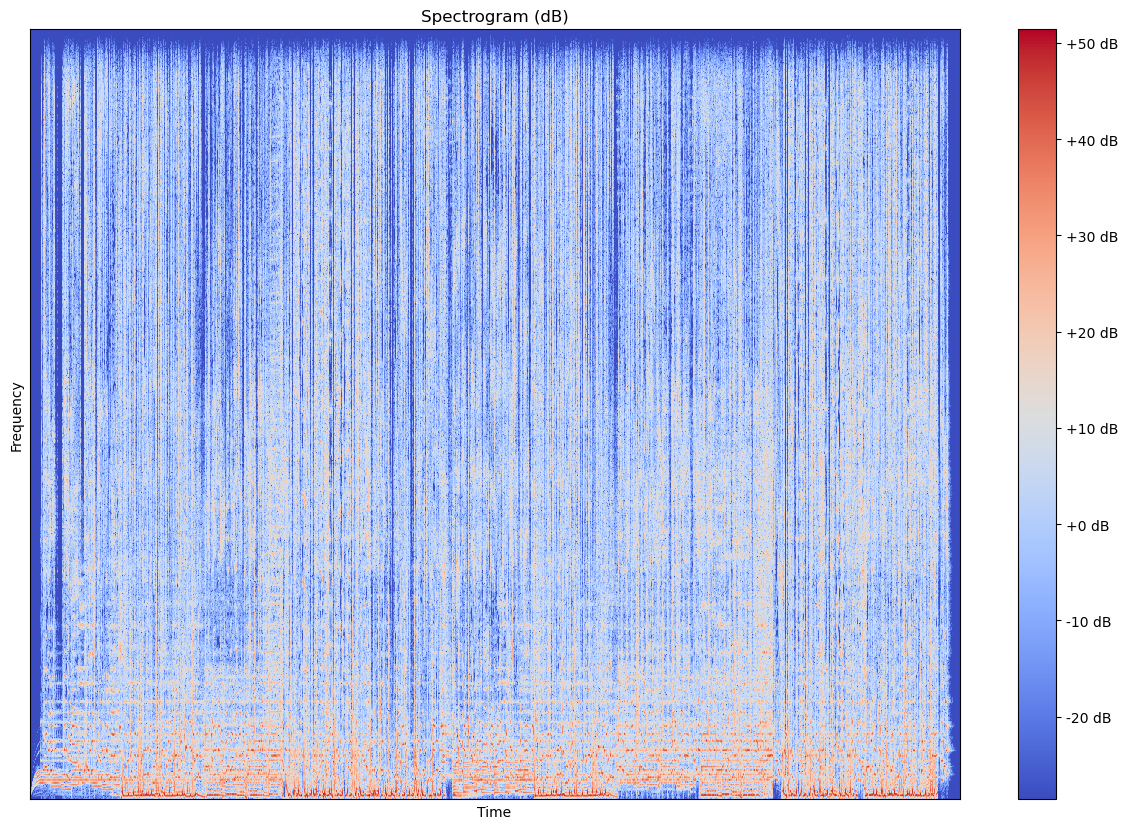

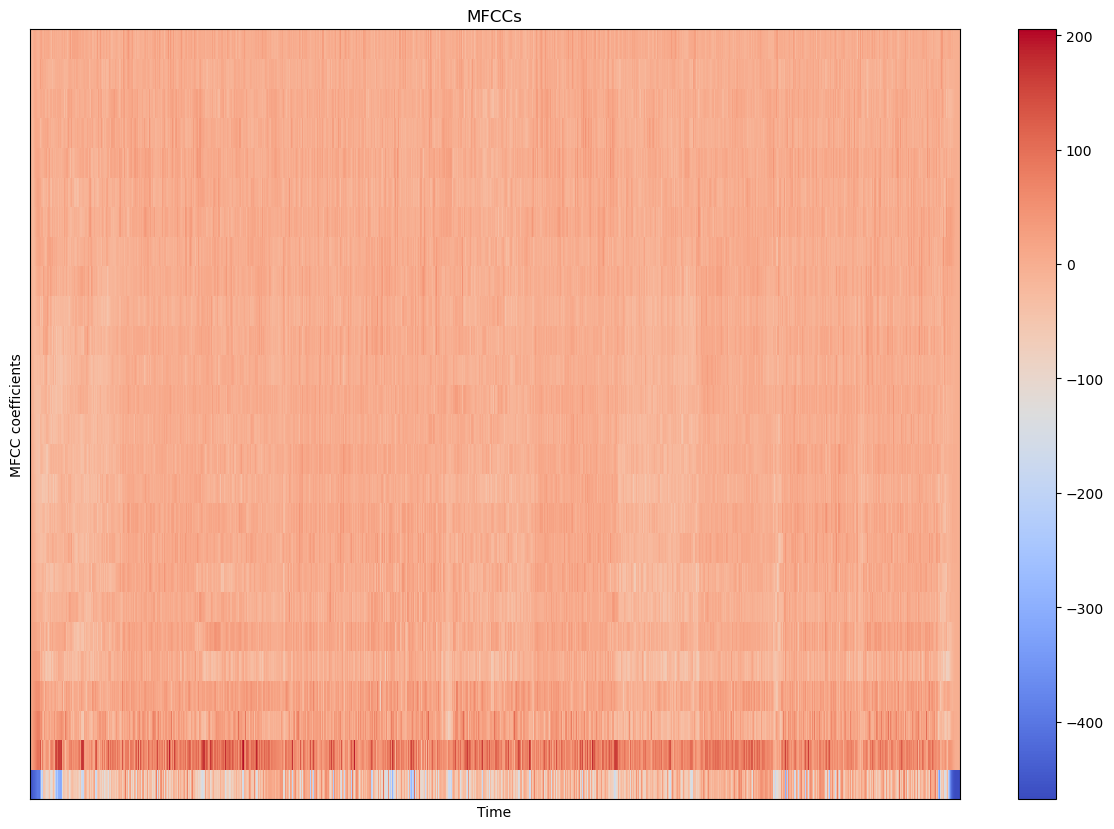

In [2]:
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt

FIG_SIZE = (15,10)

file = "./Training/Glitch Hop/Arcando - In My Head (feat. Britt Lari) [NCS Release].wav"

# load audio file with Librosa
signal, sample_rate = librosa.load(file, sr=22050)

# WAVEFORM
# display waveform
plt.figure(figsize=FIG_SIZE)
librosa.display.waveplot(signal, sample_rate, alpha=0.4)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")


# FFT -> power spectrum
# perform Fourier transform
fft = np.fft.fft(signal)

# calculate abs values on complex numbers to get magnitude
spectrum = np.abs(fft)

# create frequency variable
f = np.linspace(0, sample_rate, len(spectrum))

# take half of the spectrum and frequency
left_spectrum = spectrum[:int(len(spectrum)/2)]
left_f = f[:int(len(spectrum)/2)]

# plot spectrum
plt.figure(figsize=FIG_SIZE)
plt.plot(left_f, left_spectrum, alpha=0.4)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum")


# STFT -> spectrogram
hop_length = 512 # in num. of samples
n_fft = 2048 # window in num. of samples

# calculate duration hop length and window in seconds
hop_length_duration = float(hop_length)/sample_rate
n_fft_duration = float(n_fft)/sample_rate

print("STFT hop length duration is: {}s".format(hop_length_duration))
print("STFT window duration is: {}s".format(n_fft_duration))

# perform stft
stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)

# calculate abs values on complex numbers to get magnitude
spectrogram = np.abs(stft)

# display spectrogram
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.title("Spectrogram")
# show plots
plt.show()

# apply logarithm to cast amplitude to Decibels
log_spectrogram = librosa.amplitude_to_db(spectrogram)

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")
# show plots
plt.show()

# MFCCs
# extract 13 MFCCs
MFCCs = librosa.feature.mfcc(signal, sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=26)

# display MFCCs
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")

# show plots
plt.show()

### 2-storing metadata as Json :

In [3]:
#!pip install tensorflow-gpu==2.3.0

In [4]:
import tensorflow as tf
#gpus = tf.config.list_physical_devices('GPU')

C:\Users\Aymen\.conda\envs\p36workshop\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Aymen\.conda\envs\p36workshop\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Aymen\.conda\envs\p36workshop\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Aymen\.conda\envs\p36workshop\lib\site-packages\tensorf

In [5]:
# device configuration
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device

In [8]:
import json
import os
import math
import librosa
tf.debugging.set_log_device_placement(True)

DATASET_PATH = "./Training"
JSON_PATH = "data_13.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 45 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION


def save_mfcc(dataset_path, json_path, num_mfcc=26, n_fft=2048, hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.

        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

        # load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print(i,' /',len(list(os.walk(dataset_path))))
                        #print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    with open(json_path, "a+") as fp:
        json.dump(data, fp, indent=4)
        
        
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=6)



Processing: Training\Bass
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14
1  / 14

Processing: Training\Chill
2  / 14
2  / 14
2  / 14
2  / 14
2  / 14
2  / 14
2  / 14
2  / 14
2  / 14
2  / 14
2  / 14
2  / 14
2  / 14
2  / 14
2  / 14
2  / 14
2

4  / 14
4  / 14
4  / 14
4  / 14
4  / 14
4  / 14
4  / 14
4  / 14
4  / 14
4  / 14
4  / 14
4  / 14

Processing: Training\Dubstep
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5  / 14
5 

6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14
6  / 14


7  / 14
7  / 14
7  / 14
7  / 14
7  / 14
7  / 14
7  / 14
7  / 14
7  / 14
7  / 14
7  / 14
7  / 14
7  / 14
7  / 14
7  / 14
7  / 14
7  / 14
7  / 14
7  / 14
7  / 14
7  / 14
7  / 14
7  / 14
7  / 14

Processing: Training\Glitch Hop
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14
8  / 14

Processing: Training\Hardstyle
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14
9  / 14

10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
10  / 14
1

13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
1

13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14
13  / 14


### 3-example of model with regulerization , batch normalization :

In [6]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

# path to json file that stores MFCCs and genre labels for each processed segment
DATA_PATH = "data_13.json"

def load_data(data_path):
    """Loads training dataset from json file.

        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return X, y


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


In [7]:
#!pip install wandb

In [8]:
!wandb login ab631efc36e2c87f5f54d82b5cdbd6c501d5221f

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Aymen/.netrc


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [21]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

DATA_PATH = "data_13.json"


def load_data(data_path):
    """Loads training dataset from json file.

        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history['acc'], label="train accuracy")
    axs[0].plot(history.history["val_acc"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.

    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split

    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):
    """Generates CNN model

    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.18))
    
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.12))

    # output layer
    model.add(keras.layers.Dense(13, activation='softmax'))

    return model


def predict(model, X, y):
    """Predict a single sample using the trained model

    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

In [37]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project="Music Genre Classification", entity="aymentlili",settings=wandb.Settings(start_method='spawn'))
wandb.config = {
  "learning_rate":0.0001,
  "epochs": 70,
  "batch_size": 32
}


checkpoint_path = "train_ckpt/cp.ckpt"
cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=False, verbose=1,save_freq=5)
# ... Define a model


# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy', 'mse'])

model.summary()

# train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=70,callbacks=[WandbCallback(),cp_callback,tensorboard_callback])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 321, 24, 32)       320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 161, 12, 32)       0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 161, 12, 32)       128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 159, 10, 32)       9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 80, 5, 32)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 80, 5, 32)         128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 79, 4, 32)        

1600/3528 [============>.................] - ETA: 1:05 - loss: 2.6247 - acc: 0.1363 - mean_squared_error: 62.0253
Epoch 00001: saving model to train_ckpt/cp.ckpt
1632/3528 [============>.................] - ETA: 1:04 - loss: 2.6175 - acc: 0.1397 - mean_squared_error: 61.9817
Epoch 00001: saving model to train_ckpt/cp.ckpt
1664/3528 [=============>................] - ETA: 1:03 - loss: 2.6110 - acc: 0.1424 - mean_squared_error: 61.7276
Epoch 00001: saving model to train_ckpt/cp.ckpt
1696/3528 [=============>................] - ETA: 1:02 - loss: 2.6099 - acc: 0.1409 - mean_squared_error: 61.4653
Epoch 00001: saving model to train_ckpt/cp.ckpt
1728/3528 [=============>................] - ETA: 1:01 - loss: 2.6078 - acc: 0.1406 - mean_squared_error: 61.1213
Epoch 00001: saving model to train_ckpt/cp.ckpt
1760/3528 [=============>................] - ETA: 1:00 - loss: 2.6071 - acc: 0.1409 - mean_squared_error: 60.9566
Epoch 00001: saving model to train_ckpt/cp.ckpt
1792/3528 [==============>..

3456/3528 [============================>.] - ETA: 2s - loss: 2.5094 - acc: 0.1623 - mean_squared_error: 59.9419
Epoch 00001: saving model to train_ckpt/cp.ckpt
3488/3528 [============================>.] - ETA: 1s - loss: 2.5078 - acc: 0.1623 - mean_squared_error: 59.8994
Epoch 00001: saving model to train_ckpt/cp.ckpt
3520/3528 [============================>.] - ETA: 0s - loss: 2.5066 - acc: 0.1634 - mean_squared_error: 60.0018
Epoch 00001: saving model to train_ckpt/cp.ckpt
3528/3528 [==============================] - 119s 34ms/sample - loss: 2.5056 - acc: 0.1630 - mean_squared_error: 60.0312 - val_loss: 2.3053 - val_acc: 0.2154 - val_mean_squared_error: 59.2047
Epoch 2/120

Epoch 00002: saving model to train_ckpt/cp.ckpt
  32/3528 [..............................] - ETA: 1:17 - loss: 2.3717 - acc: 0.1250 - mean_squared_error: 54.6827
Epoch 00002: saving model to train_ckpt/cp.ckpt
  64/3528 [..............................] - ETA: 1:26 - loss: 2.3704 - acc: 0.1250 - mean_squared_error:

 832/3528 [======>.......................] - ETA: 1:27 - loss: 2.3169 - acc: 0.2019 - mean_squared_error: 60.1913
Epoch 00002: saving model to train_ckpt/cp.ckpt
 864/3528 [======>.......................] - ETA: 1:26 - loss: 2.3045 - acc: 0.2060 - mean_squared_error: 60.5330
Epoch 00002: saving model to train_ckpt/cp.ckpt
 896/3528 [======>.......................] - ETA: 1:26 - loss: 2.3081 - acc: 0.2031 - mean_squared_error: 59.8206
Epoch 00002: saving model to train_ckpt/cp.ckpt
 928/3528 [======>.......................] - ETA: 1:25 - loss: 2.3068 - acc: 0.2058 - mean_squared_error: 59.5798
Epoch 00002: saving model to train_ckpt/cp.ckpt
 960/3528 [=======>......................] - ETA: 1:24 - loss: 2.3024 - acc: 0.2094 - mean_squared_error: 59.2822
Epoch 00002: saving model to train_ckpt/cp.ckpt
 992/3528 [=======>......................] - ETA: 1:22 - loss: 2.3045 - acc: 0.2097 - mean_squared_error: 59.1280
Epoch 00002: saving model to train_ckpt/cp.ckpt
1024/3528 [=======>.........

2688/3528 [=====================>........] - ETA: 26s - loss: 2.2760 - acc: 0.2128 - mean_squared_error: 59.9396
Epoch 00002: saving model to train_ckpt/cp.ckpt
2720/3528 [======================>.......] - ETA: 25s - loss: 2.2758 - acc: 0.2129 - mean_squared_error: 60.0249
Epoch 00002: saving model to train_ckpt/cp.ckpt
2752/3528 [======================>.......] - ETA: 24s - loss: 2.2775 - acc: 0.2126 - mean_squared_error: 60.0243
Epoch 00002: saving model to train_ckpt/cp.ckpt
2784/3528 [======================>.......] - ETA: 23s - loss: 2.2780 - acc: 0.2130 - mean_squared_error: 59.9907
Epoch 00002: saving model to train_ckpt/cp.ckpt
2816/3528 [======================>.......] - ETA: 22s - loss: 2.2753 - acc: 0.2138 - mean_squared_error: 60.0091
Epoch 00002: saving model to train_ckpt/cp.ckpt
2848/3528 [=======================>......] - ETA: 21s - loss: 2.2788 - acc: 0.2121 - mean_squared_error: 60.0380
Epoch 00002: saving model to train_ckpt/cp.ckpt
2880/3528 [=======================

 992/3528 [=======>......................] - ETA: 1:09 - loss: 2.1668 - acc: 0.2782 - mean_squared_error: 59.3742
Epoch 00003: saving model to train_ckpt/cp.ckpt
1024/3528 [=======>......................] - ETA: 1:07 - loss: 2.1669 - acc: 0.2803 - mean_squared_error: 59.2264
Epoch 00003: saving model to train_ckpt/cp.ckpt
1056/3528 [=======>......................] - ETA: 1:06 - loss: 2.1726 - acc: 0.2775 - mean_squared_error: 59.0717
Epoch 00003: saving model to train_ckpt/cp.ckpt
1088/3528 [========>.....................] - ETA: 1:04 - loss: 2.1687 - acc: 0.2803 - mean_squared_error: 58.8515
Epoch 00003: saving model to train_ckpt/cp.ckpt
1120/3528 [========>.....................] - ETA: 1:04 - loss: 2.1688 - acc: 0.2812 - mean_squared_error: 58.6306
Epoch 00003: saving model to train_ckpt/cp.ckpt
1152/3528 [========>.....................] - ETA: 1:02 - loss: 2.1692 - acc: 0.2821 - mean_squared_error: 58.5679
Epoch 00003: saving model to train_ckpt/cp.ckpt
1184/3528 [=========>.......

2848/3528 [=======================>......] - ETA: 17s - loss: 2.1584 - acc: 0.2679 - mean_squared_error: 59.8465
Epoch 00003: saving model to train_ckpt/cp.ckpt
2880/3528 [=======================>......] - ETA: 17s - loss: 2.1577 - acc: 0.2677 - mean_squared_error: 59.9944
Epoch 00003: saving model to train_ckpt/cp.ckpt
2912/3528 [=======================>......] - ETA: 16s - loss: 2.1567 - acc: 0.2672 - mean_squared_error: 60.1715
Epoch 00003: saving model to train_ckpt/cp.ckpt
2944/3528 [========================>.....] - ETA: 15s - loss: 2.1579 - acc: 0.2670 - mean_squared_error: 59.9586
Epoch 00003: saving model to train_ckpt/cp.ckpt
2976/3528 [========================>.....] - ETA: 14s - loss: 2.1575 - acc: 0.2671 - mean_squared_error: 60.0265
Epoch 00003: saving model to train_ckpt/cp.ckpt
3008/3528 [========================>.....] - ETA: 13s - loss: 2.1547 - acc: 0.2680 - mean_squared_error: 60.1493
Epoch 00003: saving model to train_ckpt/cp.ckpt
3040/3528 [=======================

1152/3528 [========>.....................] - ETA: 1:07 - loss: 2.0872 - acc: 0.3030 - mean_squared_error: 61.6017
Epoch 00004: saving model to train_ckpt/cp.ckpt
1184/3528 [=========>....................] - ETA: 1:06 - loss: 2.0856 - acc: 0.3024 - mean_squared_error: 61.4978
Epoch 00004: saving model to train_ckpt/cp.ckpt
1216/3528 [=========>....................] - ETA: 1:05 - loss: 2.0816 - acc: 0.3035 - mean_squared_error: 61.4637
Epoch 00004: saving model to train_ckpt/cp.ckpt
1248/3528 [=========>....................] - ETA: 1:04 - loss: 2.0888 - acc: 0.3005 - mean_squared_error: 61.1240
Epoch 00004: saving model to train_ckpt/cp.ckpt
1280/3528 [=========>....................] - ETA: 1:03 - loss: 2.0910 - acc: 0.2977 - mean_squared_error: 60.9040
Epoch 00004: saving model to train_ckpt/cp.ckpt
1312/3528 [==========>...................] - ETA: 1:01 - loss: 2.0935 - acc: 0.2957 - mean_squared_error: 60.6855
Epoch 00004: saving model to train_ckpt/cp.ckpt
1344/3528 [==========>......

3008/3528 [========================>.....] - ETA: 16s - loss: 2.0923 - acc: 0.2902 - mean_squared_error: 60.4328
Epoch 00004: saving model to train_ckpt/cp.ckpt
3040/3528 [========================>.....] - ETA: 15s - loss: 2.0913 - acc: 0.2901 - mean_squared_error: 60.3426
Epoch 00004: saving model to train_ckpt/cp.ckpt
3072/3528 [=========================>....] - ETA: 14s - loss: 2.0924 - acc: 0.2894 - mean_squared_error: 60.3835
Epoch 00004: saving model to train_ckpt/cp.ckpt
3104/3528 [=========================>....] - ETA: 13s - loss: 2.0926 - acc: 0.2893 - mean_squared_error: 60.3635
Epoch 00004: saving model to train_ckpt/cp.ckpt
3136/3528 [=========================>....] - ETA: 12s - loss: 2.0923 - acc: 0.2889 - mean_squared_error: 60.3871
Epoch 00004: saving model to train_ckpt/cp.ckpt
3168/3528 [=========================>....] - ETA: 11s - loss: 2.0899 - acc: 0.2901 - mean_squared_error: 60.4469
Epoch 00004: saving model to train_ckpt/cp.ckpt
3200/3528 [=======================

1312/3528 [==========>...................] - ETA: 1:06 - loss: 2.0680 - acc: 0.2881 - mean_squared_error: 59.6542
Epoch 00005: saving model to train_ckpt/cp.ckpt
1344/3528 [==========>...................] - ETA: 1:05 - loss: 2.0728 - acc: 0.2887 - mean_squared_error: 59.7937
Epoch 00005: saving model to train_ckpt/cp.ckpt
1376/3528 [==========>...................] - ETA: 1:04 - loss: 2.0674 - acc: 0.2900 - mean_squared_error: 60.3299
Epoch 00005: saving model to train_ckpt/cp.ckpt
1408/3528 [==========>...................] - ETA: 1:03 - loss: 2.0616 - acc: 0.2926 - mean_squared_error: 60.3778
Epoch 00005: saving model to train_ckpt/cp.ckpt
1440/3528 [===========>..................] - ETA: 1:01 - loss: 2.0646 - acc: 0.2931 - mean_squared_error: 60.0765
Epoch 00005: saving model to train_ckpt/cp.ckpt
1472/3528 [===========>..................] - ETA: 1:00 - loss: 2.0601 - acc: 0.2942 - mean_squared_error: 60.0354
Epoch 00005: saving model to train_ckpt/cp.ckpt
1504/3528 [===========>.....

3168/3528 [=========================>....] - ETA: 10s - loss: 2.0476 - acc: 0.3049 - mean_squared_error: 60.2091
Epoch 00005: saving model to train_ckpt/cp.ckpt
3200/3528 [==========================>...] - ETA: 9s - loss: 2.0458 - acc: 0.3059 - mean_squared_error: 60.0925 
Epoch 00005: saving model to train_ckpt/cp.ckpt
3232/3528 [==========================>...] - ETA: 8s - loss: 2.0469 - acc: 0.3060 - mean_squared_error: 60.2009
Epoch 00005: saving model to train_ckpt/cp.ckpt
3264/3528 [==========================>...] - ETA: 7s - loss: 2.0453 - acc: 0.3064 - mean_squared_error: 60.0467
Epoch 00005: saving model to train_ckpt/cp.ckpt
3296/3528 [===========================>..] - ETA: 6s - loss: 2.0450 - acc: 0.3067 - mean_squared_error: 59.9536
Epoch 00005: saving model to train_ckpt/cp.ckpt
3328/3528 [===========================>..] - ETA: 5s - loss: 2.0463 - acc: 0.3059 - mean_squared_error: 59.9266
Epoch 00005: saving model to train_ckpt/cp.ckpt
3360/3528 [===========================

 576/3528 [===>..........................] - ETA: 1:44 - loss: 2.0327 - acc: 0.2899 - mean_squared_error: 61.6027
Epoch 00006: saving model to train_ckpt/cp.ckpt
 608/3528 [====>.........................] - ETA: 1:40 - loss: 2.0272 - acc: 0.2928 - mean_squared_error: 60.8120
Epoch 00006: saving model to train_ckpt/cp.ckpt
 640/3528 [====>.........................] - ETA: 1:46 - loss: 2.0204 - acc: 0.2953 - mean_squared_error: 60.5184
Epoch 00006: saving model to train_ckpt/cp.ckpt
 672/3528 [====>.........................] - ETA: 1:43 - loss: 2.0290 - acc: 0.2917 - mean_squared_error: 60.3906
Epoch 00006: saving model to train_ckpt/cp.ckpt
 704/3528 [====>.........................] - ETA: 1:48 - loss: 2.0193 - acc: 0.2969 - mean_squared_error: 60.1980
Epoch 00006: saving model to train_ckpt/cp.ckpt
 736/3528 [=====>........................] - ETA: 1:44 - loss: 2.0098 - acc: 0.3084 - mean_squared_error: 60.3321
Epoch 00006: saving model to train_ckpt/cp.ckpt
 768/3528 [=====>...........

1504/3528 [===========>..................] - ETA: 1:14 - loss: 1.9905 - acc: 0.3218 - mean_squared_error: 60.3200
Epoch 00006: saving model to train_ckpt/cp.ckpt
1536/3528 [============>.................] - ETA: 1:12 - loss: 1.9912 - acc: 0.3242 - mean_squared_error: 60.2631
Epoch 00006: saving model to train_ckpt/cp.ckpt
1568/3528 [============>.................] - ETA: 1:10 - loss: 1.9864 - acc: 0.3240 - mean_squared_error: 60.3269
Epoch 00006: saving model to train_ckpt/cp.ckpt
1600/3528 [============>.................] - ETA: 1:08 - loss: 1.9859 - acc: 0.3256 - mean_squared_error: 60.1221
Epoch 00006: saving model to train_ckpt/cp.ckpt
1632/3528 [============>.................] - ETA: 1:06 - loss: 1.9821 - acc: 0.3272 - mean_squared_error: 59.9305
Epoch 00006: saving model to train_ckpt/cp.ckpt
1664/3528 [=============>................] - ETA: 1:05 - loss: 1.9803 - acc: 0.3275 - mean_squared_error: 59.7107
Epoch 00006: saving model to train_ckpt/cp.ckpt
1696/3528 [=============>...

2464/3528 [===================>..........] - ETA: 32s - loss: 1.9857 - acc: 0.3275 - mean_squared_error: 60.2153
Epoch 00006: saving model to train_ckpt/cp.ckpt
2496/3528 [====================>.........] - ETA: 31s - loss: 1.9878 - acc: 0.3265 - mean_squared_error: 60.3090
Epoch 00006: saving model to train_ckpt/cp.ckpt
2528/3528 [====================>.........] - ETA: 30s - loss: 1.9861 - acc: 0.3267 - mean_squared_error: 60.2023
Epoch 00006: saving model to train_ckpt/cp.ckpt
2560/3528 [====================>.........] - ETA: 29s - loss: 1.9848 - acc: 0.3273 - mean_squared_error: 60.1476
Epoch 00006: saving model to train_ckpt/cp.ckpt
2592/3528 [=====================>........] - ETA: 28s - loss: 1.9835 - acc: 0.3291 - mean_squared_error: 60.1506
Epoch 00006: saving model to train_ckpt/cp.ckpt
2624/3528 [=====================>........] - ETA: 26s - loss: 1.9851 - acc: 0.3285 - mean_squared_error: 60.3698
Epoch 00006: saving model to train_ckpt/cp.ckpt
2656/3528 [=====================>.

 768/3528 [=====>........................] - ETA: 1:28 - loss: 1.9304 - acc: 0.3451 - mean_squared_error: 60.9233
Epoch 00007: saving model to train_ckpt/cp.ckpt
 800/3528 [=====>........................] - ETA: 1:28 - loss: 1.9335 - acc: 0.3413 - mean_squared_error: 60.6036
Epoch 00007: saving model to train_ckpt/cp.ckpt
 832/3528 [======>.......................] - ETA: 1:25 - loss: 1.9392 - acc: 0.3389 - mean_squared_error: 60.9609
Epoch 00007: saving model to train_ckpt/cp.ckpt
 864/3528 [======>.......................] - ETA: 1:25 - loss: 1.9365 - acc: 0.3368 - mean_squared_error: 61.3451
Epoch 00007: saving model to train_ckpt/cp.ckpt
 896/3528 [======>.......................] - ETA: 1:25 - loss: 1.9325 - acc: 0.3393 - mean_squared_error: 61.5591
Epoch 00007: saving model to train_ckpt/cp.ckpt
 928/3528 [======>.......................] - ETA: 1:23 - loss: 1.9381 - acc: 0.3416 - mean_squared_error: 60.9974
Epoch 00007: saving model to train_ckpt/cp.ckpt
 960/3528 [=======>.........

2656/3528 [=====================>........] - ETA: 28s - loss: 1.9281 - acc: 0.3445 - mean_squared_error: 59.6165
Epoch 00007: saving model to train_ckpt/cp.ckpt
2688/3528 [=====================>........] - ETA: 27s - loss: 1.9287 - acc: 0.3441 - mean_squared_error: 59.6642
Epoch 00007: saving model to train_ckpt/cp.ckpt
2720/3528 [======================>.......] - ETA: 25s - loss: 1.9316 - acc: 0.3434 - mean_squared_error: 59.7483
Epoch 00007: saving model to train_ckpt/cp.ckpt
2752/3528 [======================>.......] - ETA: 24s - loss: 1.9349 - acc: 0.3416 - mean_squared_error: 59.8162
Epoch 00007: saving model to train_ckpt/cp.ckpt
2784/3528 [======================>.......] - ETA: 23s - loss: 1.9318 - acc: 0.3434 - mean_squared_error: 59.8024
Epoch 00007: saving model to train_ckpt/cp.ckpt
2816/3528 [======================>.......] - ETA: 22s - loss: 1.9286 - acc: 0.3441 - mean_squared_error: 59.8454
Epoch 00007: saving model to train_ckpt/cp.ckpt
2848/3528 [=======================

 960/3528 [=======>......................] - ETA: 1:32 - loss: 1.8691 - acc: 0.3667 - mean_squared_error: 59.3231
Epoch 00008: saving model to train_ckpt/cp.ckpt
 992/3528 [=======>......................] - ETA: 1:29 - loss: 1.8691 - acc: 0.3679 - mean_squared_error: 59.7007
Epoch 00008: saving model to train_ckpt/cp.ckpt
1024/3528 [=======>......................] - ETA: 1:26 - loss: 1.8652 - acc: 0.3701 - mean_squared_error: 59.7280
Epoch 00008: saving model to train_ckpt/cp.ckpt
1056/3528 [=======>......................] - ETA: 1:27 - loss: 1.8678 - acc: 0.3693 - mean_squared_error: 59.0101
Epoch 00008: saving model to train_ckpt/cp.ckpt
1088/3528 [========>.....................] - ETA: 1:25 - loss: 1.8702 - acc: 0.3686 - mean_squared_error: 59.0838
Epoch 00008: saving model to train_ckpt/cp.ckpt
1120/3528 [========>.....................] - ETA: 1:25 - loss: 1.8693 - acc: 0.3661 - mean_squared_error: 59.1640
Epoch 00008: saving model to train_ckpt/cp.ckpt
1152/3528 [========>........

1920/3528 [===============>..............] - ETA: 52s - loss: 1.8909 - acc: 0.3656 - mean_squared_error: 59.8347
Epoch 00008: saving model to train_ckpt/cp.ckpt
1952/3528 [===============>..............] - ETA: 50s - loss: 1.8891 - acc: 0.3663 - mean_squared_error: 59.7251
Epoch 00008: saving model to train_ckpt/cp.ckpt
1984/3528 [===============>..............] - ETA: 50s - loss: 1.8884 - acc: 0.3674 - mean_squared_error: 60.1490
Epoch 00008: saving model to train_ckpt/cp.ckpt
2016/3528 [================>.............] - ETA: 48s - loss: 1.8869 - acc: 0.3671 - mean_squared_error: 60.2052
Epoch 00008: saving model to train_ckpt/cp.ckpt
2048/3528 [================>.............] - ETA: 47s - loss: 1.8866 - acc: 0.3677 - mean_squared_error: 60.0943
Epoch 00008: saving model to train_ckpt/cp.ckpt
2080/3528 [================>.............] - ETA: 46s - loss: 1.8859 - acc: 0.3702 - mean_squared_error: 59.9203
Epoch 00008: saving model to train_ckpt/cp.ckpt
2112/3528 [================>......

 256/3528 [=>............................] - ETA: 1:39 - loss: 1.8777 - acc: 0.4062 - mean_squared_error: 56.2681
Epoch 00009: saving model to train_ckpt/cp.ckpt
 288/3528 [=>............................] - ETA: 1:45 - loss: 1.8541 - acc: 0.4062 - mean_squared_error: 55.4596
Epoch 00009: saving model to train_ckpt/cp.ckpt
 320/3528 [=>............................] - ETA: 1:39 - loss: 1.8267 - acc: 0.4156 - mean_squared_error: 57.0748
Epoch 00009: saving model to train_ckpt/cp.ckpt
 352/3528 [=>............................] - ETA: 1:39 - loss: 1.8210 - acc: 0.4205 - mean_squared_error: 57.5153
Epoch 00009: saving model to train_ckpt/cp.ckpt
 384/3528 [==>...........................] - ETA: 1:34 - loss: 1.8461 - acc: 0.4167 - mean_squared_error: 57.4266
Epoch 00009: saving model to train_ckpt/cp.ckpt
 416/3528 [==>...........................] - ETA: 1:29 - loss: 1.8522 - acc: 0.4062 - mean_squared_error: 57.6069
Epoch 00009: saving model to train_ckpt/cp.ckpt
 448/3528 [==>..............

2144/3528 [=================>............] - ETA: 41s - loss: 1.7603 - acc: 0.4179 - mean_squared_error: 59.8609
Epoch 00009: saving model to train_ckpt/cp.ckpt
2176/3528 [=================>............] - ETA: 41s - loss: 1.7599 - acc: 0.4164 - mean_squared_error: 59.9334
Epoch 00009: saving model to train_ckpt/cp.ckpt
2208/3528 [=================>............] - ETA: 40s - loss: 1.7651 - acc: 0.4149 - mean_squared_error: 59.9442
Epoch 00009: saving model to train_ckpt/cp.ckpt
2240/3528 [==================>...........] - ETA: 39s - loss: 1.7640 - acc: 0.4156 - mean_squared_error: 60.0095
Epoch 00009: saving model to train_ckpt/cp.ckpt
2272/3528 [==================>...........] - ETA: 38s - loss: 1.7660 - acc: 0.4142 - mean_squared_error: 59.9527
Epoch 00009: saving model to train_ckpt/cp.ckpt
2304/3528 [==================>...........] - ETA: 37s - loss: 1.7709 - acc: 0.4123 - mean_squared_error: 60.0308
Epoch 00009: saving model to train_ckpt/cp.ckpt
2336/3528 [==================>....

 512/3528 [===>..........................] - ETA: 1:27 - loss: 1.7340 - acc: 0.4336 - mean_squared_error: 62.4032
Epoch 00010: saving model to train_ckpt/cp.ckpt
 544/3528 [===>..........................] - ETA: 1:24 - loss: 1.7354 - acc: 0.4338 - mean_squared_error: 62.1294
Epoch 00010: saving model to train_ckpt/cp.ckpt
 576/3528 [===>..........................] - ETA: 1:21 - loss: 1.7403 - acc: 0.4340 - mean_squared_error: 61.4310
Epoch 00010: saving model to train_ckpt/cp.ckpt
 608/3528 [====>.........................] - ETA: 1:17 - loss: 1.7503 - acc: 0.4309 - mean_squared_error: 60.8374
Epoch 00010: saving model to train_ckpt/cp.ckpt
 640/3528 [====>.........................] - ETA: 1:23 - loss: 1.7513 - acc: 0.4297 - mean_squared_error: 60.8258
Epoch 00010: saving model to train_ckpt/cp.ckpt
 672/3528 [====>.........................] - ETA: 1:20 - loss: 1.7510 - acc: 0.4315 - mean_squared_error: 60.7224
Epoch 00010: saving model to train_ckpt/cp.ckpt
 704/3528 [====>............

1696/3528 [=============>................] - ETA: 54s - loss: 1.7368 - acc: 0.4381 - mean_squared_error: 58.4594
Epoch 00010: saving model to train_ckpt/cp.ckpt
1728/3528 [=============>................] - ETA: 54s - loss: 1.7349 - acc: 0.4387 - mean_squared_error: 58.6005
Epoch 00010: saving model to train_ckpt/cp.ckpt
1760/3528 [=============>................] - ETA: 54s - loss: 1.7290 - acc: 0.4403 - mean_squared_error: 58.5603
Epoch 00010: saving model to train_ckpt/cp.ckpt
1792/3528 [==============>...............] - ETA: 54s - loss: 1.7282 - acc: 0.4392 - mean_squared_error: 58.8723
Epoch 00010: saving model to train_ckpt/cp.ckpt
1824/3528 [==============>...............] - ETA: 52s - loss: 1.7254 - acc: 0.4397 - mean_squared_error: 58.8183
Epoch 00010: saving model to train_ckpt/cp.ckpt
1856/3528 [==============>...............] - ETA: 53s - loss: 1.7201 - acc: 0.4434 - mean_squared_error: 58.9485
Epoch 00010: saving model to train_ckpt/cp.ckpt
1888/3528 [===============>.......

2656/3528 [=====================>........] - ETA: 29s - loss: 1.7334 - acc: 0.4270 - mean_squared_error: 59.8836
Epoch 00010: saving model to train_ckpt/cp.ckpt
2688/3528 [=====================>........] - ETA: 28s - loss: 1.7323 - acc: 0.4271 - mean_squared_error: 60.0653
Epoch 00010: saving model to train_ckpt/cp.ckpt
2720/3528 [======================>.......] - ETA: 27s - loss: 1.7357 - acc: 0.4265 - mean_squared_error: 59.9126
Epoch 00010: saving model to train_ckpt/cp.ckpt
2752/3528 [======================>.......] - ETA: 25s - loss: 1.7379 - acc: 0.4251 - mean_squared_error: 59.7916
Epoch 00010: saving model to train_ckpt/cp.ckpt
2784/3528 [======================>.......] - ETA: 24s - loss: 1.7392 - acc: 0.4249 - mean_squared_error: 59.7911
Epoch 00010: saving model to train_ckpt/cp.ckpt
2816/3528 [======================>.......] - ETA: 23s - loss: 1.7379 - acc: 0.4251 - mean_squared_error: 59.7952
Epoch 00010: saving model to train_ckpt/cp.ckpt
2848/3528 [=======================

 992/3528 [=======>......................] - ETA: 1:31 - loss: 1.6786 - acc: 0.4486 - mean_squared_error: 57.2519
Epoch 00011: saving model to train_ckpt/cp.ckpt
1024/3528 [=======>......................] - ETA: 1:31 - loss: 1.6725 - acc: 0.4521 - mean_squared_error: 57.5616
Epoch 00011: saving model to train_ckpt/cp.ckpt
1056/3528 [=======>......................] - ETA: 1:31 - loss: 1.6731 - acc: 0.4545 - mean_squared_error: 57.8575
Epoch 00011: saving model to train_ckpt/cp.ckpt
1088/3528 [========>.....................] - ETA: 1:29 - loss: 1.6758 - acc: 0.4522 - mean_squared_error: 58.1147
Epoch 00011: saving model to train_ckpt/cp.ckpt
1120/3528 [========>.....................] - ETA: 1:27 - loss: 1.6763 - acc: 0.4545 - mean_squared_error: 58.5308
Epoch 00011: saving model to train_ckpt/cp.ckpt
1152/3528 [========>.....................] - ETA: 1:24 - loss: 1.6805 - acc: 0.4557 - mean_squared_error: 58.8081
Epoch 00011: saving model to train_ckpt/cp.ckpt
1184/3528 [=========>.......

2880/3528 [=======================>......] - ETA: 22s - loss: 1.6797 - acc: 0.4389 - mean_squared_error: 60.1013
Epoch 00011: saving model to train_ckpt/cp.ckpt
2912/3528 [=======================>......] - ETA: 21s - loss: 1.6811 - acc: 0.4375 - mean_squared_error: 59.9767
Epoch 00011: saving model to train_ckpt/cp.ckpt
2944/3528 [========================>.....] - ETA: 20s - loss: 1.6823 - acc: 0.4372 - mean_squared_error: 59.9255
Epoch 00011: saving model to train_ckpt/cp.ckpt
2976/3528 [========================>.....] - ETA: 18s - loss: 1.6816 - acc: 0.4382 - mean_squared_error: 59.8247
Epoch 00011: saving model to train_ckpt/cp.ckpt
3008/3528 [========================>.....] - ETA: 17s - loss: 1.6841 - acc: 0.4375 - mean_squared_error: 59.8524
Epoch 00011: saving model to train_ckpt/cp.ckpt
3040/3528 [========================>.....] - ETA: 16s - loss: 1.6847 - acc: 0.4359 - mean_squared_error: 59.8409
Epoch 00011: saving model to train_ckpt/cp.ckpt
3072/3528 [=======================

 288/3528 [=>............................] - ETA: 1:54 - loss: 1.5822 - acc: 0.4931 - mean_squared_error: 54.3105
Epoch 00012: saving model to train_ckpt/cp.ckpt
 320/3528 [=>............................] - ETA: 2:09 - loss: 1.6103 - acc: 0.4812 - mean_squared_error: 53.8133
Epoch 00012: saving model to train_ckpt/cp.ckpt
 352/3528 [=>............................] - ETA: 2:02 - loss: 1.6437 - acc: 0.4688 - mean_squared_error: 53.2901
Epoch 00012: saving model to train_ckpt/cp.ckpt
 384/3528 [==>...........................] - ETA: 2:05 - loss: 1.6208 - acc: 0.4792 - mean_squared_error: 52.8457
Epoch 00012: saving model to train_ckpt/cp.ckpt
 416/3528 [==>...........................] - ETA: 1:57 - loss: 1.6223 - acc: 0.4760 - mean_squared_error: 53.0799
Epoch 00012: saving model to train_ckpt/cp.ckpt
 448/3528 [==>...........................] - ETA: 2:04 - loss: 1.6134 - acc: 0.4866 - mean_squared_error: 53.7261
Epoch 00012: saving model to train_ckpt/cp.ckpt
 480/3528 [===>.............

2144/3528 [=================>............] - ETA: 47s - loss: 1.6133 - acc: 0.4860 - mean_squared_error: 59.3885
Epoch 00012: saving model to train_ckpt/cp.ckpt
2176/3528 [=================>............] - ETA: 45s - loss: 1.6099 - acc: 0.4871 - mean_squared_error: 59.7037
Epoch 00012: saving model to train_ckpt/cp.ckpt
2208/3528 [=================>............] - ETA: 44s - loss: 1.6124 - acc: 0.4860 - mean_squared_error: 59.7206
Epoch 00012: saving model to train_ckpt/cp.ckpt
2240/3528 [==================>...........] - ETA: 43s - loss: 1.6121 - acc: 0.4866 - mean_squared_error: 59.6296
Epoch 00012: saving model to train_ckpt/cp.ckpt
2272/3528 [==================>...........] - ETA: 41s - loss: 1.6140 - acc: 0.4859 - mean_squared_error: 59.5679
Epoch 00012: saving model to train_ckpt/cp.ckpt
2304/3528 [==================>...........] - ETA: 40s - loss: 1.6136 - acc: 0.4857 - mean_squared_error: 59.5541
Epoch 00012: saving model to train_ckpt/cp.ckpt
2336/3528 [==================>....

 544/3528 [===>..........................] - ETA: 1:33 - loss: 1.5660 - acc: 0.4890 - mean_squared_error: 62.4131
Epoch 00013: saving model to train_ckpt/cp.ckpt
 576/3528 [===>..........................] - ETA: 1:29 - loss: 1.5603 - acc: 0.4861 - mean_squared_error: 62.0067
Epoch 00013: saving model to train_ckpt/cp.ckpt
 608/3528 [====>.........................] - ETA: 1:27 - loss: 1.5574 - acc: 0.4868 - mean_squared_error: 61.3502
Epoch 00013: saving model to train_ckpt/cp.ckpt
 640/3528 [====>.........................] - ETA: 1:25 - loss: 1.5717 - acc: 0.4797 - mean_squared_error: 61.8347
Epoch 00013: saving model to train_ckpt/cp.ckpt
 672/3528 [====>.........................] - ETA: 1:22 - loss: 1.5723 - acc: 0.4807 - mean_squared_error: 61.5078
Epoch 00013: saving model to train_ckpt/cp.ckpt
 704/3528 [====>.........................] - ETA: 1:23 - loss: 1.5863 - acc: 0.4744 - mean_squared_error: 61.0284
Epoch 00013: saving model to train_ckpt/cp.ckpt
 736/3528 [=====>...........

2400/3528 [===================>..........] - ETA: 32s - loss: 1.5701 - acc: 0.4842 - mean_squared_error: 60.3783
Epoch 00013: saving model to train_ckpt/cp.ckpt
2432/3528 [===================>..........] - ETA: 31s - loss: 1.5693 - acc: 0.4848 - mean_squared_error: 60.4765
Epoch 00013: saving model to train_ckpt/cp.ckpt
2464/3528 [===================>..........] - ETA: 30s - loss: 1.5716 - acc: 0.4842 - mean_squared_error: 60.5413
Epoch 00013: saving model to train_ckpt/cp.ckpt
2496/3528 [====================>.........] - ETA: 29s - loss: 1.5692 - acc: 0.4864 - mean_squared_error: 60.4408
Epoch 00013: saving model to train_ckpt/cp.ckpt
2528/3528 [====================>.........] - ETA: 28s - loss: 1.5671 - acc: 0.4885 - mean_squared_error: 60.4915
Epoch 00013: saving model to train_ckpt/cp.ckpt
2560/3528 [====================>.........] - ETA: 27s - loss: 1.5651 - acc: 0.4887 - mean_squared_error: 60.5328
Epoch 00013: saving model to train_ckpt/cp.ckpt
2592/3528 [=====================>.

 704/3528 [====>.........................] - ETA: 1:44 - loss: 1.4899 - acc: 0.5014 - mean_squared_error: 60.7975
Epoch 00014: saving model to train_ckpt/cp.ckpt
 736/3528 [=====>........................] - ETA: 1:40 - loss: 1.4825 - acc: 0.5054 - mean_squared_error: 60.5915
Epoch 00014: saving model to train_ckpt/cp.ckpt
 768/3528 [=====>........................] - ETA: 1:41 - loss: 1.4851 - acc: 0.5039 - mean_squared_error: 60.1903
Epoch 00014: saving model to train_ckpt/cp.ckpt
 800/3528 [=====>........................] - ETA: 1:37 - loss: 1.4858 - acc: 0.5050 - mean_squared_error: 60.6174
Epoch 00014: saving model to train_ckpt/cp.ckpt
 832/3528 [======>.......................] - ETA: 1:34 - loss: 1.4857 - acc: 0.5036 - mean_squared_error: 60.3827
Epoch 00014: saving model to train_ckpt/cp.ckpt
 864/3528 [======>.......................] - ETA: 1:30 - loss: 1.4846 - acc: 0.5046 - mean_squared_error: 60.2609
Epoch 00014: saving model to train_ckpt/cp.ckpt
 896/3528 [======>..........

2560/3528 [====================>.........] - ETA: 34s - loss: 1.4990 - acc: 0.5000 - mean_squared_error: 59.7336
Epoch 00014: saving model to train_ckpt/cp.ckpt
2592/3528 [=====================>........] - ETA: 32s - loss: 1.4993 - acc: 0.5000 - mean_squared_error: 59.7232
Epoch 00014: saving model to train_ckpt/cp.ckpt
2624/3528 [=====================>........] - ETA: 31s - loss: 1.4980 - acc: 0.4996 - mean_squared_error: 59.7274
Epoch 00014: saving model to train_ckpt/cp.ckpt
2656/3528 [=====================>........] - ETA: 30s - loss: 1.4946 - acc: 0.5015 - mean_squared_error: 59.7375
Epoch 00014: saving model to train_ckpt/cp.ckpt
2688/3528 [=====================>........] - ETA: 29s - loss: 1.4950 - acc: 0.5019 - mean_squared_error: 59.8407
Epoch 00014: saving model to train_ckpt/cp.ckpt
2720/3528 [======================>.......] - ETA: 27s - loss: 1.4921 - acc: 0.5029 - mean_squared_error: 59.7704
Epoch 00014: saving model to train_ckpt/cp.ckpt
2752/3528 [======================>

3520/3528 [============================>.] - ETA: 0s - loss: 1.4938 - acc: 0.5037 - mean_squared_error: 60.0185
Epoch 00014: saving model to train_ckpt/cp.ckpt
3528/3528 [==============================] - 117s 33ms/sample - loss: 1.4942 - acc: 0.5034 - mean_squared_error: 60.0405 - val_loss: 2.2225 - val_acc: 0.2608 - val_mean_squared_error: 59.2134
Epoch 15/120

Epoch 00015: saving model to train_ckpt/cp.ckpt
  32/3528 [..............................] - ETA: 3:03 - loss: 1.6156 - acc: 0.4375 - mean_squared_error: 69.7135
Epoch 00015: saving model to train_ckpt/cp.ckpt
  64/3528 [..............................] - ETA: 2:16 - loss: 1.5693 - acc: 0.4219 - mean_squared_error: 68.3342
Epoch 00015: saving model to train_ckpt/cp.ckpt
  96/3528 [..............................] - ETA: 1:48 - loss: 1.5079 - acc: 0.4688 - mean_squared_error: 72.2412
Epoch 00015: saving model to train_ckpt/cp.ckpt
 128/3528 [>.............................] - ETA: 1:59 - loss: 1.5155 - acc: 0.4844 - mean_squared_e

 960/3528 [=======>......................] - ETA: 1:13 - loss: 1.4327 - acc: 0.5302 - mean_squared_error: 58.9904
Epoch 00015: saving model to train_ckpt/cp.ckpt
 992/3528 [=======>......................] - ETA: 1:14 - loss: 1.4342 - acc: 0.5312 - mean_squared_error: 59.1407
Epoch 00015: saving model to train_ckpt/cp.ckpt
1024/3528 [=======>......................] - ETA: 1:12 - loss: 1.4392 - acc: 0.5264 - mean_squared_error: 59.1179
Epoch 00015: saving model to train_ckpt/cp.ckpt
1056/3528 [=======>......................] - ETA: 1:13 - loss: 1.4434 - acc: 0.5227 - mean_squared_error: 59.3387
Epoch 00015: saving model to train_ckpt/cp.ckpt
1088/3528 [========>.....................] - ETA: 1:14 - loss: 1.4491 - acc: 0.5202 - mean_squared_error: 59.5431
Epoch 00015: saving model to train_ckpt/cp.ckpt
1120/3528 [========>.....................] - ETA: 1:12 - loss: 1.4490 - acc: 0.5196 - mean_squared_error: 59.1467
Epoch 00015: saving model to train_ckpt/cp.ckpt
1152/3528 [========>........

1920/3528 [===============>..............] - ETA: 50s - loss: 1.4202 - acc: 0.5349 - mean_squared_error: 59.1711
Epoch 00015: saving model to train_ckpt/cp.ckpt
1952/3528 [===============>..............] - ETA: 49s - loss: 1.4222 - acc: 0.5323 - mean_squared_error: 59.0575
Epoch 00015: saving model to train_ckpt/cp.ckpt
1984/3528 [===============>..............] - ETA: 48s - loss: 1.4219 - acc: 0.5323 - mean_squared_error: 59.2700
Epoch 00015: saving model to train_ckpt/cp.ckpt
2016/3528 [================>.............] - ETA: 47s - loss: 1.4208 - acc: 0.5332 - mean_squared_error: 59.2261
Epoch 00015: saving model to train_ckpt/cp.ckpt
2048/3528 [================>.............] - ETA: 47s - loss: 1.4191 - acc: 0.5342 - mean_squared_error: 59.2112
Epoch 00015: saving model to train_ckpt/cp.ckpt
2080/3528 [================>.............] - ETA: 45s - loss: 1.4218 - acc: 0.5332 - mean_squared_error: 59.3047
Epoch 00015: saving model to train_ckpt/cp.ckpt
2112/3528 [================>......

 320/3528 [=>............................] - ETA: 1:18 - loss: 1.3258 - acc: 0.5781 - mean_squared_error: 58.3048
Epoch 00016: saving model to train_ckpt/cp.ckpt
 352/3528 [=>............................] - ETA: 1:18 - loss: 1.3404 - acc: 0.5795 - mean_squared_error: 59.8563
Epoch 00016: saving model to train_ckpt/cp.ckpt
 384/3528 [==>...........................] - ETA: 1:17 - loss: 1.3304 - acc: 0.5807 - mean_squared_error: 60.9493
Epoch 00016: saving model to train_ckpt/cp.ckpt
 416/3528 [==>...........................] - ETA: 1:20 - loss: 1.3153 - acc: 0.5841 - mean_squared_error: 61.8449
Epoch 00016: saving model to train_ckpt/cp.ckpt
 448/3528 [==>...........................] - ETA: 1:25 - loss: 1.3053 - acc: 0.5871 - mean_squared_error: 60.3812
Epoch 00016: saving model to train_ckpt/cp.ckpt
 480/3528 [===>..........................] - ETA: 1:32 - loss: 1.3000 - acc: 0.5917 - mean_squared_error: 60.5098
Epoch 00016: saving model to train_ckpt/cp.ckpt
 512/3528 [===>.............

2176/3528 [=================>............] - ETA: 39s - loss: 1.3456 - acc: 0.5685 - mean_squared_error: 59.7423
Epoch 00016: saving model to train_ckpt/cp.ckpt
2208/3528 [=================>............] - ETA: 38s - loss: 1.3434 - acc: 0.5684 - mean_squared_error: 59.8752
Epoch 00016: saving model to train_ckpt/cp.ckpt
2240/3528 [==================>...........] - ETA: 37s - loss: 1.3463 - acc: 0.5674 - mean_squared_error: 59.8721
Epoch 00016: saving model to train_ckpt/cp.ckpt
2272/3528 [==================>...........] - ETA: 37s - loss: 1.3507 - acc: 0.5651 - mean_squared_error: 59.7676
Epoch 00016: saving model to train_ckpt/cp.ckpt
2304/3528 [==================>...........] - ETA: 36s - loss: 1.3499 - acc: 0.5660 - mean_squared_error: 59.7911
Epoch 00016: saving model to train_ckpt/cp.ckpt
2336/3528 [==================>...........] - ETA: 35s - loss: 1.3481 - acc: 0.5672 - mean_squared_error: 59.8297
Epoch 00016: saving model to train_ckpt/cp.ckpt
2368/3528 [===================>...

 480/3528 [===>..........................] - ETA: 1:41 - loss: 1.2514 - acc: 0.6167 - mean_squared_error: 59.9217
Epoch 00017: saving model to train_ckpt/cp.ckpt
 512/3528 [===>..........................] - ETA: 1:41 - loss: 1.2519 - acc: 0.6191 - mean_squared_error: 60.5532
Epoch 00017: saving model to train_ckpt/cp.ckpt
 544/3528 [===>..........................] - ETA: 1:39 - loss: 1.2647 - acc: 0.6066 - mean_squared_error: 60.4494
Epoch 00017: saving model to train_ckpt/cp.ckpt
 576/3528 [===>..........................] - ETA: 1:35 - loss: 1.2661 - acc: 0.6042 - mean_squared_error: 59.6243
Epoch 00017: saving model to train_ckpt/cp.ckpt
 608/3528 [====>.........................] - ETA: 1:34 - loss: 1.2737 - acc: 0.6020 - mean_squared_error: 59.5826
Epoch 00017: saving model to train_ckpt/cp.ckpt
 640/3528 [====>.........................] - ETA: 1:30 - loss: 1.2839 - acc: 0.6000 - mean_squared_error: 58.3875
Epoch 00017: saving model to train_ckpt/cp.ckpt
 672/3528 [====>............

2336/3528 [==================>...........] - ETA: 35s - loss: 1.3032 - acc: 0.5895 - mean_squared_error: 60.0668
Epoch 00017: saving model to train_ckpt/cp.ckpt
2368/3528 [===================>..........] - ETA: 34s - loss: 1.3025 - acc: 0.5904 - mean_squared_error: 59.9249
Epoch 00017: saving model to train_ckpt/cp.ckpt
2400/3528 [===================>..........] - ETA: 33s - loss: 1.3014 - acc: 0.5904 - mean_squared_error: 59.8787
Epoch 00017: saving model to train_ckpt/cp.ckpt
2432/3528 [===================>..........] - ETA: 34s - loss: 1.2983 - acc: 0.5905 - mean_squared_error: 59.9966
Epoch 00017: saving model to train_ckpt/cp.ckpt
2464/3528 [===================>..........] - ETA: 33s - loss: 1.2976 - acc: 0.5905 - mean_squared_error: 60.0990
Epoch 00017: saving model to train_ckpt/cp.ckpt
2496/3528 [====================>.........] - ETA: 33s - loss: 1.2943 - acc: 0.5913 - mean_squared_error: 60.2032
Epoch 00017: saving model to train_ckpt/cp.ckpt
2528/3528 [====================>..

 640/3528 [====>.........................] - ETA: 1:25 - loss: 1.2332 - acc: 0.6062 - mean_squared_error: 57.8020
Epoch 00018: saving model to train_ckpt/cp.ckpt
 672/3528 [====>.........................] - ETA: 1:23 - loss: 1.2309 - acc: 0.6086 - mean_squared_error: 57.5874
Epoch 00018: saving model to train_ckpt/cp.ckpt
 704/3528 [====>.........................] - ETA: 1:23 - loss: 1.2262 - acc: 0.6122 - mean_squared_error: 57.3714
Epoch 00018: saving model to train_ckpt/cp.ckpt
 736/3528 [=====>........................] - ETA: 1:22 - loss: 1.2230 - acc: 0.6155 - mean_squared_error: 57.6084
Epoch 00018: saving model to train_ckpt/cp.ckpt
 768/3528 [=====>........................] - ETA: 1:23 - loss: 1.2132 - acc: 0.6211 - mean_squared_error: 58.0647
Epoch 00018: saving model to train_ckpt/cp.ckpt
 800/3528 [=====>........................] - ETA: 1:25 - loss: 1.2117 - acc: 0.6212 - mean_squared_error: 58.2267
Epoch 00018: saving model to train_ckpt/cp.ckpt
 832/3528 [======>..........

2496/3528 [====================>.........] - ETA: 36s - loss: 1.2094 - acc: 0.6118 - mean_squared_error: 60.3769
Epoch 00018: saving model to train_ckpt/cp.ckpt
2528/3528 [====================>.........] - ETA: 34s - loss: 1.2120 - acc: 0.6108 - mean_squared_error: 60.3462
Epoch 00018: saving model to train_ckpt/cp.ckpt
2560/3528 [====================>.........] - ETA: 33s - loss: 1.2111 - acc: 0.6109 - mean_squared_error: 60.3638
Epoch 00018: saving model to train_ckpt/cp.ckpt
2592/3528 [=====================>........] - ETA: 32s - loss: 1.2098 - acc: 0.6134 - mean_squared_error: 60.4249
Epoch 00018: saving model to train_ckpt/cp.ckpt
2624/3528 [=====================>........] - ETA: 31s - loss: 1.2102 - acc: 0.6136 - mean_squared_error: 60.4344
Epoch 00018: saving model to train_ckpt/cp.ckpt
2656/3528 [=====================>........] - ETA: 30s - loss: 1.2102 - acc: 0.6137 - mean_squared_error: 60.2893
Epoch 00018: saving model to train_ckpt/cp.ckpt
2688/3528 [=====================>.

 800/3528 [=====>........................] - ETA: 1:04 - loss: 1.1194 - acc: 0.6500 - mean_squared_error: 60.2326
Epoch 00019: saving model to train_ckpt/cp.ckpt
 832/3528 [======>.......................] - ETA: 1:02 - loss: 1.1418 - acc: 0.6394 - mean_squared_error: 60.5273
Epoch 00019: saving model to train_ckpt/cp.ckpt
 864/3528 [======>.......................] - ETA: 1:06 - loss: 1.1392 - acc: 0.6412 - mean_squared_error: 60.1148
Epoch 00019: saving model to train_ckpt/cp.ckpt
 896/3528 [======>.......................] - ETA: 1:04 - loss: 1.1325 - acc: 0.6429 - mean_squared_error: 60.1023
Epoch 00019: saving model to train_ckpt/cp.ckpt
 928/3528 [======>.......................] - ETA: 1:06 - loss: 1.1292 - acc: 0.6433 - mean_squared_error: 59.8921
Epoch 00019: saving model to train_ckpt/cp.ckpt
 960/3528 [=======>......................] - ETA: 1:05 - loss: 1.1330 - acc: 0.6438 - mean_squared_error: 60.1251
Epoch 00019: saving model to train_ckpt/cp.ckpt
 992/3528 [=======>.........

2688/3528 [=====================>........] - ETA: 25s - loss: 1.1724 - acc: 0.6287 - mean_squared_error: 60.7635
Epoch 00019: saving model to train_ckpt/cp.ckpt
2720/3528 [======================>.......] - ETA: 24s - loss: 1.1741 - acc: 0.6276 - mean_squared_error: 60.7903
Epoch 00019: saving model to train_ckpt/cp.ckpt
2752/3528 [======================>.......] - ETA: 23s - loss: 1.1708 - acc: 0.6290 - mean_squared_error: 60.8948
Epoch 00019: saving model to train_ckpt/cp.ckpt
2784/3528 [======================>.......] - ETA: 22s - loss: 1.1684 - acc: 0.6293 - mean_squared_error: 60.7895
Epoch 00019: saving model to train_ckpt/cp.ckpt
2816/3528 [======================>.......] - ETA: 21s - loss: 1.1688 - acc: 0.6296 - mean_squared_error: 60.7968
Epoch 00019: saving model to train_ckpt/cp.ckpt
2848/3528 [=======================>......] - ETA: 20s - loss: 1.1717 - acc: 0.6285 - mean_squared_error: 60.7416
Epoch 00019: saving model to train_ckpt/cp.ckpt
2880/3528 [=======================

 992/3528 [=======>......................] - ETA: 1:30 - loss: 1.0865 - acc: 0.6472 - mean_squared_error: 63.5056
Epoch 00020: saving model to train_ckpt/cp.ckpt
1024/3528 [=======>......................] - ETA: 1:28 - loss: 1.0919 - acc: 0.6465 - mean_squared_error: 63.0022
Epoch 00020: saving model to train_ckpt/cp.ckpt
1056/3528 [=======>......................] - ETA: 1:26 - loss: 1.0981 - acc: 0.6420 - mean_squared_error: 62.7257
Epoch 00020: saving model to train_ckpt/cp.ckpt
1088/3528 [========>.....................] - ETA: 1:24 - loss: 1.0957 - acc: 0.6443 - mean_squared_error: 62.4227
Epoch 00020: saving model to train_ckpt/cp.ckpt
1120/3528 [========>.....................] - ETA: 1:22 - loss: 1.0921 - acc: 0.6455 - mean_squared_error: 62.2715
Epoch 00020: saving model to train_ckpt/cp.ckpt
1152/3528 [========>.....................] - ETA: 1:20 - loss: 1.0879 - acc: 0.6476 - mean_squared_error: 62.2559
Epoch 00020: saving model to train_ckpt/cp.ckpt
1184/3528 [=========>.......

2944/3528 [========================>.....] - ETA: 18s - loss: 1.1003 - acc: 0.6416 - mean_squared_error: 59.8196
Epoch 00020: saving model to train_ckpt/cp.ckpt
2976/3528 [========================>.....] - ETA: 17s - loss: 1.1017 - acc: 0.6421 - mean_squared_error: 59.7712
Epoch 00020: saving model to train_ckpt/cp.ckpt
3008/3528 [========================>.....] - ETA: 16s - loss: 1.1015 - acc: 0.6416 - mean_squared_error: 59.9499
Epoch 00020: saving model to train_ckpt/cp.ckpt
3040/3528 [========================>.....] - ETA: 15s - loss: 1.1020 - acc: 0.6408 - mean_squared_error: 59.9717
Epoch 00020: saving model to train_ckpt/cp.ckpt
3072/3528 [=========================>....] - ETA: 14s - loss: 1.1018 - acc: 0.6403 - mean_squared_error: 60.0062
Epoch 00020: saving model to train_ckpt/cp.ckpt
3104/3528 [=========================>....] - ETA: 13s - loss: 1.1029 - acc: 0.6395 - mean_squared_error: 59.8574
Epoch 00020: saving model to train_ckpt/cp.ckpt
3136/3528 [=======================

 352/3528 [=>............................] - ETA: 1:32 - loss: 1.0667 - acc: 0.6818 - mean_squared_error: 59.9524
Epoch 00021: saving model to train_ckpt/cp.ckpt
 384/3528 [==>...........................] - ETA: 1:31 - loss: 1.0639 - acc: 0.6771 - mean_squared_error: 60.3012
Epoch 00021: saving model to train_ckpt/cp.ckpt
 416/3528 [==>...........................] - ETA: 1:29 - loss: 1.0773 - acc: 0.6707 - mean_squared_error: 59.7905
Epoch 00021: saving model to train_ckpt/cp.ckpt
 448/3528 [==>...........................] - ETA: 1:33 - loss: 1.0757 - acc: 0.6763 - mean_squared_error: 60.5437
Epoch 00021: saving model to train_ckpt/cp.ckpt
 480/3528 [===>..........................] - ETA: 1:30 - loss: 1.0778 - acc: 0.6750 - mean_squared_error: 60.4952
Epoch 00021: saving model to train_ckpt/cp.ckpt
 512/3528 [===>..........................] - ETA: 1:27 - loss: 1.0868 - acc: 0.6758 - mean_squared_error: 60.4953
Epoch 00021: saving model to train_ckpt/cp.ckpt
 544/3528 [===>.............

2368/3528 [===================>..........] - ETA: 37s - loss: 1.0727 - acc: 0.6668 - mean_squared_error: 59.7217
Epoch 00021: saving model to train_ckpt/cp.ckpt
2400/3528 [===================>..........] - ETA: 36s - loss: 1.0688 - acc: 0.6675 - mean_squared_error: 59.7453
Epoch 00021: saving model to train_ckpt/cp.ckpt
2432/3528 [===================>..........] - ETA: 35s - loss: 1.0694 - acc: 0.6665 - mean_squared_error: 59.7412
Epoch 00021: saving model to train_ckpt/cp.ckpt
2464/3528 [===================>..........] - ETA: 34s - loss: 1.0732 - acc: 0.6652 - mean_squared_error: 59.7633
Epoch 00021: saving model to train_ckpt/cp.ckpt
2496/3528 [====================>.........] - ETA: 33s - loss: 1.0709 - acc: 0.6655 - mean_squared_error: 59.6636
Epoch 00021: saving model to train_ckpt/cp.ckpt
2528/3528 [====================>.........] - ETA: 31s - loss: 1.0723 - acc: 0.6642 - mean_squared_error: 59.6229
Epoch 00021: saving model to train_ckpt/cp.ckpt
2560/3528 [====================>..

3392/3528 [===========================>..] - ETA: 4s - loss: 1.0723 - acc: 0.6627 - mean_squared_error: 59.8782
Epoch 00021: saving model to train_ckpt/cp.ckpt
3424/3528 [============================>.] - ETA: 3s - loss: 1.0708 - acc: 0.6627 - mean_squared_error: 59.9094
Epoch 00021: saving model to train_ckpt/cp.ckpt
3456/3528 [============================>.] - ETA: 2s - loss: 1.0718 - acc: 0.6626 - mean_squared_error: 59.9751
Epoch 00021: saving model to train_ckpt/cp.ckpt
3488/3528 [============================>.] - ETA: 1s - loss: 1.0714 - acc: 0.6626 - mean_squared_error: 60.0664
Epoch 00021: saving model to train_ckpt/cp.ckpt
3520/3528 [============================>.] - ETA: 0s - loss: 1.0710 - acc: 0.6631 - mean_squared_error: 60.0195
Epoch 00021: saving model to train_ckpt/cp.ckpt
3528/3528 [==============================] - 117s 33ms/sample - loss: 1.0719 - acc: 0.6624 - mean_squared_error: 60.0499 - val_loss: 2.3856 - val_acc: 0.2721 - val_mean_squared_error: 59.2188
Epoch 22

 832/3528 [======>.......................] - ETA: 1:23 - loss: 0.9982 - acc: 0.6983 - mean_squared_error: 58.2313
Epoch 00022: saving model to train_ckpt/cp.ckpt
 864/3528 [======>.......................] - ETA: 1:22 - loss: 0.9965 - acc: 0.7014 - mean_squared_error: 58.3381
Epoch 00022: saving model to train_ckpt/cp.ckpt
 896/3528 [======>.......................] - ETA: 1:20 - loss: 0.9908 - acc: 0.7031 - mean_squared_error: 58.9147
Epoch 00022: saving model to train_ckpt/cp.ckpt
 928/3528 [======>.......................] - ETA: 1:17 - loss: 0.9819 - acc: 0.7091 - mean_squared_error: 58.8385
Epoch 00022: saving model to train_ckpt/cp.ckpt
 960/3528 [=======>......................] - ETA: 1:15 - loss: 0.9835 - acc: 0.7063 - mean_squared_error: 59.1452
Epoch 00022: saving model to train_ckpt/cp.ckpt
 992/3528 [=======>......................] - ETA: 1:14 - loss: 0.9844 - acc: 0.7077 - mean_squared_error: 58.8095
Epoch 00022: saving model to train_ckpt/cp.ckpt
1024/3528 [=======>.........

1856/3528 [==============>...............] - ETA: 54s - loss: 0.9864 - acc: 0.6956 - mean_squared_error: 59.9644
Epoch 00022: saving model to train_ckpt/cp.ckpt
1888/3528 [===============>..............] - ETA: 53s - loss: 0.9821 - acc: 0.6976 - mean_squared_error: 60.2712
Epoch 00022: saving model to train_ckpt/cp.ckpt
1920/3528 [===============>..............] - ETA: 52s - loss: 0.9836 - acc: 0.6964 - mean_squared_error: 60.1168
Epoch 00022: saving model to train_ckpt/cp.ckpt
1952/3528 [===============>..............] - ETA: 50s - loss: 0.9820 - acc: 0.6972 - mean_squared_error: 59.9422
Epoch 00022: saving model to train_ckpt/cp.ckpt
1984/3528 [===============>..............] - ETA: 49s - loss: 0.9833 - acc: 0.6971 - mean_squared_error: 59.8691
Epoch 00022: saving model to train_ckpt/cp.ckpt
2016/3528 [================>.............] - ETA: 48s - loss: 0.9838 - acc: 0.6979 - mean_squared_error: 59.5124
Epoch 00022: saving model to train_ckpt/cp.ckpt
2048/3528 [================>......

2848/3528 [=======================>......] - ETA: 22s - loss: 0.9929 - acc: 0.6924 - mean_squared_error: 60.2201
Epoch 00022: saving model to train_ckpt/cp.ckpt
2880/3528 [=======================>......] - ETA: 21s - loss: 0.9909 - acc: 0.6931 - mean_squared_error: 60.2360
Epoch 00022: saving model to train_ckpt/cp.ckpt
2912/3528 [=======================>......] - ETA: 20s - loss: 0.9908 - acc: 0.6927 - mean_squared_error: 60.0719
Epoch 00022: saving model to train_ckpt/cp.ckpt
2944/3528 [========================>.....] - ETA: 19s - loss: 0.9911 - acc: 0.6919 - mean_squared_error: 60.1245
Epoch 00022: saving model to train_ckpt/cp.ckpt
2976/3528 [========================>.....] - ETA: 18s - loss: 0.9897 - acc: 0.6932 - mean_squared_error: 60.0965
Epoch 00022: saving model to train_ckpt/cp.ckpt
3008/3528 [========================>.....] - ETA: 17s - loss: 0.9891 - acc: 0.6932 - mean_squared_error: 60.0562
Epoch 00022: saving model to train_ckpt/cp.ckpt
3040/3528 [=======================

 384/3528 [==>...........................] - ETA: 2:02 - loss: 0.9126 - acc: 0.7292 - mean_squared_error: 58.4217
Epoch 00023: saving model to train_ckpt/cp.ckpt
 416/3528 [==>...........................] - ETA: 1:58 - loss: 0.9090 - acc: 0.7332 - mean_squared_error: 58.2880
Epoch 00023: saving model to train_ckpt/cp.ckpt
 448/3528 [==>...........................] - ETA: 1:51 - loss: 0.9067 - acc: 0.7299 - mean_squared_error: 57.8722
Epoch 00023: saving model to train_ckpt/cp.ckpt
 480/3528 [===>..........................] - ETA: 1:54 - loss: 0.9124 - acc: 0.7250 - mean_squared_error: 59.0269
Epoch 00023: saving model to train_ckpt/cp.ckpt
 512/3528 [===>..........................] - ETA: 1:48 - loss: 0.8990 - acc: 0.7324 - mean_squared_error: 59.0221
Epoch 00023: saving model to train_ckpt/cp.ckpt
 544/3528 [===>..........................] - ETA: 1:50 - loss: 0.9019 - acc: 0.7316 - mean_squared_error: 58.9617
Epoch 00023: saving model to train_ckpt/cp.ckpt
 576/3528 [===>.............

2240/3528 [==================>...........] - ETA: 56s - loss: 0.9468 - acc: 0.7098 - mean_squared_error: 59.9505
Epoch 00023: saving model to train_ckpt/cp.ckpt
2272/3528 [==================>...........] - ETA: 54s - loss: 0.9451 - acc: 0.7104 - mean_squared_error: 59.8204
Epoch 00023: saving model to train_ckpt/cp.ckpt
2304/3528 [==================>...........] - ETA: 53s - loss: 0.9455 - acc: 0.7101 - mean_squared_error: 59.9485
Epoch 00023: saving model to train_ckpt/cp.ckpt
2336/3528 [==================>...........] - ETA: 52s - loss: 0.9422 - acc: 0.7128 - mean_squared_error: 59.8113
Epoch 00023: saving model to train_ckpt/cp.ckpt
2368/3528 [===================>..........] - ETA: 50s - loss: 0.9438 - acc: 0.7133 - mean_squared_error: 59.8823
Epoch 00023: saving model to train_ckpt/cp.ckpt
2400/3528 [===================>..........] - ETA: 49s - loss: 0.9425 - acc: 0.7133 - mean_squared_error: 59.9084
Epoch 00023: saving model to train_ckpt/cp.ckpt
2432/3528 [===================>...

 544/3528 [===>..........................] - ETA: 1:45 - loss: 0.8815 - acc: 0.7132 - mean_squared_error: 55.6579
Epoch 00024: saving model to train_ckpt/cp.ckpt
 576/3528 [===>..........................] - ETA: 1:43 - loss: 0.8728 - acc: 0.7170 - mean_squared_error: 55.8294
Epoch 00024: saving model to train_ckpt/cp.ckpt
 608/3528 [====>.........................] - ETA: 1:43 - loss: 0.8761 - acc: 0.7171 - mean_squared_error: 55.4605
Epoch 00024: saving model to train_ckpt/cp.ckpt
 640/3528 [====>.........................] - ETA: 1:42 - loss: 0.8658 - acc: 0.7234 - mean_squared_error: 56.0641
Epoch 00024: saving model to train_ckpt/cp.ckpt
 672/3528 [====>.........................] - ETA: 1:41 - loss: 0.8716 - acc: 0.7217 - mean_squared_error: 56.1840
Epoch 00024: saving model to train_ckpt/cp.ckpt
 704/3528 [====>.........................] - ETA: 1:40 - loss: 0.8648 - acc: 0.7259 - mean_squared_error: 56.5626
Epoch 00024: saving model to train_ckpt/cp.ckpt
 736/3528 [=====>...........

2400/3528 [===================>..........] - ETA: 39s - loss: 0.8903 - acc: 0.7179 - mean_squared_error: 59.0303
Epoch 00024: saving model to train_ckpt/cp.ckpt
2432/3528 [===================>..........] - ETA: 38s - loss: 0.8931 - acc: 0.7179 - mean_squared_error: 59.1489
Epoch 00024: saving model to train_ckpt/cp.ckpt
2464/3528 [===================>..........] - ETA: 37s - loss: 0.8925 - acc: 0.7183 - mean_squared_error: 58.9395
Epoch 00024: saving model to train_ckpt/cp.ckpt
2496/3528 [====================>.........] - ETA: 36s - loss: 0.8903 - acc: 0.7192 - mean_squared_error: 59.1596
Epoch 00024: saving model to train_ckpt/cp.ckpt
2528/3528 [====================>.........] - ETA: 35s - loss: 0.8926 - acc: 0.7176 - mean_squared_error: 59.0613
Epoch 00024: saving model to train_ckpt/cp.ckpt
2560/3528 [====================>.........] - ETA: 33s - loss: 0.8934 - acc: 0.7172 - mean_squared_error: 59.1982
Epoch 00024: saving model to train_ckpt/cp.ckpt
2592/3528 [=====================>.

 704/3528 [====>.........................] - ETA: 1:26 - loss: 0.8165 - acc: 0.7315 - mean_squared_error: 61.5149
Epoch 00025: saving model to train_ckpt/cp.ckpt
 736/3528 [=====>........................] - ETA: 1:23 - loss: 0.8144 - acc: 0.7323 - mean_squared_error: 61.2936
Epoch 00025: saving model to train_ckpt/cp.ckpt
 768/3528 [=====>........................] - ETA: 1:22 - loss: 0.8193 - acc: 0.7318 - mean_squared_error: 60.8288
Epoch 00025: saving model to train_ckpt/cp.ckpt
 800/3528 [=====>........................] - ETA: 1:22 - loss: 0.8077 - acc: 0.7375 - mean_squared_error: 61.0214
Epoch 00025: saving model to train_ckpt/cp.ckpt
 832/3528 [======>.......................] - ETA: 1:22 - loss: 0.8092 - acc: 0.7356 - mean_squared_error: 60.7859
Epoch 00025: saving model to train_ckpt/cp.ckpt
 864/3528 [======>.......................] - ETA: 1:22 - loss: 0.8095 - acc: 0.7350 - mean_squared_error: 60.7249
Epoch 00025: saving model to train_ckpt/cp.ckpt
 896/3528 [======>..........

2624/3528 [=====================>........] - ETA: 31s - loss: 0.8447 - acc: 0.7344 - mean_squared_error: 60.7904
Epoch 00025: saving model to train_ckpt/cp.ckpt
2656/3528 [=====================>........] - ETA: 30s - loss: 0.8439 - acc: 0.7349 - mean_squared_error: 60.7765
Epoch 00025: saving model to train_ckpt/cp.ckpt
2688/3528 [=====================>........] - ETA: 29s - loss: 0.8452 - acc: 0.7347 - mean_squared_error: 60.8332
Epoch 00025: saving model to train_ckpt/cp.ckpt
2720/3528 [======================>.......] - ETA: 28s - loss: 0.8447 - acc: 0.7349 - mean_squared_error: 60.6851
Epoch 00025: saving model to train_ckpt/cp.ckpt
2752/3528 [======================>.......] - ETA: 27s - loss: 0.8449 - acc: 0.7347 - mean_squared_error: 60.7086
Epoch 00025: saving model to train_ckpt/cp.ckpt
2784/3528 [======================>.......] - ETA: 26s - loss: 0.8504 - acc: 0.7324 - mean_squared_error: 60.7145
Epoch 00025: saving model to train_ckpt/cp.ckpt
2816/3528 [======================>

Epoch 26/120

Epoch 00026: saving model to train_ckpt/cp.ckpt
  32/3528 [..............................] - ETA: 1:11 - loss: 0.8039 - acc: 0.8125 - mean_squared_error: 74.3437
Epoch 00026: saving model to train_ckpt/cp.ckpt
  64/3528 [..............................] - ETA: 2:06 - loss: 0.7221 - acc: 0.8281 - mean_squared_error: 73.1976
Epoch 00026: saving model to train_ckpt/cp.ckpt
  96/3528 [..............................] - ETA: 1:40 - loss: 0.7624 - acc: 0.8021 - mean_squared_error: 72.1686
Epoch 00026: saving model to train_ckpt/cp.ckpt
 128/3528 [>.............................] - ETA: 1:29 - loss: 0.7209 - acc: 0.8047 - mean_squared_error: 70.2268
Epoch 00026: saving model to train_ckpt/cp.ckpt
 160/3528 [>.............................] - ETA: 1:42 - loss: 0.7483 - acc: 0.7937 - mean_squared_error: 67.5216
Epoch 00026: saving model to train_ckpt/cp.ckpt
 192/3528 [>.............................] - ETA: 1:49 - loss: 0.7574 - acc: 0.7969 - mean_squared_error: 66.5258
Epoch 00026: s

1248/3528 [=========>....................] - ETA: 1:18 - loss: 0.7625 - acc: 0.7716 - mean_squared_error: 62.1342
Epoch 00026: saving model to train_ckpt/cp.ckpt
1280/3528 [=========>....................] - ETA: 1:20 - loss: 0.7707 - acc: 0.7664 - mean_squared_error: 61.9494
Epoch 00026: saving model to train_ckpt/cp.ckpt
1312/3528 [==========>...................] - ETA: 1:17 - loss: 0.7802 - acc: 0.7637 - mean_squared_error: 61.7885
Epoch 00026: saving model to train_ckpt/cp.ckpt
1344/3528 [==========>...................] - ETA: 1:18 - loss: 0.7779 - acc: 0.7671 - mean_squared_error: 61.7944
Epoch 00026: saving model to train_ckpt/cp.ckpt
1376/3528 [==========>...................] - ETA: 1:16 - loss: 0.7757 - acc: 0.7689 - mean_squared_error: 62.0398
Epoch 00026: saving model to train_ckpt/cp.ckpt
1408/3528 [==========>...................] - ETA: 1:17 - loss: 0.7777 - acc: 0.7685 - mean_squared_error: 61.7774
Epoch 00026: saving model to train_ckpt/cp.ckpt
1440/3528 [===========>.....

2176/3528 [=================>............] - ETA: 54s - loss: 0.7944 - acc: 0.7642 - mean_squared_error: 60.9548
Epoch 00026: saving model to train_ckpt/cp.ckpt
2208/3528 [=================>............] - ETA: 53s - loss: 0.7949 - acc: 0.7645 - mean_squared_error: 60.9565
Epoch 00026: saving model to train_ckpt/cp.ckpt
2240/3528 [==================>...........] - ETA: 51s - loss: 0.7937 - acc: 0.7652 - mean_squared_error: 60.9105
Epoch 00026: saving model to train_ckpt/cp.ckpt
2272/3528 [==================>...........] - ETA: 50s - loss: 0.7952 - acc: 0.7654 - mean_squared_error: 60.8076
Epoch 00026: saving model to train_ckpt/cp.ckpt
2304/3528 [==================>...........] - ETA: 49s - loss: 0.7918 - acc: 0.7661 - mean_squared_error: 60.8264
Epoch 00026: saving model to train_ckpt/cp.ckpt
2336/3528 [==================>...........] - ETA: 48s - loss: 0.7942 - acc: 0.7637 - mean_squared_error: 60.6356
Epoch 00026: saving model to train_ckpt/cp.ckpt
2368/3528 [===================>...

 480/3528 [===>..........................] - ETA: 1:46 - loss: 0.7898 - acc: 0.7688 - mean_squared_error: 59.7455
Epoch 00027: saving model to train_ckpt/cp.ckpt
 512/3528 [===>..........................] - ETA: 1:41 - loss: 0.7996 - acc: 0.7695 - mean_squared_error: 59.1233
Epoch 00027: saving model to train_ckpt/cp.ckpt
 544/3528 [===>..........................] - ETA: 1:37 - loss: 0.7983 - acc: 0.7684 - mean_squared_error: 59.6360
Epoch 00027: saving model to train_ckpt/cp.ckpt
 576/3528 [===>..........................] - ETA: 1:35 - loss: 0.7983 - acc: 0.7708 - mean_squared_error: 60.0194
Epoch 00027: saving model to train_ckpt/cp.ckpt
 608/3528 [====>.........................] - ETA: 1:36 - loss: 0.7937 - acc: 0.7747 - mean_squared_error: 60.2852
Epoch 00027: saving model to train_ckpt/cp.ckpt
 640/3528 [====>.........................] - ETA: 1:35 - loss: 0.7837 - acc: 0.7797 - mean_squared_error: 60.4995
Epoch 00027: saving model to train_ckpt/cp.ckpt
 672/3528 [====>............

2400/3528 [===================>..........] - ETA: 36s - loss: 0.7647 - acc: 0.7696 - mean_squared_error: 60.1035
Epoch 00027: saving model to train_ckpt/cp.ckpt
2432/3528 [===================>..........] - ETA: 34s - loss: 0.7641 - acc: 0.7706 - mean_squared_error: 60.0729
Epoch 00027: saving model to train_ckpt/cp.ckpt
2464/3528 [===================>..........] - ETA: 33s - loss: 0.7659 - acc: 0.7703 - mean_squared_error: 60.1902
Epoch 00027: saving model to train_ckpt/cp.ckpt
2496/3528 [====================>.........] - ETA: 33s - loss: 0.7649 - acc: 0.7700 - mean_squared_error: 60.2645
Epoch 00027: saving model to train_ckpt/cp.ckpt
2528/3528 [====================>.........] - ETA: 31s - loss: 0.7661 - acc: 0.7698 - mean_squared_error: 59.9104
Epoch 00027: saving model to train_ckpt/cp.ckpt
2560/3528 [====================>.........] - ETA: 30s - loss: 0.7639 - acc: 0.7707 - mean_squared_error: 59.8907
Epoch 00027: saving model to train_ckpt/cp.ckpt
2592/3528 [=====================>.

 704/3528 [====>.........................] - ETA: 1:51 - loss: 0.7007 - acc: 0.7869 - mean_squared_error: 62.3412
Epoch 00028: saving model to train_ckpt/cp.ckpt
 736/3528 [=====>........................] - ETA: 1:51 - loss: 0.7002 - acc: 0.7840 - mean_squared_error: 62.3715
Epoch 00028: saving model to train_ckpt/cp.ckpt
 768/3528 [=====>........................] - ETA: 1:48 - loss: 0.6980 - acc: 0.7865 - mean_squared_error: 62.6004
Epoch 00028: saving model to train_ckpt/cp.ckpt
 800/3528 [=====>........................] - ETA: 1:44 - loss: 0.6972 - acc: 0.7887 - mean_squared_error: 62.4608
Epoch 00028: saving model to train_ckpt/cp.ckpt
 832/3528 [======>.......................] - ETA: 1:44 - loss: 0.6935 - acc: 0.7909 - mean_squared_error: 62.2392
Epoch 00028: saving model to train_ckpt/cp.ckpt
 864/3528 [======>.......................] - ETA: 1:44 - loss: 0.6925 - acc: 0.7905 - mean_squared_error: 62.2841
Epoch 00028: saving model to train_ckpt/cp.ckpt
 896/3528 [======>..........

2560/3528 [====================>.........] - ETA: 36s - loss: 0.7142 - acc: 0.7820 - mean_squared_error: 59.9943
Epoch 00028: saving model to train_ckpt/cp.ckpt
2592/3528 [=====================>........] - ETA: 34s - loss: 0.7152 - acc: 0.7824 - mean_squared_error: 60.1403
Epoch 00028: saving model to train_ckpt/cp.ckpt
2624/3528 [=====================>........] - ETA: 33s - loss: 0.7134 - acc: 0.7824 - mean_squared_error: 60.1457
Epoch 00028: saving model to train_ckpt/cp.ckpt
2656/3528 [=====================>........] - ETA: 32s - loss: 0.7128 - acc: 0.7824 - mean_squared_error: 59.9387
Epoch 00028: saving model to train_ckpt/cp.ckpt
2688/3528 [=====================>........] - ETA: 31s - loss: 0.7134 - acc: 0.7831 - mean_squared_error: 59.9338
Epoch 00028: saving model to train_ckpt/cp.ckpt
2720/3528 [======================>.......] - ETA: 29s - loss: 0.7138 - acc: 0.7835 - mean_squared_error: 59.9796
Epoch 00028: saving model to train_ckpt/cp.ckpt
2752/3528 [======================>

 864/3528 [======>.......................] - ETA: 1:39 - loss: 0.6700 - acc: 0.7951 - mean_squared_error: 58.4243
Epoch 00029: saving model to train_ckpt/cp.ckpt
 896/3528 [======>.......................] - ETA: 1:36 - loss: 0.6777 - acc: 0.7924 - mean_squared_error: 58.1175
Epoch 00029: saving model to train_ckpt/cp.ckpt
 928/3528 [======>.......................] - ETA: 1:36 - loss: 0.6766 - acc: 0.7931 - mean_squared_error: 58.6421
Epoch 00029: saving model to train_ckpt/cp.ckpt
 960/3528 [=======>......................] - ETA: 1:33 - loss: 0.6752 - acc: 0.7937 - mean_squared_error: 58.3942
Epoch 00029: saving model to train_ckpt/cp.ckpt
 992/3528 [=======>......................] - ETA: 1:30 - loss: 0.6755 - acc: 0.7933 - mean_squared_error: 58.5942
Epoch 00029: saving model to train_ckpt/cp.ckpt
1024/3528 [=======>......................] - ETA: 1:28 - loss: 0.6695 - acc: 0.7969 - mean_squared_error: 58.4584
Epoch 00029: saving model to train_ckpt/cp.ckpt
1056/3528 [=======>.........

2784/3528 [======================>.......] - ETA: 28s - loss: 0.6671 - acc: 0.7999 - mean_squared_error: 60.5736
Epoch 00029: saving model to train_ckpt/cp.ckpt
2816/3528 [======================>.......] - ETA: 26s - loss: 0.6660 - acc: 0.8001 - mean_squared_error: 60.6636
Epoch 00029: saving model to train_ckpt/cp.ckpt
2848/3528 [=======================>......] - ETA: 25s - loss: 0.6668 - acc: 0.7999 - mean_squared_error: 60.7271
Epoch 00029: saving model to train_ckpt/cp.ckpt
2880/3528 [=======================>......] - ETA: 24s - loss: 0.6654 - acc: 0.8007 - mean_squared_error: 60.7211
Epoch 00029: saving model to train_ckpt/cp.ckpt
2912/3528 [=======================>......] - ETA: 23s - loss: 0.6660 - acc: 0.8001 - mean_squared_error: 60.8194
Epoch 00029: saving model to train_ckpt/cp.ckpt
2944/3528 [========================>.....] - ETA: 22s - loss: 0.6687 - acc: 0.7993 - mean_squared_error: 60.9452
Epoch 00029: saving model to train_ckpt/cp.ckpt
2976/3528 [=======================

1536/3528 [============>.................] - ETA: 51s - loss: 0.6345 - acc: 0.8164 - mean_squared_error: 59.6022
Epoch 00030: saving model to train_ckpt/cp.ckpt
1568/3528 [============>.................] - ETA: 50s - loss: 0.6359 - acc: 0.8157 - mean_squared_error: 59.9950
Epoch 00030: saving model to train_ckpt/cp.ckpt
1600/3528 [============>.................] - ETA: 50s - loss: 0.6378 - acc: 0.8163 - mean_squared_error: 59.9001
Epoch 00030: saving model to train_ckpt/cp.ckpt
1632/3528 [============>.................] - ETA: 50s - loss: 0.6383 - acc: 0.8168 - mean_squared_error: 59.8559
Epoch 00030: saving model to train_ckpt/cp.ckpt
1664/3528 [=============>................] - ETA: 50s - loss: 0.6350 - acc: 0.8185 - mean_squared_error: 59.8327
Epoch 00030: saving model to train_ckpt/cp.ckpt
1696/3528 [=============>................] - ETA: 49s - loss: 0.6401 - acc: 0.8166 - mean_squared_error: 59.8693
Epoch 00030: saving model to train_ckpt/cp.ckpt
1728/3528 [=============>.........

2688/3528 [=====================>........] - ETA: 23s - loss: 0.6277 - acc: 0.8177 - mean_squared_error: 59.9363
Epoch 00030: saving model to train_ckpt/cp.ckpt
2720/3528 [======================>.......] - ETA: 22s - loss: 0.6265 - acc: 0.8176 - mean_squared_error: 59.8333
Epoch 00030: saving model to train_ckpt/cp.ckpt
2752/3528 [======================>.......] - ETA: 21s - loss: 0.6269 - acc: 0.8176 - mean_squared_error: 59.7949
Epoch 00030: saving model to train_ckpt/cp.ckpt
2784/3528 [======================>.......] - ETA: 20s - loss: 0.6300 - acc: 0.8165 - mean_squared_error: 59.9104
Epoch 00030: saving model to train_ckpt/cp.ckpt
2816/3528 [======================>.......] - ETA: 20s - loss: 0.6322 - acc: 0.8153 - mean_squared_error: 59.9303
Epoch 00030: saving model to train_ckpt/cp.ckpt
2848/3528 [=======================>......] - ETA: 19s - loss: 0.6304 - acc: 0.8157 - mean_squared_error: 59.9747
Epoch 00030: saving model to train_ckpt/cp.ckpt
2880/3528 [=======================

1312/3528 [==========>...................] - ETA: 1:02 - loss: 0.5723 - acc: 0.8354 - mean_squared_error: 60.4669
Epoch 00031: saving model to train_ckpt/cp.ckpt
1344/3528 [==========>...................] - ETA: 1:01 - loss: 0.5735 - acc: 0.8333 - mean_squared_error: 60.1723
Epoch 00031: saving model to train_ckpt/cp.ckpt
1376/3528 [==========>...................] - ETA: 1:01 - loss: 0.5769 - acc: 0.8307 - mean_squared_error: 60.5184
Epoch 00031: saving model to train_ckpt/cp.ckpt
1408/3528 [==========>...................] - ETA: 1:00 - loss: 0.5784 - acc: 0.8295 - mean_squared_error: 60.2070
Epoch 00031: saving model to train_ckpt/cp.ckpt
1440/3528 [===========>..................] - ETA: 58s - loss: 0.5797 - acc: 0.8299 - mean_squared_error: 60.0560 
Epoch 00031: saving model to train_ckpt/cp.ckpt
1472/3528 [===========>..................] - ETA: 58s - loss: 0.5815 - acc: 0.8288 - mean_squared_error: 60.0119
Epoch 00031: saving model to train_ckpt/cp.ckpt
1504/3528 [===========>......

2336/3528 [==================>...........] - ETA: 34s - loss: 0.5883 - acc: 0.8301 - mean_squared_error: 60.2125
Epoch 00031: saving model to train_ckpt/cp.ckpt
2368/3528 [===================>..........] - ETA: 33s - loss: 0.5874 - acc: 0.8307 - mean_squared_error: 60.2526
Epoch 00031: saving model to train_ckpt/cp.ckpt
2400/3528 [===================>..........] - ETA: 32s - loss: 0.5864 - acc: 0.8304 - mean_squared_error: 60.2986
Epoch 00031: saving model to train_ckpt/cp.ckpt
2432/3528 [===================>..........] - ETA: 31s - loss: 0.5841 - acc: 0.8314 - mean_squared_error: 60.1943
Epoch 00031: saving model to train_ckpt/cp.ckpt
2464/3528 [===================>..........] - ETA: 30s - loss: 0.5874 - acc: 0.8291 - mean_squared_error: 60.2427
Epoch 00031: saving model to train_ckpt/cp.ckpt
2496/3528 [====================>.........] - ETA: 29s - loss: 0.5860 - acc: 0.8297 - mean_squared_error: 60.1198
Epoch 00031: saving model to train_ckpt/cp.ckpt
2528/3528 [====================>..

 192/3528 [>.............................] - ETA: 2:13 - loss: 0.6018 - acc: 0.7917 - mean_squared_error: 63.9545
Epoch 00032: saving model to train_ckpt/cp.ckpt
 224/3528 [>.............................] - ETA: 2:05 - loss: 0.5781 - acc: 0.8036 - mean_squared_error: 63.9645
Epoch 00032: saving model to train_ckpt/cp.ckpt
 256/3528 [=>............................] - ETA: 2:01 - loss: 0.5614 - acc: 0.8242 - mean_squared_error: 63.9002
Epoch 00032: saving model to train_ckpt/cp.ckpt
 288/3528 [=>............................] - ETA: 1:55 - loss: 0.5892 - acc: 0.8160 - mean_squared_error: 61.9827
Epoch 00032: saving model to train_ckpt/cp.ckpt
 320/3528 [=>............................] - ETA: 1:47 - loss: 0.5807 - acc: 0.8125 - mean_squared_error: 61.3972
Epoch 00032: saving model to train_ckpt/cp.ckpt
 352/3528 [=>............................] - ETA: 1:42 - loss: 0.5580 - acc: 0.8210 - mean_squared_error: 61.6621
Epoch 00032: saving model to train_ckpt/cp.ckpt
 384/3528 [==>..............

1120/3528 [========>.....................] - ETA: 1:27 - loss: 0.5362 - acc: 0.8384 - mean_squared_error: 61.4882
Epoch 00032: saving model to train_ckpt/cp.ckpt
1152/3528 [========>.....................] - ETA: 1:26 - loss: 0.5343 - acc: 0.8394 - mean_squared_error: 60.9852
Epoch 00032: saving model to train_ckpt/cp.ckpt
1184/3528 [=========>....................] - ETA: 1:25 - loss: 0.5328 - acc: 0.8412 - mean_squared_error: 61.0929
Epoch 00032: saving model to train_ckpt/cp.ckpt
1216/3528 [=========>....................] - ETA: 1:25 - loss: 0.5323 - acc: 0.8421 - mean_squared_error: 61.0859
Epoch 00032: saving model to train_ckpt/cp.ckpt
1248/3528 [=========>....................] - ETA: 1:23 - loss: 0.5410 - acc: 0.8397 - mean_squared_error: 60.6986
Epoch 00032: saving model to train_ckpt/cp.ckpt
1280/3528 [=========>....................] - ETA: 1:21 - loss: 0.5448 - acc: 0.8367 - mean_squared_error: 60.2219
Epoch 00032: saving model to train_ckpt/cp.ckpt
1312/3528 [==========>......

3136/3528 [=========================>....] - ETA: 13s - loss: 0.5655 - acc: 0.8262 - mean_squared_error: 59.8326
Epoch 00032: saving model to train_ckpt/cp.ckpt
3168/3528 [=========================>....] - ETA: 12s - loss: 0.5648 - acc: 0.8264 - mean_squared_error: 59.8301
Epoch 00032: saving model to train_ckpt/cp.ckpt
3200/3528 [==========================>...] - ETA: 11s - loss: 0.5653 - acc: 0.8263 - mean_squared_error: 59.7018
Epoch 00032: saving model to train_ckpt/cp.ckpt
3232/3528 [==========================>...] - ETA: 10s - loss: 0.5675 - acc: 0.8252 - mean_squared_error: 59.6119
Epoch 00032: saving model to train_ckpt/cp.ckpt
3264/3528 [==========================>...] - ETA: 9s - loss: 0.5682 - acc: 0.8248 - mean_squared_error: 59.5085 
Epoch 00032: saving model to train_ckpt/cp.ckpt
3296/3528 [===========================>..] - ETA: 7s - loss: 0.5672 - acc: 0.8246 - mean_squared_error: 59.7653
Epoch 00032: saving model to train_ckpt/cp.ckpt
3328/3528 [========================

1440/3528 [===========>..................] - ETA: 1:14 - loss: 0.5185 - acc: 0.8458 - mean_squared_error: 59.8911
Epoch 00033: saving model to train_ckpt/cp.ckpt
1472/3528 [===========>..................] - ETA: 1:13 - loss: 0.5204 - acc: 0.8451 - mean_squared_error: 59.9736
Epoch 00033: saving model to train_ckpt/cp.ckpt
1504/3528 [===========>..................] - ETA: 1:11 - loss: 0.5210 - acc: 0.8457 - mean_squared_error: 60.0336
Epoch 00033: saving model to train_ckpt/cp.ckpt
1536/3528 [============>.................] - ETA: 1:09 - loss: 0.5174 - acc: 0.8477 - mean_squared_error: 59.9658
Epoch 00033: saving model to train_ckpt/cp.ckpt
1568/3528 [============>.................] - ETA: 1:08 - loss: 0.5197 - acc: 0.8457 - mean_squared_error: 59.8198
Epoch 00033: saving model to train_ckpt/cp.ckpt
1600/3528 [============>.................] - ETA: 1:06 - loss: 0.5236 - acc: 0.8444 - mean_squared_error: 59.7602
Epoch 00033: saving model to train_ckpt/cp.ckpt
1632/3528 [============>....

2528/3528 [====================>.........] - ETA: 32s - loss: 0.5399 - acc: 0.8414 - mean_squared_error: 59.9891
Epoch 00033: saving model to train_ckpt/cp.ckpt
2560/3528 [====================>.........] - ETA: 31s - loss: 0.5387 - acc: 0.8418 - mean_squared_error: 60.2052
Epoch 00033: saving model to train_ckpt/cp.ckpt
2592/3528 [=====================>........] - ETA: 30s - loss: 0.5419 - acc: 0.8410 - mean_squared_error: 60.3000
Epoch 00033: saving model to train_ckpt/cp.ckpt
2624/3528 [=====================>........] - ETA: 29s - loss: 0.5416 - acc: 0.8411 - mean_squared_error: 60.1452
Epoch 00033: saving model to train_ckpt/cp.ckpt
2656/3528 [=====================>........] - ETA: 28s - loss: 0.5430 - acc: 0.8404 - mean_squared_error: 60.1729
Epoch 00033: saving model to train_ckpt/cp.ckpt
2688/3528 [=====================>........] - ETA: 27s - loss: 0.5417 - acc: 0.8411 - mean_squared_error: 60.0462
Epoch 00033: saving model to train_ckpt/cp.ckpt
2720/3528 [======================>

Epoch 34/120

Epoch 00034: saving model to train_ckpt/cp.ckpt
  32/3528 [..............................] - ETA: 2:23 - loss: 0.6547 - acc: 0.8438 - mean_squared_error: 54.2976
Epoch 00034: saving model to train_ckpt/cp.ckpt
  64/3528 [..............................] - ETA: 2:34 - loss: 0.6493 - acc: 0.8125 - mean_squared_error: 55.6284
Epoch 00034: saving model to train_ckpt/cp.ckpt
  96/3528 [..............................] - ETA: 1:59 - loss: 0.5585 - acc: 0.8542 - mean_squared_error: 58.6116
Epoch 00034: saving model to train_ckpt/cp.ckpt
 128/3528 [>.............................] - ETA: 1:57 - loss: 0.5647 - acc: 0.8516 - mean_squared_error: 56.8740
Epoch 00034: saving model to train_ckpt/cp.ckpt
 160/3528 [>.............................] - ETA: 1:44 - loss: 0.5562 - acc: 0.8562 - mean_squared_error: 54.5851
Epoch 00034: saving model to train_ckpt/cp.ckpt
 192/3528 [>.............................] - ETA: 1:39 - loss: 0.5380 - acc: 0.8542 - mean_squared_error: 54.8710
Epoch 00034: s

1248/3528 [=========>....................] - ETA: 58s - loss: 0.4693 - acc: 0.8702 - mean_squared_error: 60.7792 
Epoch 00034: saving model to train_ckpt/cp.ckpt
1280/3528 [=========>....................] - ETA: 58s - loss: 0.4762 - acc: 0.8672 - mean_squared_error: 60.5292
Epoch 00034: saving model to train_ckpt/cp.ckpt
1312/3528 [==========>...................] - ETA: 57s - loss: 0.4788 - acc: 0.8666 - mean_squared_error: 60.2798
Epoch 00034: saving model to train_ckpt/cp.ckpt
1344/3528 [==========>...................] - ETA: 57s - loss: 0.4794 - acc: 0.8661 - mean_squared_error: 60.4168
Epoch 00034: saving model to train_ckpt/cp.ckpt
1376/3528 [==========>...................] - ETA: 57s - loss: 0.4787 - acc: 0.8663 - mean_squared_error: 60.5409
Epoch 00034: saving model to train_ckpt/cp.ckpt
1408/3528 [==========>...................] - ETA: 56s - loss: 0.4765 - acc: 0.8665 - mean_squared_error: 60.6289
Epoch 00034: saving model to train_ckpt/cp.ckpt
1440/3528 [===========>..........

 384/3528 [==>...........................] - ETA: 1:20 - loss: 0.4842 - acc: 0.8672 - mean_squared_error: 56.2056
Epoch 00035: saving model to train_ckpt/cp.ckpt
 416/3528 [==>...........................] - ETA: 1:17 - loss: 0.4776 - acc: 0.8702 - mean_squared_error: 57.2443
Epoch 00035: saving model to train_ckpt/cp.ckpt
 448/3528 [==>...........................] - ETA: 1:15 - loss: 0.4625 - acc: 0.8750 - mean_squared_error: 58.1921
Epoch 00035: saving model to train_ckpt/cp.ckpt
 480/3528 [===>..........................] - ETA: 1:12 - loss: 0.4595 - acc: 0.8750 - mean_squared_error: 58.8684
Epoch 00035: saving model to train_ckpt/cp.ckpt
 512/3528 [===>..........................] - ETA: 1:11 - loss: 0.4578 - acc: 0.8770 - mean_squared_error: 59.5490
Epoch 00035: saving model to train_ckpt/cp.ckpt
 544/3528 [===>..........................] - ETA: 1:10 - loss: 0.4617 - acc: 0.8768 - mean_squared_error: 59.3462
Epoch 00035: saving model to train_ckpt/cp.ckpt
 576/3528 [===>.............

1600/3528 [============>.................] - ETA: 53s - loss: 0.4784 - acc: 0.8675 - mean_squared_error: 58.4325
Epoch 00035: saving model to train_ckpt/cp.ckpt
1632/3528 [============>.................] - ETA: 53s - loss: 0.4768 - acc: 0.8683 - mean_squared_error: 58.7589
Epoch 00035: saving model to train_ckpt/cp.ckpt
1664/3528 [=============>................] - ETA: 52s - loss: 0.4779 - acc: 0.8678 - mean_squared_error: 58.6393
Epoch 00035: saving model to train_ckpt/cp.ckpt
1696/3528 [=============>................] - ETA: 52s - loss: 0.4778 - acc: 0.8679 - mean_squared_error: 58.3707
Epoch 00035: saving model to train_ckpt/cp.ckpt
1728/3528 [=============>................] - ETA: 52s - loss: 0.4807 - acc: 0.8669 - mean_squared_error: 58.3912
Epoch 00035: saving model to train_ckpt/cp.ckpt
1760/3528 [=============>................] - ETA: 51s - loss: 0.4799 - acc: 0.8670 - mean_squared_error: 58.3313
Epoch 00035: saving model to train_ckpt/cp.ckpt
1792/3528 [==============>........

2592/3528 [=====================>........] - ETA: 28s - loss: 0.4884 - acc: 0.8576 - mean_squared_error: 60.1390
Epoch 00035: saving model to train_ckpt/cp.ckpt
2624/3528 [=====================>........] - ETA: 27s - loss: 0.4888 - acc: 0.8575 - mean_squared_error: 60.1572
Epoch 00035: saving model to train_ckpt/cp.ckpt
2656/3528 [=====================>........] - ETA: 26s - loss: 0.4885 - acc: 0.8573 - mean_squared_error: 60.2370
Epoch 00035: saving model to train_ckpt/cp.ckpt
2688/3528 [=====================>........] - ETA: 25s - loss: 0.4876 - acc: 0.8579 - mean_squared_error: 60.4090
Epoch 00035: saving model to train_ckpt/cp.ckpt
2720/3528 [======================>.......] - ETA: 24s - loss: 0.4869 - acc: 0.8585 - mean_squared_error: 60.3064
Epoch 00035: saving model to train_ckpt/cp.ckpt
2752/3528 [======================>.......] - ETA: 23s - loss: 0.4859 - acc: 0.8586 - mean_squared_error: 60.3662
Epoch 00035: saving model to train_ckpt/cp.ckpt
2784/3528 [======================>

 160/3528 [>.............................] - ETA: 1:20 - loss: 0.4762 - acc: 0.8562 - mean_squared_error: 55.5393
Epoch 00036: saving model to train_ckpt/cp.ckpt
 192/3528 [>.............................] - ETA: 1:14 - loss: 0.4436 - acc: 0.8750 - mean_squared_error: 57.3082
Epoch 00036: saving model to train_ckpt/cp.ckpt
 224/3528 [>.............................] - ETA: 1:12 - loss: 0.4498 - acc: 0.8705 - mean_squared_error: 57.4432
Epoch 00036: saving model to train_ckpt/cp.ckpt
 256/3528 [=>............................] - ETA: 1:31 - loss: 0.4663 - acc: 0.8594 - mean_squared_error: 57.8638
Epoch 00036: saving model to train_ckpt/cp.ckpt
 288/3528 [=>............................] - ETA: 1:27 - loss: 0.4549 - acc: 0.8681 - mean_squared_error: 59.1482
Epoch 00036: saving model to train_ckpt/cp.ckpt
 320/3528 [=>............................] - ETA: 1:24 - loss: 0.4629 - acc: 0.8687 - mean_squared_error: 58.6545
Epoch 00036: saving model to train_ckpt/cp.ckpt
 352/3528 [=>...............

1600/3528 [============>.................] - ETA: 44s - loss: 0.4411 - acc: 0.8781 - mean_squared_error: 59.5791
Epoch 00036: saving model to train_ckpt/cp.ckpt
1632/3528 [============>.................] - ETA: 44s - loss: 0.4407 - acc: 0.8775 - mean_squared_error: 59.7465
Epoch 00036: saving model to train_ckpt/cp.ckpt
1664/3528 [=============>................] - ETA: 43s - loss: 0.4429 - acc: 0.8774 - mean_squared_error: 59.8132
Epoch 00036: saving model to train_ckpt/cp.ckpt
1696/3528 [=============>................] - ETA: 42s - loss: 0.4433 - acc: 0.8768 - mean_squared_error: 59.8037
Epoch 00036: saving model to train_ckpt/cp.ckpt
1728/3528 [=============>................] - ETA: 41s - loss: 0.4464 - acc: 0.8744 - mean_squared_error: 59.6827
Epoch 00036: saving model to train_ckpt/cp.ckpt
1760/3528 [=============>................] - ETA: 40s - loss: 0.4455 - acc: 0.8744 - mean_squared_error: 59.7768
Epoch 00036: saving model to train_ckpt/cp.ckpt
1792/3528 [==============>........

 832/3528 [======>.......................] - ETA: 50s - loss: 0.4206 - acc: 0.8846 - mean_squared_error: 60.1437
Epoch 00037: saving model to train_ckpt/cp.ckpt
 864/3528 [======>.......................] - ETA: 49s - loss: 0.4239 - acc: 0.8843 - mean_squared_error: 60.0726
Epoch 00037: saving model to train_ckpt/cp.ckpt
 896/3528 [======>.......................] - ETA: 48s - loss: 0.4220 - acc: 0.8850 - mean_squared_error: 60.0845
Epoch 00037: saving model to train_ckpt/cp.ckpt
 928/3528 [======>.......................] - ETA: 47s - loss: 0.4250 - acc: 0.8836 - mean_squared_error: 59.7421
Epoch 00037: saving model to train_ckpt/cp.ckpt
 960/3528 [=======>......................] - ETA: 50s - loss: 0.4241 - acc: 0.8833 - mean_squared_error: 59.5187
Epoch 00037: saving model to train_ckpt/cp.ckpt
 992/3528 [=======>......................] - ETA: 49s - loss: 0.4282 - acc: 0.8810 - mean_squared_error: 59.8328
Epoch 00037: saving model to train_ckpt/cp.ckpt
1024/3528 [=======>...............

2208/3528 [=================>............] - ETA: 28s - loss: 0.4351 - acc: 0.8732 - mean_squared_error: 59.9083
Epoch 00037: saving model to train_ckpt/cp.ckpt
2240/3528 [==================>...........] - ETA: 28s - loss: 0.4320 - acc: 0.8746 - mean_squared_error: 60.2338
Epoch 00037: saving model to train_ckpt/cp.ckpt
2272/3528 [==================>...........] - ETA: 27s - loss: 0.4319 - acc: 0.8741 - mean_squared_error: 60.3228
Epoch 00037: saving model to train_ckpt/cp.ckpt
2304/3528 [==================>...........] - ETA: 27s - loss: 0.4324 - acc: 0.8741 - mean_squared_error: 60.2938
Epoch 00037: saving model to train_ckpt/cp.ckpt
2336/3528 [==================>...........] - ETA: 26s - loss: 0.4310 - acc: 0.8741 - mean_squared_error: 60.3079
Epoch 00037: saving model to train_ckpt/cp.ckpt
2368/3528 [===================>..........] - ETA: 25s - loss: 0.4343 - acc: 0.8720 - mean_squared_error: 60.2399
Epoch 00037: saving model to train_ckpt/cp.ckpt
2400/3528 [===================>...

3328/3528 [===========================>..] - ETA: 4s - loss: 0.4506 - acc: 0.8660 - mean_squared_error: 60.2852
Epoch 00037: saving model to train_ckpt/cp.ckpt
3360/3528 [===========================>..] - ETA: 3s - loss: 0.4524 - acc: 0.8655 - mean_squared_error: 60.3019
Epoch 00037: saving model to train_ckpt/cp.ckpt
3392/3528 [===========================>..] - ETA: 2s - loss: 0.4537 - acc: 0.8647 - mean_squared_error: 60.1637
Epoch 00037: saving model to train_ckpt/cp.ckpt
3424/3528 [============================>.] - ETA: 2s - loss: 0.4534 - acc: 0.8645 - mean_squared_error: 60.0797
Epoch 00037: saving model to train_ckpt/cp.ckpt
3456/3528 [============================>.] - ETA: 1s - loss: 0.4547 - acc: 0.8640 - mean_squared_error: 60.1461
Epoch 00037: saving model to train_ckpt/cp.ckpt
3488/3528 [============================>.] - ETA: 0s - loss: 0.4546 - acc: 0.8638 - mean_squared_error: 60.0570
Epoch 00037: saving model to train_ckpt/cp.ckpt
3520/3528 [============================>

 992/3528 [=======>......................] - ETA: 1:08 - loss: 0.3871 - acc: 0.8942 - mean_squared_error: 57.9137
Epoch 00038: saving model to train_ckpt/cp.ckpt
1024/3528 [=======>......................] - ETA: 1:06 - loss: 0.3846 - acc: 0.8965 - mean_squared_error: 57.9536
Epoch 00038: saving model to train_ckpt/cp.ckpt
1056/3528 [=======>......................] - ETA: 1:07 - loss: 0.3819 - acc: 0.8977 - mean_squared_error: 57.9171
Epoch 00038: saving model to train_ckpt/cp.ckpt
1088/3528 [========>.....................] - ETA: 1:07 - loss: 0.3791 - acc: 0.8980 - mean_squared_error: 58.2350
Epoch 00038: saving model to train_ckpt/cp.ckpt
1120/3528 [========>.....................] - ETA: 1:08 - loss: 0.3844 - acc: 0.8955 - mean_squared_error: 58.4332
Epoch 00038: saving model to train_ckpt/cp.ckpt
1152/3528 [========>.....................] - ETA: 1:09 - loss: 0.3861 - acc: 0.8950 - mean_squared_error: 58.2617
Epoch 00038: saving model to train_ckpt/cp.ckpt
1184/3528 [=========>.......

2976/3528 [========================>.....] - ETA: 15s - loss: 0.3862 - acc: 0.8908 - mean_squared_error: 59.9157
Epoch 00038: saving model to train_ckpt/cp.ckpt
3008/3528 [========================>.....] - ETA: 14s - loss: 0.3866 - acc: 0.8903 - mean_squared_error: 59.9313
Epoch 00038: saving model to train_ckpt/cp.ckpt
3040/3528 [========================>.....] - ETA: 13s - loss: 0.3898 - acc: 0.8888 - mean_squared_error: 59.8614
Epoch 00038: saving model to train_ckpt/cp.ckpt
3072/3528 [=========================>....] - ETA: 12s - loss: 0.3914 - acc: 0.8883 - mean_squared_error: 59.8786
Epoch 00038: saving model to train_ckpt/cp.ckpt
3104/3528 [=========================>....] - ETA: 11s - loss: 0.3920 - acc: 0.8882 - mean_squared_error: 59.9268
Epoch 00038: saving model to train_ckpt/cp.ckpt
3136/3528 [=========================>....] - ETA: 11s - loss: 0.3898 - acc: 0.8890 - mean_squared_error: 60.1338
Epoch 00038: saving model to train_ckpt/cp.ckpt
3168/3528 [=======================

 544/3528 [===>..........................] - ETA: 48s - loss: 0.3881 - acc: 0.8952 - mean_squared_error: 59.0712
Epoch 00039: saving model to train_ckpt/cp.ckpt
 576/3528 [===>..........................] - ETA: 47s - loss: 0.4005 - acc: 0.8889 - mean_squared_error: 59.6751
Epoch 00039: saving model to train_ckpt/cp.ckpt
 608/3528 [====>.........................] - ETA: 46s - loss: 0.3959 - acc: 0.8947 - mean_squared_error: 59.8492
Epoch 00039: saving model to train_ckpt/cp.ckpt
 640/3528 [====>.........................] - ETA: 46s - loss: 0.3988 - acc: 0.8906 - mean_squared_error: 60.0032
Epoch 00039: saving model to train_ckpt/cp.ckpt
 672/3528 [====>.........................] - ETA: 45s - loss: 0.4059 - acc: 0.8869 - mean_squared_error: 60.4893
Epoch 00039: saving model to train_ckpt/cp.ckpt
 704/3528 [====>.........................] - ETA: 44s - loss: 0.3955 - acc: 0.8920 - mean_squared_error: 60.2039
Epoch 00039: saving model to train_ckpt/cp.ckpt
 736/3528 [=====>.................

3104/3528 [=========================>....] - ETA: 9s - loss: 0.3952 - acc: 0.8901 - mean_squared_error: 59.9353
Epoch 00039: saving model to train_ckpt/cp.ckpt
3136/3528 [=========================>....] - ETA: 8s - loss: 0.3966 - acc: 0.8897 - mean_squared_error: 59.9621
Epoch 00039: saving model to train_ckpt/cp.ckpt
3168/3528 [=========================>....] - ETA: 7s - loss: 0.3976 - acc: 0.8892 - mean_squared_error: 60.0155
Epoch 00039: saving model to train_ckpt/cp.ckpt
3200/3528 [==========================>...] - ETA: 6s - loss: 0.3982 - acc: 0.8881 - mean_squared_error: 60.0331
Epoch 00039: saving model to train_ckpt/cp.ckpt
3232/3528 [==========================>...] - ETA: 6s - loss: 0.3985 - acc: 0.8874 - mean_squared_error: 59.9585
Epoch 00039: saving model to train_ckpt/cp.ckpt
3264/3528 [==========================>...] - ETA: 5s - loss: 0.4004 - acc: 0.8863 - mean_squared_error: 60.0585
Epoch 00039: saving model to train_ckpt/cp.ckpt
3296/3528 [===========================>.

2080/3528 [================>.............] - ETA: 31s - loss: 0.3703 - acc: 0.8986 - mean_squared_error: 60.5778
Epoch 00040: saving model to train_ckpt/cp.ckpt
2112/3528 [================>.............] - ETA: 31s - loss: 0.3686 - acc: 0.8987 - mean_squared_error: 60.5944
Epoch 00040: saving model to train_ckpt/cp.ckpt
2144/3528 [=================>............] - ETA: 30s - loss: 0.3669 - acc: 0.8993 - mean_squared_error: 60.5558
Epoch 00040: saving model to train_ckpt/cp.ckpt
2176/3528 [=================>............] - ETA: 30s - loss: 0.3671 - acc: 0.8989 - mean_squared_error: 60.4953
Epoch 00040: saving model to train_ckpt/cp.ckpt
2208/3528 [=================>............] - ETA: 29s - loss: 0.3677 - acc: 0.8986 - mean_squared_error: 60.4979
Epoch 00040: saving model to train_ckpt/cp.ckpt
2240/3528 [==================>...........] - ETA: 28s - loss: 0.3679 - acc: 0.8973 - mean_squared_error: 60.5371
Epoch 00040: saving model to train_ckpt/cp.ckpt
2272/3528 [==================>....

3040/3528 [========================>.....] - ETA: 11s - loss: 0.3685 - acc: 0.8934 - mean_squared_error: 60.0856
Epoch 00040: saving model to train_ckpt/cp.ckpt
3072/3528 [=========================>....] - ETA: 11s - loss: 0.3685 - acc: 0.8936 - mean_squared_error: 60.2213
Epoch 00040: saving model to train_ckpt/cp.ckpt
3104/3528 [=========================>....] - ETA: 10s - loss: 0.3670 - acc: 0.8943 - mean_squared_error: 60.0875
Epoch 00040: saving model to train_ckpt/cp.ckpt
3136/3528 [=========================>....] - ETA: 9s - loss: 0.3666 - acc: 0.8948 - mean_squared_error: 60.2114 
Epoch 00040: saving model to train_ckpt/cp.ckpt
3168/3528 [=========================>....] - ETA: 8s - loss: 0.3675 - acc: 0.8946 - mean_squared_error: 60.2871
Epoch 00040: saving model to train_ckpt/cp.ckpt
3200/3528 [==========================>...] - ETA: 8s - loss: 0.3683 - acc: 0.8941 - mean_squared_error: 60.3370
Epoch 00040: saving model to train_ckpt/cp.ckpt
3232/3528 [=========================

1344/3528 [==========>...................] - ETA: 1:13 - loss: 0.3671 - acc: 0.8906 - mean_squared_error: 60.3980
Epoch 00041: saving model to train_ckpt/cp.ckpt
1376/3528 [==========>...................] - ETA: 1:11 - loss: 0.3629 - acc: 0.8924 - mean_squared_error: 60.4070
Epoch 00041: saving model to train_ckpt/cp.ckpt
1408/3528 [==========>...................] - ETA: 1:11 - loss: 0.3632 - acc: 0.8928 - mean_squared_error: 59.8408
Epoch 00041: saving model to train_ckpt/cp.ckpt
1440/3528 [===========>..................] - ETA: 1:11 - loss: 0.3599 - acc: 0.8938 - mean_squared_error: 60.0531
Epoch 00041: saving model to train_ckpt/cp.ckpt
1472/3528 [===========>..................] - ETA: 1:10 - loss: 0.3586 - acc: 0.8933 - mean_squared_error: 59.9222
Epoch 00041: saving model to train_ckpt/cp.ckpt
1504/3528 [===========>..................] - ETA: 1:08 - loss: 0.3568 - acc: 0.8936 - mean_squared_error: 59.8319
Epoch 00041: saving model to train_ckpt/cp.ckpt
1536/3528 [============>....

3296/3528 [===========================>..] - ETA: 8s - loss: 0.3541 - acc: 0.8953 - mean_squared_error: 60.0545
Epoch 00041: saving model to train_ckpt/cp.ckpt
3328/3528 [===========================>..] - ETA: 7s - loss: 0.3546 - acc: 0.8957 - mean_squared_error: 60.0387
Epoch 00041: saving model to train_ckpt/cp.ckpt
3360/3528 [===========================>..] - ETA: 5s - loss: 0.3552 - acc: 0.8952 - mean_squared_error: 60.0607
Epoch 00041: saving model to train_ckpt/cp.ckpt
3392/3528 [===========================>..] - ETA: 4s - loss: 0.3557 - acc: 0.8953 - mean_squared_error: 60.0372
Epoch 00041: saving model to train_ckpt/cp.ckpt
3424/3528 [============================>.] - ETA: 3s - loss: 0.3552 - acc: 0.8957 - mean_squared_error: 60.1988
Epoch 00041: saving model to train_ckpt/cp.ckpt
3456/3528 [============================>.] - ETA: 2s - loss: 0.3549 - acc: 0.8958 - mean_squared_error: 60.2788
Epoch 00041: saving model to train_ckpt/cp.ckpt
3488/3528 [============================>

 704/3528 [====>.........................] - ETA: 1:53 - loss: 0.3704 - acc: 0.8991 - mean_squared_error: 61.6453
Epoch 00042: saving model to train_ckpt/cp.ckpt
 736/3528 [=====>........................] - ETA: 1:52 - loss: 0.3627 - acc: 0.9008 - mean_squared_error: 61.6026
Epoch 00042: saving model to train_ckpt/cp.ckpt
 768/3528 [=====>........................] - ETA: 1:52 - loss: 0.3606 - acc: 0.9010 - mean_squared_error: 61.5168
Epoch 00042: saving model to train_ckpt/cp.ckpt
 800/3528 [=====>........................] - ETA: 1:48 - loss: 0.3526 - acc: 0.9050 - mean_squared_error: 61.7553
Epoch 00042: saving model to train_ckpt/cp.ckpt
 832/3528 [======>.......................] - ETA: 1:46 - loss: 0.3520 - acc: 0.9050 - mean_squared_error: 61.5576
Epoch 00042: saving model to train_ckpt/cp.ckpt
 864/3528 [======>.......................] - ETA: 1:46 - loss: 0.3566 - acc: 0.9039 - mean_squared_error: 61.2017
Epoch 00042: saving model to train_ckpt/cp.ckpt
 896/3528 [======>..........

1632/3528 [============>.................] - ETA: 1:21 - loss: 0.3349 - acc: 0.9118 - mean_squared_error: 60.4576
Epoch 00042: saving model to train_ckpt/cp.ckpt
1664/3528 [=============>................] - ETA: 1:19 - loss: 0.3359 - acc: 0.9111 - mean_squared_error: 60.3715
Epoch 00042: saving model to train_ckpt/cp.ckpt
1696/3528 [=============>................] - ETA: 1:17 - loss: 0.3341 - acc: 0.9116 - mean_squared_error: 60.6034
Epoch 00042: saving model to train_ckpt/cp.ckpt
1728/3528 [=============>................] - ETA: 1:15 - loss: 0.3376 - acc: 0.9086 - mean_squared_error: 60.6623
Epoch 00042: saving model to train_ckpt/cp.ckpt
1760/3528 [=============>................] - ETA: 1:14 - loss: 0.3402 - acc: 0.9074 - mean_squared_error: 60.7627
Epoch 00042: saving model to train_ckpt/cp.ckpt
1792/3528 [==============>...............] - ETA: 1:12 - loss: 0.3377 - acc: 0.9079 - mean_squared_error: 60.6727
Epoch 00042: saving model to train_ckpt/cp.ckpt
1824/3528 [==============>..

 160/3528 [>.............................] - ETA: 56s - loss: 0.3151 - acc: 0.8813 - mean_squared_error: 60.7229
Epoch 00043: saving model to train_ckpt/cp.ckpt
 192/3528 [>.............................] - ETA: 53s - loss: 0.3208 - acc: 0.8854 - mean_squared_error: 60.4679
Epoch 00043: saving model to train_ckpt/cp.ckpt
 224/3528 [>.............................] - ETA: 53s - loss: 0.3245 - acc: 0.8884 - mean_squared_error: 59.6815
Epoch 00043: saving model to train_ckpt/cp.ckpt
 256/3528 [=>............................] - ETA: 52s - loss: 0.3260 - acc: 0.8828 - mean_squared_error: 58.7739
Epoch 00043: saving model to train_ckpt/cp.ckpt
 288/3528 [=>............................] - ETA: 52s - loss: 0.3164 - acc: 0.8924 - mean_squared_error: 57.7694
Epoch 00043: saving model to train_ckpt/cp.ckpt
 320/3528 [=>............................] - ETA: 54s - loss: 0.3276 - acc: 0.8906 - mean_squared_error: 57.8848
Epoch 00043: saving model to train_ckpt/cp.ckpt
 352/3528 [=>.....................

2784/3528 [======================>.......] - ETA: 17s - loss: 0.3281 - acc: 0.9034 - mean_squared_error: 60.5376
Epoch 00043: saving model to train_ckpt/cp.ckpt
2816/3528 [======================>.......] - ETA: 16s - loss: 0.3276 - acc: 0.9034 - mean_squared_error: 60.4984
Epoch 00043: saving model to train_ckpt/cp.ckpt
2848/3528 [=======================>......] - ETA: 15s - loss: 0.3265 - acc: 0.9041 - mean_squared_error: 60.4874
Epoch 00043: saving model to train_ckpt/cp.ckpt
2880/3528 [=======================>......] - ETA: 15s - loss: 0.3265 - acc: 0.9042 - mean_squared_error: 60.4103
Epoch 00043: saving model to train_ckpt/cp.ckpt
2912/3528 [=======================>......] - ETA: 14s - loss: 0.3272 - acc: 0.9032 - mean_squared_error: 60.4796
Epoch 00043: saving model to train_ckpt/cp.ckpt
2944/3528 [========================>.....] - ETA: 13s - loss: 0.3288 - acc: 0.9018 - mean_squared_error: 60.6120
Epoch 00043: saving model to train_ckpt/cp.ckpt
2976/3528 [=======================

2176/3528 [=================>............] - ETA: 28s - loss: 0.2971 - acc: 0.9136 - mean_squared_error: 60.5742
Epoch 00044: saving model to train_ckpt/cp.ckpt
2208/3528 [=================>............] - ETA: 27s - loss: 0.3022 - acc: 0.9121 - mean_squared_error: 60.6614
Epoch 00044: saving model to train_ckpt/cp.ckpt
2240/3528 [==================>...........] - ETA: 26s - loss: 0.3023 - acc: 0.9129 - mean_squared_error: 60.7446
Epoch 00044: saving model to train_ckpt/cp.ckpt
2272/3528 [==================>...........] - ETA: 26s - loss: 0.3045 - acc: 0.9124 - mean_squared_error: 60.6892
Epoch 00044: saving model to train_ckpt/cp.ckpt
2304/3528 [==================>...........] - ETA: 25s - loss: 0.3026 - acc: 0.9136 - mean_squared_error: 60.7564
Epoch 00044: saving model to train_ckpt/cp.ckpt
2336/3528 [==================>...........] - ETA: 24s - loss: 0.3020 - acc: 0.9131 - mean_squared_error: 60.8417
Epoch 00044: saving model to train_ckpt/cp.ckpt
2368/3528 [===================>...

3528/3528 [==============================] - 82s 23ms/sample - loss: 0.3075 - acc: 0.9084 - mean_squared_error: 60.0778 - val_loss: 3.3325 - val_acc: 0.2449 - val_mean_squared_error: 59.2360
Epoch 45/120

Epoch 00045: saving model to train_ckpt/cp.ckpt
  32/3528 [..............................] - ETA: 1:01 - loss: 0.2553 - acc: 0.9375 - mean_squared_error: 63.2215
Epoch 00045: saving model to train_ckpt/cp.ckpt
  64/3528 [..............................] - ETA: 1:56 - loss: 0.2230 - acc: 0.9531 - mean_squared_error: 65.3956
Epoch 00045: saving model to train_ckpt/cp.ckpt
  96/3528 [..............................] - ETA: 1:51 - loss: 0.2916 - acc: 0.9271 - mean_squared_error: 70.8453
Epoch 00045: saving model to train_ckpt/cp.ckpt
 128/3528 [>.............................] - ETA: 1:38 - loss: 0.2667 - acc: 0.9219 - mean_squared_error: 65.3857
Epoch 00045: saving model to train_ckpt/cp.ckpt
 160/3528 [>.............................] - ETA: 1:58 - loss: 0.2729 - acc: 0.9250 - mean_squared_

2432/3528 [===================>..........] - ETA: 28s - loss: 0.3120 - acc: 0.9120 - mean_squared_error: 59.6006
Epoch 00045: saving model to train_ckpt/cp.ckpt
2464/3528 [===================>..........] - ETA: 27s - loss: 0.3136 - acc: 0.9119 - mean_squared_error: 59.6069
Epoch 00045: saving model to train_ckpt/cp.ckpt
2496/3528 [====================>.........] - ETA: 26s - loss: 0.3146 - acc: 0.9111 - mean_squared_error: 59.6096
Epoch 00045: saving model to train_ckpt/cp.ckpt
2528/3528 [====================>.........] - ETA: 26s - loss: 0.3165 - acc: 0.9102 - mean_squared_error: 59.6538
Epoch 00045: saving model to train_ckpt/cp.ckpt
2560/3528 [====================>.........] - ETA: 25s - loss: 0.3159 - acc: 0.9105 - mean_squared_error: 59.7459
Epoch 00045: saving model to train_ckpt/cp.ckpt
2592/3528 [=====================>........] - ETA: 24s - loss: 0.3142 - acc: 0.9113 - mean_squared_error: 59.9564
Epoch 00045: saving model to train_ckpt/cp.ckpt
2624/3528 [=====================>.

1760/3528 [=============>................] - ETA: 35s - loss: 0.2714 - acc: 0.9250 - mean_squared_error: 58.7893
Epoch 00046: saving model to train_ckpt/cp.ckpt
1792/3528 [==============>...............] - ETA: 35s - loss: 0.2704 - acc: 0.9247 - mean_squared_error: 58.6774
Epoch 00046: saving model to train_ckpt/cp.ckpt
1824/3528 [==============>...............] - ETA: 35s - loss: 0.2709 - acc: 0.9249 - mean_squared_error: 58.4642
Epoch 00046: saving model to train_ckpt/cp.ckpt
1856/3528 [==============>...............] - ETA: 34s - loss: 0.2714 - acc: 0.9240 - mean_squared_error: 58.3511
Epoch 00046: saving model to train_ckpt/cp.ckpt
1888/3528 [===============>..............] - ETA: 33s - loss: 0.2753 - acc: 0.9221 - mean_squared_error: 58.4059
Epoch 00046: saving model to train_ckpt/cp.ckpt
1920/3528 [===============>..............] - ETA: 33s - loss: 0.2759 - acc: 0.9214 - mean_squared_error: 58.5277
Epoch 00046: saving model to train_ckpt/cp.ckpt
1952/3528 [===============>.......

1152/3528 [========>.....................] - ETA: 49s - loss: 0.2770 - acc: 0.9210 - mean_squared_error: 58.7383
Epoch 00047: saving model to train_ckpt/cp.ckpt
1184/3528 [=========>....................] - ETA: 48s - loss: 0.2767 - acc: 0.9223 - mean_squared_error: 59.0074
Epoch 00047: saving model to train_ckpt/cp.ckpt
1216/3528 [=========>....................] - ETA: 47s - loss: 0.2763 - acc: 0.9211 - mean_squared_error: 59.1705
Epoch 00047: saving model to train_ckpt/cp.ckpt
1248/3528 [=========>....................] - ETA: 47s - loss: 0.2744 - acc: 0.9223 - mean_squared_error: 59.3131
Epoch 00047: saving model to train_ckpt/cp.ckpt
1280/3528 [=========>....................] - ETA: 46s - loss: 0.2745 - acc: 0.9219 - mean_squared_error: 59.1803
Epoch 00047: saving model to train_ckpt/cp.ckpt
1312/3528 [==========>...................] - ETA: 45s - loss: 0.2713 - acc: 0.9230 - mean_squared_error: 59.2688
Epoch 00047: saving model to train_ckpt/cp.ckpt
1344/3528 [==========>............

 672/3528 [====>.........................] - ETA: 1:19 - loss: 0.2284 - acc: 0.9464 - mean_squared_error: 60.1122
Epoch 00048: saving model to train_ckpt/cp.ckpt
 704/3528 [====>.........................] - ETA: 1:18 - loss: 0.2330 - acc: 0.9446 - mean_squared_error: 60.6493
Epoch 00048: saving model to train_ckpt/cp.ckpt
 736/3528 [=====>........................] - ETA: 1:16 - loss: 0.2421 - acc: 0.9389 - mean_squared_error: 60.5335
Epoch 00048: saving model to train_ckpt/cp.ckpt
 768/3528 [=====>........................] - ETA: 1:14 - loss: 0.2517 - acc: 0.9362 - mean_squared_error: 60.3372
Epoch 00048: saving model to train_ckpt/cp.ckpt
 800/3528 [=====>........................] - ETA: 1:14 - loss: 0.2494 - acc: 0.9362 - mean_squared_error: 60.3057
Epoch 00048: saving model to train_ckpt/cp.ckpt
 832/3528 [======>.......................] - ETA: 1:12 - loss: 0.2532 - acc: 0.9351 - mean_squared_error: 60.3268
Epoch 00048: saving model to train_ckpt/cp.ckpt
 864/3528 [======>..........

  32/3528 [..............................] - ETA: 1:02 - loss: 0.1749 - acc: 0.9688 - mean_squared_error: 53.4839
Epoch 00049: saving model to train_ckpt/cp.ckpt
  64/3528 [..............................] - ETA: 1:05 - loss: 0.1467 - acc: 0.9531 - mean_squared_error: 60.3666
Epoch 00049: saving model to train_ckpt/cp.ckpt
  96/3528 [..............................] - ETA: 1:12 - loss: 0.2230 - acc: 0.9271 - mean_squared_error: 56.4348
Epoch 00049: saving model to train_ckpt/cp.ckpt
 128/3528 [>.............................] - ETA: 1:08 - loss: 0.2102 - acc: 0.9453 - mean_squared_error: 54.5556
Epoch 00049: saving model to train_ckpt/cp.ckpt
 160/3528 [>.............................] - ETA: 1:05 - loss: 0.2732 - acc: 0.9250 - mean_squared_error: 55.2653
Epoch 00049: saving model to train_ckpt/cp.ckpt
 192/3528 [>.............................] - ETA: 1:07 - loss: 0.2595 - acc: 0.9271 - mean_squared_error: 57.1225
Epoch 00049: saving model to train_ckpt/cp.ckpt
 224/3528 [>................

2464/3528 [===================>..........] - ETA: 27s - loss: 0.2395 - acc: 0.9302 - mean_squared_error: 59.2918
Epoch 00049: saving model to train_ckpt/cp.ckpt
2496/3528 [====================>.........] - ETA: 26s - loss: 0.2413 - acc: 0.9303 - mean_squared_error: 59.3939
Epoch 00049: saving model to train_ckpt/cp.ckpt
2528/3528 [====================>.........] - ETA: 26s - loss: 0.2411 - acc: 0.9300 - mean_squared_error: 59.4805
Epoch 00049: saving model to train_ckpt/cp.ckpt
2560/3528 [====================>.........] - ETA: 25s - loss: 0.2419 - acc: 0.9297 - mean_squared_error: 59.3124
Epoch 00049: saving model to train_ckpt/cp.ckpt
2592/3528 [=====================>........] - ETA: 24s - loss: 0.2440 - acc: 0.9282 - mean_squared_error: 59.4148
Epoch 00049: saving model to train_ckpt/cp.ckpt
2624/3528 [=====================>........] - ETA: 24s - loss: 0.2439 - acc: 0.9287 - mean_squared_error: 59.5074
Epoch 00049: saving model to train_ckpt/cp.ckpt
2656/3528 [=====================>.

1216/3528 [=========>....................] - ETA: 58s - loss: 0.2308 - acc: 0.9350 - mean_squared_error: 57.9607
Epoch 00050: saving model to train_ckpt/cp.ckpt
1248/3528 [=========>....................] - ETA: 57s - loss: 0.2289 - acc: 0.9359 - mean_squared_error: 58.0390
Epoch 00050: saving model to train_ckpt/cp.ckpt
1280/3528 [=========>....................] - ETA: 56s - loss: 0.2272 - acc: 0.9367 - mean_squared_error: 57.9131
Epoch 00050: saving model to train_ckpt/cp.ckpt
1312/3528 [==========>...................] - ETA: 55s - loss: 0.2279 - acc: 0.9352 - mean_squared_error: 57.9360
Epoch 00050: saving model to train_ckpt/cp.ckpt
1344/3528 [==========>...................] - ETA: 54s - loss: 0.2299 - acc: 0.9353 - mean_squared_error: 57.8993
Epoch 00050: saving model to train_ckpt/cp.ckpt
1376/3528 [==========>...................] - ETA: 53s - loss: 0.2290 - acc: 0.9353 - mean_squared_error: 58.0190
Epoch 00050: saving model to train_ckpt/cp.ckpt
1408/3528 [==========>............

2496/3528 [====================>.........] - ETA: 26s - loss: 0.2309 - acc: 0.9355 - mean_squared_error: 59.5455
Epoch 00050: saving model to train_ckpt/cp.ckpt
2528/3528 [====================>.........] - ETA: 25s - loss: 0.2308 - acc: 0.9351 - mean_squared_error: 59.6631
Epoch 00050: saving model to train_ckpt/cp.ckpt
2560/3528 [====================>.........] - ETA: 24s - loss: 0.2301 - acc: 0.9355 - mean_squared_error: 59.7520
Epoch 00050: saving model to train_ckpt/cp.ckpt
2592/3528 [=====================>........] - ETA: 24s - loss: 0.2298 - acc: 0.9356 - mean_squared_error: 59.6456
Epoch 00050: saving model to train_ckpt/cp.ckpt
2624/3528 [=====================>........] - ETA: 23s - loss: 0.2314 - acc: 0.9345 - mean_squared_error: 59.5597
Epoch 00050: saving model to train_ckpt/cp.ckpt
2656/3528 [=====================>........] - ETA: 23s - loss: 0.2319 - acc: 0.9345 - mean_squared_error: 59.6516
Epoch 00050: saving model to train_ckpt/cp.ckpt
2688/3528 [=====================>.

 160/3528 [>.............................] - ETA: 1:08 - loss: 0.2929 - acc: 0.9438 - mean_squared_error: 58.1532
Epoch 00051: saving model to train_ckpt/cp.ckpt
 192/3528 [>.............................] - ETA: 1:10 - loss: 0.2781 - acc: 0.9531 - mean_squared_error: 57.7030
Epoch 00051: saving model to train_ckpt/cp.ckpt
 224/3528 [>.............................] - ETA: 1:10 - loss: 0.2672 - acc: 0.9554 - mean_squared_error: 58.2737
Epoch 00051: saving model to train_ckpt/cp.ckpt
 256/3528 [=>............................] - ETA: 1:12 - loss: 0.2534 - acc: 0.9570 - mean_squared_error: 57.5846
Epoch 00051: saving model to train_ckpt/cp.ckpt
 288/3528 [=>............................] - ETA: 1:11 - loss: 0.2404 - acc: 0.9618 - mean_squared_error: 57.4748
Epoch 00051: saving model to train_ckpt/cp.ckpt
 320/3528 [=>............................] - ETA: 1:12 - loss: 0.2336 - acc: 0.9594 - mean_squared_error: 57.4572
Epoch 00051: saving model to train_ckpt/cp.ckpt
 352/3528 [=>...............

2848/3528 [=======================>......] - ETA: 16s - loss: 0.2353 - acc: 0.9319 - mean_squared_error: 59.9800
Epoch 00051: saving model to train_ckpt/cp.ckpt
2880/3528 [=======================>......] - ETA: 15s - loss: 0.2354 - acc: 0.9316 - mean_squared_error: 60.0336
Epoch 00051: saving model to train_ckpt/cp.ckpt
2912/3528 [=======================>......] - ETA: 14s - loss: 0.2359 - acc: 0.9310 - mean_squared_error: 60.1185
Epoch 00051: saving model to train_ckpt/cp.ckpt
2944/3528 [========================>.....] - ETA: 13s - loss: 0.2364 - acc: 0.9307 - mean_squared_error: 60.0580
Epoch 00051: saving model to train_ckpt/cp.ckpt
2976/3528 [========================>.....] - ETA: 13s - loss: 0.2361 - acc: 0.9311 - mean_squared_error: 60.1759
Epoch 00051: saving model to train_ckpt/cp.ckpt
3008/3528 [========================>.....] - ETA: 12s - loss: 0.2349 - acc: 0.9315 - mean_squared_error: 60.1581
Epoch 00051: saving model to train_ckpt/cp.ckpt
3040/3528 [=======================

2496/3528 [====================>.........] - ETA: 21s - loss: 0.2232 - acc: 0.9347 - mean_squared_error: 59.9492
Epoch 00052: saving model to train_ckpt/cp.ckpt
2528/3528 [====================>.........] - ETA: 21s - loss: 0.2226 - acc: 0.9351 - mean_squared_error: 60.1870
Epoch 00052: saving model to train_ckpt/cp.ckpt
2560/3528 [====================>.........] - ETA: 20s - loss: 0.2243 - acc: 0.9340 - mean_squared_error: 60.1593
Epoch 00052: saving model to train_ckpt/cp.ckpt
2592/3528 [=====================>........] - ETA: 20s - loss: 0.2242 - acc: 0.9340 - mean_squared_error: 60.1873
Epoch 00052: saving model to train_ckpt/cp.ckpt
2624/3528 [=====================>........] - ETA: 19s - loss: 0.2244 - acc: 0.9337 - mean_squared_error: 60.2308
Epoch 00052: saving model to train_ckpt/cp.ckpt
2656/3528 [=====================>........] - ETA: 18s - loss: 0.2240 - acc: 0.9337 - mean_squared_error: 60.1189
Epoch 00052: saving model to train_ckpt/cp.ckpt
2688/3528 [=====================>.

1952/3528 [===============>..............] - ETA: 38s - loss: 0.2306 - acc: 0.9298 - mean_squared_error: 60.0472
Epoch 00053: saving model to train_ckpt/cp.ckpt
1984/3528 [===============>..............] - ETA: 38s - loss: 0.2287 - acc: 0.9309 - mean_squared_error: 60.2577
Epoch 00053: saving model to train_ckpt/cp.ckpt
2016/3528 [================>.............] - ETA: 37s - loss: 0.2282 - acc: 0.9311 - mean_squared_error: 60.3490
Epoch 00053: saving model to train_ckpt/cp.ckpt
2048/3528 [================>.............] - ETA: 36s - loss: 0.2282 - acc: 0.9302 - mean_squared_error: 60.3145
Epoch 00053: saving model to train_ckpt/cp.ckpt
2080/3528 [================>.............] - ETA: 35s - loss: 0.2260 - acc: 0.9312 - mean_squared_error: 60.3091
Epoch 00053: saving model to train_ckpt/cp.ckpt
2112/3528 [================>.............] - ETA: 35s - loss: 0.2245 - acc: 0.9323 - mean_squared_error: 60.4122
Epoch 00053: saving model to train_ckpt/cp.ckpt
2144/3528 [=================>.....

 480/3528 [===>..........................] - ETA: 1:31 - loss: 0.2421 - acc: 0.9333 - mean_squared_error: 58.6863
Epoch 00054: saving model to train_ckpt/cp.ckpt
 512/3528 [===>..........................] - ETA: 1:29 - loss: 0.2389 - acc: 0.9336 - mean_squared_error: 57.7778
Epoch 00054: saving model to train_ckpt/cp.ckpt
 544/3528 [===>..........................] - ETA: 1:28 - loss: 0.2322 - acc: 0.9375 - mean_squared_error: 59.0043
Epoch 00054: saving model to train_ckpt/cp.ckpt
 576/3528 [===>..........................] - ETA: 1:25 - loss: 0.2307 - acc: 0.9392 - mean_squared_error: 58.3812
Epoch 00054: saving model to train_ckpt/cp.ckpt
 608/3528 [====>.........................] - ETA: 1:22 - loss: 0.2298 - acc: 0.9391 - mean_squared_error: 58.9315
Epoch 00054: saving model to train_ckpt/cp.ckpt
 640/3528 [====>.........................] - ETA: 1:20 - loss: 0.2268 - acc: 0.9406 - mean_squared_error: 58.4949
Epoch 00054: saving model to train_ckpt/cp.ckpt
 672/3528 [====>............

3168/3528 [=========================>....] - ETA: 9s - loss: 0.2178 - acc: 0.9397 - mean_squared_error: 60.1420 
Epoch 00054: saving model to train_ckpt/cp.ckpt
3200/3528 [==========================>...] - ETA: 8s - loss: 0.2185 - acc: 0.9391 - mean_squared_error: 60.0529
Epoch 00054: saving model to train_ckpt/cp.ckpt
3232/3528 [==========================>...] - ETA: 8s - loss: 0.2189 - acc: 0.9387 - mean_squared_error: 60.0232
Epoch 00054: saving model to train_ckpt/cp.ckpt
3264/3528 [==========================>...] - ETA: 7s - loss: 0.2181 - acc: 0.9390 - mean_squared_error: 60.1421
Epoch 00054: saving model to train_ckpt/cp.ckpt
3296/3528 [===========================>..] - ETA: 6s - loss: 0.2179 - acc: 0.9390 - mean_squared_error: 60.1091
Epoch 00054: saving model to train_ckpt/cp.ckpt
3328/3528 [===========================>..] - ETA: 5s - loss: 0.2168 - acc: 0.9396 - mean_squared_error: 60.0295
Epoch 00054: saving model to train_ckpt/cp.ckpt
3360/3528 [===========================>

2816/3528 [======================>.......] - ETA: 16s - loss: 0.2113 - acc: 0.9396 - mean_squared_error: 60.4216
Epoch 00055: saving model to train_ckpt/cp.ckpt
2848/3528 [=======================>......] - ETA: 15s - loss: 0.2105 - acc: 0.9400 - mean_squared_error: 60.4398
Epoch 00055: saving model to train_ckpt/cp.ckpt
2880/3528 [=======================>......] - ETA: 14s - loss: 0.2106 - acc: 0.9396 - mean_squared_error: 60.5764
Epoch 00055: saving model to train_ckpt/cp.ckpt
2912/3528 [=======================>......] - ETA: 14s - loss: 0.2097 - acc: 0.9402 - mean_squared_error: 60.5457
Epoch 00055: saving model to train_ckpt/cp.ckpt
2944/3528 [========================>.....] - ETA: 13s - loss: 0.2089 - acc: 0.9406 - mean_squared_error: 60.6099
Epoch 00055: saving model to train_ckpt/cp.ckpt
2976/3528 [========================>.....] - ETA: 12s - loss: 0.2099 - acc: 0.9395 - mean_squared_error: 60.7945
Epoch 00055: saving model to train_ckpt/cp.ckpt
3008/3528 [=======================

2176/3528 [=================>............] - ETA: 26s - loss: 0.1980 - acc: 0.9403 - mean_squared_error: 61.5067
Epoch 00056: saving model to train_ckpt/cp.ckpt
2208/3528 [=================>............] - ETA: 26s - loss: 0.1967 - acc: 0.9411 - mean_squared_error: 61.3116
Epoch 00056: saving model to train_ckpt/cp.ckpt
2240/3528 [==================>...........] - ETA: 25s - loss: 0.1960 - acc: 0.9415 - mean_squared_error: 61.3414
Epoch 00056: saving model to train_ckpt/cp.ckpt
2272/3528 [==================>...........] - ETA: 25s - loss: 0.1962 - acc: 0.9415 - mean_squared_error: 61.2392
Epoch 00056: saving model to train_ckpt/cp.ckpt
2304/3528 [==================>...........] - ETA: 25s - loss: 0.1980 - acc: 0.9405 - mean_squared_error: 61.3018
Epoch 00056: saving model to train_ckpt/cp.ckpt
2336/3528 [==================>...........] - ETA: 25s - loss: 0.2000 - acc: 0.9392 - mean_squared_error: 61.3106
Epoch 00056: saving model to train_ckpt/cp.ckpt
2368/3528 [===================>...

Epoch 57/120

Epoch 00057: saving model to train_ckpt/cp.ckpt
  32/3528 [..............................] - ETA: 1:21 - loss: 0.2442 - acc: 0.9375 - mean_squared_error: 55.6738
Epoch 00057: saving model to train_ckpt/cp.ckpt
  64/3528 [..............................] - ETA: 1:08 - loss: 0.1930 - acc: 0.9531 - mean_squared_error: 60.5541
Epoch 00057: saving model to train_ckpt/cp.ckpt
  96/3528 [..............................] - ETA: 1:05 - loss: 0.1852 - acc: 0.9583 - mean_squared_error: 63.2348
Epoch 00057: saving model to train_ckpt/cp.ckpt
 128/3528 [>.............................] - ETA: 1:02 - loss: 0.1995 - acc: 0.9531 - mean_squared_error: 61.0820
Epoch 00057: saving model to train_ckpt/cp.ckpt
 160/3528 [>.............................] - ETA: 1:25 - loss: 0.1759 - acc: 0.9625 - mean_squared_error: 61.0990
Epoch 00057: saving model to train_ckpt/cp.ckpt
 192/3528 [>.............................] - ETA: 1:20 - loss: 0.1653 - acc: 0.9635 - mean_squared_error: 61.3621
Epoch 00057: s

3200/3528 [==========================>...] - ETA: 7s - loss: 0.2009 - acc: 0.9469 - mean_squared_error: 59.6221
Epoch 00057: saving model to train_ckpt/cp.ckpt
3232/3528 [==========================>...] - ETA: 7s - loss: 0.2007 - acc: 0.9468 - mean_squared_error: 59.7592
Epoch 00057: saving model to train_ckpt/cp.ckpt
3264/3528 [==========================>...] - ETA: 6s - loss: 0.2002 - acc: 0.9473 - mean_squared_error: 59.8868
Epoch 00057: saving model to train_ckpt/cp.ckpt
3296/3528 [===========================>..] - ETA: 5s - loss: 0.1997 - acc: 0.9472 - mean_squared_error: 59.8072
Epoch 00057: saving model to train_ckpt/cp.ckpt
3328/3528 [===========================>..] - ETA: 4s - loss: 0.1996 - acc: 0.9471 - mean_squared_error: 59.8947
Epoch 00057: saving model to train_ckpt/cp.ckpt
3360/3528 [===========================>..] - ETA: 4s - loss: 0.1996 - acc: 0.9470 - mean_squared_error: 60.0556
Epoch 00057: saving model to train_ckpt/cp.ckpt
3392/3528 [===========================>.

 992/3528 [=======>......................] - ETA: 59s - loss: 0.1939 - acc: 0.9375 - mean_squared_error: 60.3986
Epoch 00058: saving model to train_ckpt/cp.ckpt
1024/3528 [=======>......................] - ETA: 1:00 - loss: 0.1901 - acc: 0.9395 - mean_squared_error: 60.7514
Epoch 00058: saving model to train_ckpt/cp.ckpt
1056/3528 [=======>......................] - ETA: 59s - loss: 0.1880 - acc: 0.9403 - mean_squared_error: 60.7694 
Epoch 00058: saving model to train_ckpt/cp.ckpt
1088/3528 [========>.....................] - ETA: 59s - loss: 0.1898 - acc: 0.9393 - mean_squared_error: 60.5051
Epoch 00058: saving model to train_ckpt/cp.ckpt
1120/3528 [========>.....................] - ETA: 57s - loss: 0.1880 - acc: 0.9402 - mean_squared_error: 60.3683
Epoch 00058: saving model to train_ckpt/cp.ckpt
1152/3528 [========>.....................] - ETA: 58s - loss: 0.1905 - acc: 0.9401 - mean_squared_error: 59.8039
Epoch 00058: saving model to train_ckpt/cp.ckpt
1184/3528 [=========>...........

2528/3528 [====================>.........] - ETA: 23s - loss: 0.2003 - acc: 0.9355 - mean_squared_error: 59.9925
Epoch 00058: saving model to train_ckpt/cp.ckpt
2560/3528 [====================>.........] - ETA: 22s - loss: 0.1987 - acc: 0.9363 - mean_squared_error: 60.0300
Epoch 00058: saving model to train_ckpt/cp.ckpt
2592/3528 [=====================>........] - ETA: 21s - loss: 0.2006 - acc: 0.9352 - mean_squared_error: 60.0473
Epoch 00058: saving model to train_ckpt/cp.ckpt
2624/3528 [=====================>........] - ETA: 21s - loss: 0.2012 - acc: 0.9352 - mean_squared_error: 59.9979
Epoch 00058: saving model to train_ckpt/cp.ckpt
2656/3528 [=====================>........] - ETA: 20s - loss: 0.2029 - acc: 0.9349 - mean_squared_error: 60.1081
Epoch 00058: saving model to train_ckpt/cp.ckpt
2688/3528 [=====================>........] - ETA: 19s - loss: 0.2022 - acc: 0.9353 - mean_squared_error: 60.1841
Epoch 00058: saving model to train_ckpt/cp.ckpt
2720/3528 [======================>

 384/3528 [==>...........................] - ETA: 1:14 - loss: 0.1943 - acc: 0.9349 - mean_squared_error: 55.4405
Epoch 00059: saving model to train_ckpt/cp.ckpt
 416/3528 [==>...........................] - ETA: 1:12 - loss: 0.2127 - acc: 0.9303 - mean_squared_error: 55.0154
Epoch 00059: saving model to train_ckpt/cp.ckpt
 448/3528 [==>...........................] - ETA: 1:10 - loss: 0.2149 - acc: 0.9263 - mean_squared_error: 55.5719
Epoch 00059: saving model to train_ckpt/cp.ckpt
 480/3528 [===>..........................] - ETA: 1:14 - loss: 0.2064 - acc: 0.9312 - mean_squared_error: 55.3105
Epoch 00059: saving model to train_ckpt/cp.ckpt
 512/3528 [===>..........................] - ETA: 1:11 - loss: 0.1991 - acc: 0.9336 - mean_squared_error: 56.2695
Epoch 00059: saving model to train_ckpt/cp.ckpt
 544/3528 [===>..........................] - ETA: 1:10 - loss: 0.2001 - acc: 0.9338 - mean_squared_error: 55.4870
Epoch 00059: saving model to train_ckpt/cp.ckpt
 576/3528 [===>.............

2016/3528 [================>.............] - ETA: 33s - loss: 0.1934 - acc: 0.9430 - mean_squared_error: 59.4671
Epoch 00059: saving model to train_ckpt/cp.ckpt
2048/3528 [================>.............] - ETA: 32s - loss: 0.1944 - acc: 0.9424 - mean_squared_error: 59.3347
Epoch 00059: saving model to train_ckpt/cp.ckpt
2080/3528 [================>.............] - ETA: 31s - loss: 0.1936 - acc: 0.9433 - mean_squared_error: 59.5504
Epoch 00059: saving model to train_ckpt/cp.ckpt
2112/3528 [================>.............] - ETA: 30s - loss: 0.1951 - acc: 0.9427 - mean_squared_error: 59.3889
Epoch 00059: saving model to train_ckpt/cp.ckpt
2144/3528 [=================>............] - ETA: 30s - loss: 0.1948 - acc: 0.9426 - mean_squared_error: 59.3000
Epoch 00059: saving model to train_ckpt/cp.ckpt
2176/3528 [=================>............] - ETA: 29s - loss: 0.1943 - acc: 0.9426 - mean_squared_error: 59.3266
Epoch 00059: saving model to train_ckpt/cp.ckpt
2208/3528 [=================>.....

1600/3528 [============>.................] - ETA: 37s - loss: 0.1733 - acc: 0.9444 - mean_squared_error: 58.9987
Epoch 00060: saving model to train_ckpt/cp.ckpt
1632/3528 [============>.................] - ETA: 36s - loss: 0.1729 - acc: 0.9455 - mean_squared_error: 59.3881
Epoch 00060: saving model to train_ckpt/cp.ckpt
1664/3528 [=============>................] - ETA: 36s - loss: 0.1726 - acc: 0.9447 - mean_squared_error: 59.4740
Epoch 00060: saving model to train_ckpt/cp.ckpt
1696/3528 [=============>................] - ETA: 35s - loss: 0.1728 - acc: 0.9446 - mean_squared_error: 59.5458
Epoch 00060: saving model to train_ckpt/cp.ckpt
1728/3528 [=============>................] - ETA: 34s - loss: 0.1715 - acc: 0.9450 - mean_squared_error: 59.5352
Epoch 00060: saving model to train_ckpt/cp.ckpt
1760/3528 [=============>................] - ETA: 34s - loss: 0.1748 - acc: 0.9432 - mean_squared_error: 59.7153
Epoch 00060: saving model to train_ckpt/cp.ckpt
1792/3528 [==============>........

1120/3528 [========>.....................] - ETA: 47s - loss: 0.1855 - acc: 0.9429 - mean_squared_error: 59.5428
Epoch 00061: saving model to train_ckpt/cp.ckpt
1152/3528 [========>.....................] - ETA: 46s - loss: 0.1824 - acc: 0.9444 - mean_squared_error: 59.3226
Epoch 00061: saving model to train_ckpt/cp.ckpt
1184/3528 [=========>....................] - ETA: 45s - loss: 0.1816 - acc: 0.9451 - mean_squared_error: 59.2597
Epoch 00061: saving model to train_ckpt/cp.ckpt
1216/3528 [=========>....................] - ETA: 45s - loss: 0.1821 - acc: 0.9449 - mean_squared_error: 58.9806
Epoch 00061: saving model to train_ckpt/cp.ckpt
1248/3528 [=========>....................] - ETA: 44s - loss: 0.1830 - acc: 0.9447 - mean_squared_error: 58.9680
Epoch 00061: saving model to train_ckpt/cp.ckpt
1280/3528 [=========>....................] - ETA: 43s - loss: 0.1815 - acc: 0.9445 - mean_squared_error: 59.1022
Epoch 00061: saving model to train_ckpt/cp.ckpt
1312/3528 [==========>............

 608/3528 [====>.........................] - ETA: 55s - loss: 0.1747 - acc: 0.9474 - mean_squared_error: 57.8607
Epoch 00062: saving model to train_ckpt/cp.ckpt
 640/3528 [====>.........................] - ETA: 54s - loss: 0.1718 - acc: 0.9484 - mean_squared_error: 57.9727
Epoch 00062: saving model to train_ckpt/cp.ckpt
 672/3528 [====>.........................] - ETA: 53s - loss: 0.1726 - acc: 0.9479 - mean_squared_error: 58.2028
Epoch 00062: saving model to train_ckpt/cp.ckpt
 704/3528 [====>.........................] - ETA: 53s - loss: 0.1708 - acc: 0.9489 - mean_squared_error: 58.3574
Epoch 00062: saving model to train_ckpt/cp.ckpt
 736/3528 [=====>........................] - ETA: 52s - loss: 0.1701 - acc: 0.9497 - mean_squared_error: 58.6366
Epoch 00062: saving model to train_ckpt/cp.ckpt
 768/3528 [=====>........................] - ETA: 54s - loss: 0.1723 - acc: 0.9479 - mean_squared_error: 58.6991
Epoch 00062: saving model to train_ckpt/cp.ckpt
 800/3528 [=====>.................

2112/3528 [================>.............] - ETA: 31s - loss: 0.1758 - acc: 0.9460 - mean_squared_error: 59.0617
Epoch 00062: saving model to train_ckpt/cp.ckpt
2144/3528 [=================>............] - ETA: 30s - loss: 0.1756 - acc: 0.9464 - mean_squared_error: 59.0852
Epoch 00062: saving model to train_ckpt/cp.ckpt
2176/3528 [=================>............] - ETA: 30s - loss: 0.1766 - acc: 0.9458 - mean_squared_error: 59.1405
Epoch 00062: saving model to train_ckpt/cp.ckpt
2208/3528 [=================>............] - ETA: 29s - loss: 0.1763 - acc: 0.9461 - mean_squared_error: 59.1449
Epoch 00062: saving model to train_ckpt/cp.ckpt
2240/3528 [==================>...........] - ETA: 29s - loss: 0.1780 - acc: 0.9460 - mean_squared_error: 59.1801
Epoch 00062: saving model to train_ckpt/cp.ckpt
2272/3528 [==================>...........] - ETA: 28s - loss: 0.1763 - acc: 0.9467 - mean_squared_error: 59.1814
Epoch 00062: saving model to train_ckpt/cp.ckpt
2304/3528 [==================>....

 576/3528 [===>..........................] - ETA: 2:11 - loss: 0.1404 - acc: 0.9601 - mean_squared_error: 61.3537
Epoch 00063: saving model to train_ckpt/cp.ckpt
 608/3528 [====>.........................] - ETA: 2:10 - loss: 0.1430 - acc: 0.9605 - mean_squared_error: 61.4277
Epoch 00063: saving model to train_ckpt/cp.ckpt
 640/3528 [====>.........................] - ETA: 2:07 - loss: 0.1507 - acc: 0.9578 - mean_squared_error: 60.8978
Epoch 00063: saving model to train_ckpt/cp.ckpt
 672/3528 [====>.........................] - ETA: 2:05 - loss: 0.1547 - acc: 0.9568 - mean_squared_error: 61.0408
Epoch 00063: saving model to train_ckpt/cp.ckpt
 704/3528 [====>.........................] - ETA: 2:01 - loss: 0.1563 - acc: 0.9545 - mean_squared_error: 61.1206
Epoch 00063: saving model to train_ckpt/cp.ckpt
 736/3528 [=====>........................] - ETA: 2:00 - loss: 0.1541 - acc: 0.9565 - mean_squared_error: 61.0164
Epoch 00063: saving model to train_ckpt/cp.ckpt
 768/3528 [=====>...........

1504/3528 [===========>..................] - ETA: 1:22 - loss: 0.1704 - acc: 0.9488 - mean_squared_error: 59.8315
Epoch 00063: saving model to train_ckpt/cp.ckpt
1536/3528 [============>.................] - ETA: 1:22 - loss: 0.1701 - acc: 0.9499 - mean_squared_error: 59.7621
Epoch 00063: saving model to train_ckpt/cp.ckpt
1568/3528 [============>.................] - ETA: 1:20 - loss: 0.1682 - acc: 0.9503 - mean_squared_error: 59.4897
Epoch 00063: saving model to train_ckpt/cp.ckpt
1600/3528 [============>.................] - ETA: 1:17 - loss: 0.1656 - acc: 0.9513 - mean_squared_error: 59.5076
Epoch 00063: saving model to train_ckpt/cp.ckpt
1632/3528 [============>.................] - ETA: 1:15 - loss: 0.1731 - acc: 0.9498 - mean_squared_error: 59.6295
Epoch 00063: saving model to train_ckpt/cp.ckpt
1664/3528 [=============>................] - ETA: 1:14 - loss: 0.1737 - acc: 0.9495 - mean_squared_error: 59.6551
Epoch 00063: saving model to train_ckpt/cp.ckpt
1696/3528 [=============>...

2464/3528 [===================>..........] - ETA: 40s - loss: 0.1748 - acc: 0.9493 - mean_squared_error: 60.0892
Epoch 00063: saving model to train_ckpt/cp.ckpt
2496/3528 [====================>.........] - ETA: 39s - loss: 0.1752 - acc: 0.9495 - mean_squared_error: 60.0255
Epoch 00063: saving model to train_ckpt/cp.ckpt
2528/3528 [====================>.........] - ETA: 38s - loss: 0.1769 - acc: 0.9494 - mean_squared_error: 59.9747
Epoch 00063: saving model to train_ckpt/cp.ckpt
2560/3528 [====================>.........] - ETA: 37s - loss: 0.1766 - acc: 0.9500 - mean_squared_error: 59.9339
Epoch 00063: saving model to train_ckpt/cp.ckpt
2592/3528 [=====================>........] - ETA: 35s - loss: 0.1765 - acc: 0.9498 - mean_squared_error: 60.0773
Epoch 00063: saving model to train_ckpt/cp.ckpt
2624/3528 [=====================>........] - ETA: 34s - loss: 0.1749 - acc: 0.9505 - mean_squared_error: 60.1334
Epoch 00063: saving model to train_ckpt/cp.ckpt
2656/3528 [=====================>.

 768/3528 [=====>........................] - ETA: 1:36 - loss: 0.1614 - acc: 0.9583 - mean_squared_error: 60.2097
Epoch 00064: saving model to train_ckpt/cp.ckpt
 800/3528 [=====>........................] - ETA: 1:33 - loss: 0.1591 - acc: 0.9600 - mean_squared_error: 59.3690
Epoch 00064: saving model to train_ckpt/cp.ckpt
 832/3528 [======>.......................] - ETA: 1:32 - loss: 0.1550 - acc: 0.9615 - mean_squared_error: 59.6192
Epoch 00064: saving model to train_ckpt/cp.ckpt
 864/3528 [======>.......................] - ETA: 1:29 - loss: 0.1607 - acc: 0.9595 - mean_squared_error: 59.2767
Epoch 00064: saving model to train_ckpt/cp.ckpt
 896/3528 [======>.......................] - ETA: 1:27 - loss: 0.1591 - acc: 0.9598 - mean_squared_error: 59.1281
Epoch 00064: saving model to train_ckpt/cp.ckpt
 928/3528 [======>.......................] - ETA: 1:28 - loss: 0.1580 - acc: 0.9612 - mean_squared_error: 58.6564
Epoch 00064: saving model to train_ckpt/cp.ckpt
 960/3528 [=======>.........

2624/3528 [=====================>........] - ETA: 30s - loss: 0.1653 - acc: 0.9527 - mean_squared_error: 58.9870
Epoch 00064: saving model to train_ckpt/cp.ckpt
2656/3528 [=====================>........] - ETA: 29s - loss: 0.1657 - acc: 0.9529 - mean_squared_error: 59.1163
Epoch 00064: saving model to train_ckpt/cp.ckpt
2688/3528 [=====================>........] - ETA: 28s - loss: 0.1666 - acc: 0.9524 - mean_squared_error: 59.1773
Epoch 00064: saving model to train_ckpt/cp.ckpt
2720/3528 [======================>.......] - ETA: 27s - loss: 0.1659 - acc: 0.9526 - mean_squared_error: 59.1656
Epoch 00064: saving model to train_ckpt/cp.ckpt
2752/3528 [======================>.......] - ETA: 26s - loss: 0.1665 - acc: 0.9520 - mean_squared_error: 59.0728
Epoch 00064: saving model to train_ckpt/cp.ckpt
2784/3528 [======================>.......] - ETA: 25s - loss: 0.1656 - acc: 0.9526 - mean_squared_error: 58.8874
Epoch 00064: saving model to train_ckpt/cp.ckpt
2816/3528 [======================>

 192/3528 [>.............................] - ETA: 1:16 - loss: 0.1668 - acc: 0.9427 - mean_squared_error: 65.7895
Epoch 00065: saving model to train_ckpt/cp.ckpt
 224/3528 [>.............................] - ETA: 1:14 - loss: 0.1657 - acc: 0.9509 - mean_squared_error: 64.4218
Epoch 00065: saving model to train_ckpt/cp.ckpt
 256/3528 [=>............................] - ETA: 1:11 - loss: 0.1705 - acc: 0.9492 - mean_squared_error: 63.4919
Epoch 00065: saving model to train_ckpt/cp.ckpt
 288/3528 [=>............................] - ETA: 1:10 - loss: 0.1624 - acc: 0.9514 - mean_squared_error: 64.3959
Epoch 00065: saving model to train_ckpt/cp.ckpt
 320/3528 [=>............................] - ETA: 1:09 - loss: 0.1602 - acc: 0.9531 - mean_squared_error: 64.5449
Epoch 00065: saving model to train_ckpt/cp.ckpt
 352/3528 [=>............................] - ETA: 1:16 - loss: 0.1557 - acc: 0.9545 - mean_squared_error: 64.1847
Epoch 00065: saving model to train_ckpt/cp.ckpt
 384/3528 [==>..............

1248/3528 [=========>....................] - ETA: 1:02 - loss: 0.1553 - acc: 0.9519 - mean_squared_error: 61.1599
Epoch 00065: saving model to train_ckpt/cp.ckpt
1280/3528 [=========>....................] - ETA: 1:02 - loss: 0.1541 - acc: 0.9531 - mean_squared_error: 60.9417
Epoch 00065: saving model to train_ckpt/cp.ckpt
1312/3528 [==========>...................] - ETA: 1:01 - loss: 0.1522 - acc: 0.9543 - mean_squared_error: 61.0870
Epoch 00065: saving model to train_ckpt/cp.ckpt
1344/3528 [==========>...................] - ETA: 1:01 - loss: 0.1527 - acc: 0.9546 - mean_squared_error: 61.3344
Epoch 00065: saving model to train_ckpt/cp.ckpt
1376/3528 [==========>...................] - ETA: 1:00 - loss: 0.1538 - acc: 0.9542 - mean_squared_error: 61.3787
Epoch 00065: saving model to train_ckpt/cp.ckpt
1408/3528 [==========>...................] - ETA: 59s - loss: 0.1536 - acc: 0.9545 - mean_squared_error: 61.4364 
Epoch 00065: saving model to train_ckpt/cp.ckpt
1440/3528 [===========>.....

3104/3528 [=========================>....] - ETA: 12s - loss: 0.1499 - acc: 0.9559 - mean_squared_error: 60.0604
Epoch 00065: saving model to train_ckpt/cp.ckpt
3136/3528 [=========================>....] - ETA: 12s - loss: 0.1494 - acc: 0.9560 - mean_squared_error: 59.9878
Epoch 00065: saving model to train_ckpt/cp.ckpt
3168/3528 [=========================>....] - ETA: 11s - loss: 0.1503 - acc: 0.9561 - mean_squared_error: 60.2156
Epoch 00065: saving model to train_ckpt/cp.ckpt
3200/3528 [==========================>...] - ETA: 10s - loss: 0.1497 - acc: 0.9566 - mean_squared_error: 60.2239
Epoch 00065: saving model to train_ckpt/cp.ckpt
3232/3528 [==========================>...] - ETA: 9s - loss: 0.1499 - acc: 0.9561 - mean_squared_error: 60.1426 
Epoch 00065: saving model to train_ckpt/cp.ckpt
3264/3528 [==========================>...] - ETA: 8s - loss: 0.1499 - acc: 0.9559 - mean_squared_error: 60.1716
Epoch 00065: saving model to train_ckpt/cp.ckpt
3296/3528 [========================

2336/3528 [==================>...........] - ETA: 29s - loss: 0.1527 - acc: 0.9572 - mean_squared_error: 59.5420
Epoch 00066: saving model to train_ckpt/cp.ckpt
2368/3528 [===================>..........] - ETA: 28s - loss: 0.1529 - acc: 0.9565 - mean_squared_error: 59.4626
Epoch 00066: saving model to train_ckpt/cp.ckpt
2400/3528 [===================>..........] - ETA: 27s - loss: 0.1541 - acc: 0.9563 - mean_squared_error: 59.6652
Epoch 00066: saving model to train_ckpt/cp.ckpt
2432/3528 [===================>..........] - ETA: 27s - loss: 0.1556 - acc: 0.9556 - mean_squared_error: 59.6824
Epoch 00066: saving model to train_ckpt/cp.ckpt
2464/3528 [===================>..........] - ETA: 27s - loss: 0.1547 - acc: 0.9562 - mean_squared_error: 59.7259
Epoch 00066: saving model to train_ckpt/cp.ckpt
2496/3528 [====================>.........] - ETA: 26s - loss: 0.1539 - acc: 0.9563 - mean_squared_error: 59.6310
Epoch 00066: saving model to train_ckpt/cp.ckpt
2528/3528 [====================>..

3296/3528 [===========================>..] - ETA: 6s - loss: 0.1557 - acc: 0.9551 - mean_squared_error: 59.8767
Epoch 00066: saving model to train_ckpt/cp.ckpt
3328/3528 [===========================>..] - ETA: 5s - loss: 0.1556 - acc: 0.9549 - mean_squared_error: 60.0364
Epoch 00066: saving model to train_ckpt/cp.ckpt
3360/3528 [===========================>..] - ETA: 4s - loss: 0.1566 - acc: 0.9542 - mean_squared_error: 60.2380
Epoch 00066: saving model to train_ckpt/cp.ckpt
3392/3528 [===========================>..] - ETA: 3s - loss: 0.1555 - acc: 0.9546 - mean_squared_error: 60.2261
Epoch 00066: saving model to train_ckpt/cp.ckpt
3424/3528 [============================>.] - ETA: 2s - loss: 0.1551 - acc: 0.9550 - mean_squared_error: 60.0950
Epoch 00066: saving model to train_ckpt/cp.ckpt
3456/3528 [============================>.] - ETA: 1s - loss: 0.1547 - acc: 0.9552 - mean_squared_error: 60.0351
Epoch 00066: saving model to train_ckpt/cp.ckpt
3488/3528 [============================>

1312/3528 [==========>...................] - ETA: 45s - loss: 0.1485 - acc: 0.9527 - mean_squared_error: 58.5920
Epoch 00067: saving model to train_ckpt/cp.ckpt
1344/3528 [==========>...................] - ETA: 46s - loss: 0.1476 - acc: 0.9531 - mean_squared_error: 58.6384
Epoch 00067: saving model to train_ckpt/cp.ckpt
1376/3528 [==========>...................] - ETA: 45s - loss: 0.1469 - acc: 0.9535 - mean_squared_error: 58.8687
Epoch 00067: saving model to train_ckpt/cp.ckpt
1408/3528 [==========>...................] - ETA: 45s - loss: 0.1482 - acc: 0.9531 - mean_squared_error: 59.4331
Epoch 00067: saving model to train_ckpt/cp.ckpt
1440/3528 [===========>..................] - ETA: 44s - loss: 0.1468 - acc: 0.9535 - mean_squared_error: 59.4486
Epoch 00067: saving model to train_ckpt/cp.ckpt
1472/3528 [===========>..................] - ETA: 43s - loss: 0.1475 - acc: 0.9524 - mean_squared_error: 59.3680
Epoch 00067: saving model to train_ckpt/cp.ckpt
1504/3528 [===========>...........

2848/3528 [=======================>......] - ETA: 13s - loss: 0.1575 - acc: 0.9487 - mean_squared_error: 60.2342
Epoch 00067: saving model to train_ckpt/cp.ckpt
2880/3528 [=======================>......] - ETA: 13s - loss: 0.1590 - acc: 0.9483 - mean_squared_error: 60.1958
Epoch 00067: saving model to train_ckpt/cp.ckpt
2912/3528 [=======================>......] - ETA: 12s - loss: 0.1593 - acc: 0.9481 - mean_squared_error: 60.2292
Epoch 00067: saving model to train_ckpt/cp.ckpt
2944/3528 [========================>.....] - ETA: 12s - loss: 0.1582 - acc: 0.9487 - mean_squared_error: 60.2571
Epoch 00067: saving model to train_ckpt/cp.ckpt
2976/3528 [========================>.....] - ETA: 11s - loss: 0.1571 - acc: 0.9493 - mean_squared_error: 60.4212
Epoch 00067: saving model to train_ckpt/cp.ckpt
3008/3528 [========================>.....] - ETA: 10s - loss: 0.1569 - acc: 0.9495 - mean_squared_error: 60.3706
Epoch 00067: saving model to train_ckpt/cp.ckpt
3040/3528 [=======================

 768/3528 [=====>........................] - ETA: 1:28 - loss: 0.1382 - acc: 0.9648 - mean_squared_error: 61.8538
Epoch 00068: saving model to train_ckpt/cp.ckpt
 800/3528 [=====>........................] - ETA: 1:25 - loss: 0.1369 - acc: 0.9650 - mean_squared_error: 62.4117
Epoch 00068: saving model to train_ckpt/cp.ckpt
 832/3528 [======>.......................] - ETA: 1:23 - loss: 0.1349 - acc: 0.9651 - mean_squared_error: 62.6059
Epoch 00068: saving model to train_ckpt/cp.ckpt
 864/3528 [======>.......................] - ETA: 1:21 - loss: 0.1369 - acc: 0.9653 - mean_squared_error: 62.0502
Epoch 00068: saving model to train_ckpt/cp.ckpt
 896/3528 [======>.......................] - ETA: 1:19 - loss: 0.1398 - acc: 0.9654 - mean_squared_error: 61.9556
Epoch 00068: saving model to train_ckpt/cp.ckpt
 928/3528 [======>.......................] - ETA: 1:17 - loss: 0.1370 - acc: 0.9666 - mean_squared_error: 62.0334
Epoch 00068: saving model to train_ckpt/cp.ckpt
 960/3528 [=======>.........

3424/3528 [============================>.] - ETA: 2s - loss: 0.1459 - acc: 0.9600 - mean_squared_error: 60.1402
Epoch 00068: saving model to train_ckpt/cp.ckpt
3456/3528 [============================>.] - ETA: 2s - loss: 0.1453 - acc: 0.9601 - mean_squared_error: 60.1684
Epoch 00068: saving model to train_ckpt/cp.ckpt
3488/3528 [============================>.] - ETA: 1s - loss: 0.1443 - acc: 0.9604 - mean_squared_error: 60.1125
Epoch 00068: saving model to train_ckpt/cp.ckpt
3520/3528 [============================>.] - ETA: 0s - loss: 0.1438 - acc: 0.9605 - mean_squared_error: 60.0539
Epoch 00068: saving model to train_ckpt/cp.ckpt
3528/3528 [==============================] - 104s 29ms/sample - loss: 0.1435 - acc: 0.9606 - mean_squared_error: 60.0874 - val_loss: 4.2089 - val_acc: 0.2302 - val_mean_squared_error: 59.2439
Epoch 69/120

Epoch 00069: saving model to train_ckpt/cp.ckpt
  32/3528 [..............................] - ETA: 2:26 - loss: 0.1050 - acc: 1.0000 - mean_squared_error: 

1856/3528 [==============>...............] - ETA: 1:00 - loss: 0.1330 - acc: 0.9650 - mean_squared_error: 60.3241
Epoch 00069: saving model to train_ckpt/cp.ckpt
1888/3528 [===============>..............] - ETA: 1:00 - loss: 0.1341 - acc: 0.9645 - mean_squared_error: 60.3429
Epoch 00069: saving model to train_ckpt/cp.ckpt
1920/3528 [===============>..............] - ETA: 59s - loss: 0.1347 - acc: 0.9641 - mean_squared_error: 60.3716 
Epoch 00069: saving model to train_ckpt/cp.ckpt
1952/3528 [===============>..............] - ETA: 58s - loss: 0.1335 - acc: 0.9641 - mean_squared_error: 60.2464
Epoch 00069: saving model to train_ckpt/cp.ckpt
1984/3528 [===============>..............] - ETA: 57s - loss: 0.1341 - acc: 0.9632 - mean_squared_error: 60.1749
Epoch 00069: saving model to train_ckpt/cp.ckpt
2016/3528 [================>.............] - ETA: 56s - loss: 0.1328 - acc: 0.9638 - mean_squared_error: 60.1957
Epoch 00069: saving model to train_ckpt/cp.ckpt
2048/3528 [================>...

 160/3528 [>.............................] - ETA: 2:00 - loss: 0.1260 - acc: 0.9688 - mean_squared_error: 65.6505
Epoch 00070: saving model to train_ckpt/cp.ckpt
 192/3528 [>.............................] - ETA: 1:49 - loss: 0.1147 - acc: 0.9740 - mean_squared_error: 64.2737
Epoch 00070: saving model to train_ckpt/cp.ckpt
 224/3528 [>.............................] - ETA: 1:54 - loss: 0.1232 - acc: 0.9688 - mean_squared_error: 62.3510
Epoch 00070: saving model to train_ckpt/cp.ckpt
 256/3528 [=>............................] - ETA: 1:55 - loss: 0.1242 - acc: 0.9648 - mean_squared_error: 61.1942
Epoch 00070: saving model to train_ckpt/cp.ckpt
 288/3528 [=>............................] - ETA: 1:53 - loss: 0.1237 - acc: 0.9653 - mean_squared_error: 60.8424
Epoch 00070: saving model to train_ckpt/cp.ckpt
 320/3528 [=>............................] - ETA: 1:51 - loss: 0.1223 - acc: 0.9656 - mean_squared_error: 61.3712
Epoch 00070: saving model to train_ckpt/cp.ckpt
 352/3528 [=>...............

2016/3528 [================>.............] - ETA: 48s - loss: 0.1245 - acc: 0.9653 - mean_squared_error: 58.7289
Epoch 00070: saving model to train_ckpt/cp.ckpt
2048/3528 [================>.............] - ETA: 47s - loss: 0.1257 - acc: 0.9644 - mean_squared_error: 58.7169
Epoch 00070: saving model to train_ckpt/cp.ckpt
2080/3528 [================>.............] - ETA: 45s - loss: 0.1269 - acc: 0.9635 - mean_squared_error: 58.8180
Epoch 00070: saving model to train_ckpt/cp.ckpt
2112/3528 [================>.............] - ETA: 44s - loss: 0.1272 - acc: 0.9635 - mean_squared_error: 58.7886
Epoch 00070: saving model to train_ckpt/cp.ckpt
2144/3528 [=================>............] - ETA: 43s - loss: 0.1257 - acc: 0.9641 - mean_squared_error: 58.9435
Epoch 00070: saving model to train_ckpt/cp.ckpt
2176/3528 [=================>............] - ETA: 42s - loss: 0.1267 - acc: 0.9637 - mean_squared_error: 58.7649
Epoch 00070: saving model to train_ckpt/cp.ckpt
2208/3528 [=================>.....

 928/3528 [======>.......................] - ETA: 56s - loss: 0.1067 - acc: 0.9731 - mean_squared_error: 61.8540
Epoch 00071: saving model to train_ckpt/cp.ckpt
 960/3528 [=======>......................] - ETA: 55s - loss: 0.1040 - acc: 0.9740 - mean_squared_error: 61.6868
Epoch 00071: saving model to train_ckpt/cp.ckpt
 992/3528 [=======>......................] - ETA: 54s - loss: 0.1040 - acc: 0.9738 - mean_squared_error: 61.4989
Epoch 00071: saving model to train_ckpt/cp.ckpt
1024/3528 [=======>......................] - ETA: 53s - loss: 0.1042 - acc: 0.9736 - mean_squared_error: 61.2341
Epoch 00071: saving model to train_ckpt/cp.ckpt
1056/3528 [=======>......................] - ETA: 52s - loss: 0.1095 - acc: 0.9706 - mean_squared_error: 60.9953
Epoch 00071: saving model to train_ckpt/cp.ckpt
1088/3528 [========>.....................] - ETA: 51s - loss: 0.1070 - acc: 0.9715 - mean_squared_error: 61.2121
Epoch 00071: saving model to train_ckpt/cp.ckpt
1120/3528 [========>..............

2240/3528 [==================>...........] - ETA: 31s - loss: 0.1378 - acc: 0.9607 - mean_squared_error: 60.8853
Epoch 00071: saving model to train_ckpt/cp.ckpt
2272/3528 [==================>...........] - ETA: 30s - loss: 0.1374 - acc: 0.9608 - mean_squared_error: 60.7428
Epoch 00071: saving model to train_ckpt/cp.ckpt
2304/3528 [==================>...........] - ETA: 29s - loss: 0.1376 - acc: 0.9605 - mean_squared_error: 60.7694
Epoch 00071: saving model to train_ckpt/cp.ckpt
2336/3528 [==================>...........] - ETA: 28s - loss: 0.1363 - acc: 0.9610 - mean_squared_error: 60.7875
Epoch 00071: saving model to train_ckpt/cp.ckpt
2368/3528 [===================>..........] - ETA: 27s - loss: 0.1357 - acc: 0.9611 - mean_squared_error: 60.6491
Epoch 00071: saving model to train_ckpt/cp.ckpt
2400/3528 [===================>..........] - ETA: 26s - loss: 0.1362 - acc: 0.9604 - mean_squared_error: 60.5348
Epoch 00071: saving model to train_ckpt/cp.ckpt
2432/3528 [===================>...

  96/3528 [..............................] - ETA: 1:16 - loss: 0.0671 - acc: 0.9896 - mean_squared_error: 54.6897
Epoch 00072: saving model to train_ckpt/cp.ckpt
 128/3528 [>.............................] - ETA: 1:13 - loss: 0.0763 - acc: 0.9844 - mean_squared_error: 56.6826
Epoch 00072: saving model to train_ckpt/cp.ckpt
 160/3528 [>.............................] - ETA: 1:17 - loss: 0.1304 - acc: 0.9563 - mean_squared_error: 56.5514
Epoch 00072: saving model to train_ckpt/cp.ckpt
 192/3528 [>.............................] - ETA: 1:12 - loss: 0.1178 - acc: 0.9635 - mean_squared_error: 57.2991
Epoch 00072: saving model to train_ckpt/cp.ckpt
 224/3528 [>.............................] - ETA: 1:10 - loss: 0.1063 - acc: 0.9688 - mean_squared_error: 57.6437
Epoch 00072: saving model to train_ckpt/cp.ckpt
 256/3528 [=>............................] - ETA: 1:08 - loss: 0.1155 - acc: 0.9648 - mean_squared_error: 58.0651
Epoch 00072: saving model to train_ckpt/cp.ckpt
 288/3528 [=>...............

1472/3528 [===========>..................] - ETA: 46s - loss: 0.1248 - acc: 0.9579 - mean_squared_error: 60.4312
Epoch 00072: saving model to train_ckpt/cp.ckpt
1504/3528 [===========>..................] - ETA: 46s - loss: 0.1234 - acc: 0.9588 - mean_squared_error: 60.5344
Epoch 00072: saving model to train_ckpt/cp.ckpt
1536/3528 [============>.................] - ETA: 46s - loss: 0.1250 - acc: 0.9590 - mean_squared_error: 60.1470
Epoch 00072: saving model to train_ckpt/cp.ckpt
1568/3528 [============>.................] - ETA: 46s - loss: 0.1257 - acc: 0.9592 - mean_squared_error: 59.8271
Epoch 00072: saving model to train_ckpt/cp.ckpt
1600/3528 [============>.................] - ETA: 46s - loss: 0.1247 - acc: 0.9600 - mean_squared_error: 59.8034
Epoch 00072: saving model to train_ckpt/cp.ckpt
1632/3528 [============>.................] - ETA: 45s - loss: 0.1257 - acc: 0.9596 - mean_squared_error: 59.7537
Epoch 00072: saving model to train_ckpt/cp.ckpt
1664/3528 [=============>.........

2400/3528 [===================>..........] - ETA: 42s - loss: 0.1222 - acc: 0.9613 - mean_squared_error: 59.5626
Epoch 00072: saving model to train_ckpt/cp.ckpt
2432/3528 [===================>..........] - ETA: 41s - loss: 0.1239 - acc: 0.9605 - mean_squared_error: 59.6820
Epoch 00072: saving model to train_ckpt/cp.ckpt
2464/3528 [===================>..........] - ETA: 39s - loss: 0.1234 - acc: 0.9610 - mean_squared_error: 59.5117
Epoch 00072: saving model to train_ckpt/cp.ckpt
2496/3528 [====================>.........] - ETA: 38s - loss: 0.1238 - acc: 0.9611 - mean_squared_error: 59.6725
Epoch 00072: saving model to train_ckpt/cp.ckpt
2528/3528 [====================>.........] - ETA: 37s - loss: 0.1246 - acc: 0.9608 - mean_squared_error: 59.6120
Epoch 00072: saving model to train_ckpt/cp.ckpt
2560/3528 [====================>.........] - ETA: 36s - loss: 0.1254 - acc: 0.9605 - mean_squared_error: 59.5691
Epoch 00072: saving model to train_ckpt/cp.ckpt
2592/3528 [=====================>.

 704/3528 [====>.........................] - ETA: 1:43 - loss: 0.1181 - acc: 0.9616 - mean_squared_error: 59.3089
Epoch 00073: saving model to train_ckpt/cp.ckpt
 736/3528 [=====>........................] - ETA: 1:42 - loss: 0.1210 - acc: 0.9620 - mean_squared_error: 59.4409
Epoch 00073: saving model to train_ckpt/cp.ckpt
 768/3528 [=====>........................] - ETA: 1:42 - loss: 0.1190 - acc: 0.9622 - mean_squared_error: 60.0703
Epoch 00073: saving model to train_ckpt/cp.ckpt
 800/3528 [=====>........................] - ETA: 1:41 - loss: 0.1217 - acc: 0.9613 - mean_squared_error: 60.0468
Epoch 00073: saving model to train_ckpt/cp.ckpt
 832/3528 [======>.......................] - ETA: 1:38 - loss: 0.1206 - acc: 0.9627 - mean_squared_error: 60.5242
Epoch 00073: saving model to train_ckpt/cp.ckpt
 864/3528 [======>.......................] - ETA: 1:40 - loss: 0.1215 - acc: 0.9618 - mean_squared_error: 60.1383
Epoch 00073: saving model to train_ckpt/cp.ckpt
 896/3528 [======>..........

2560/3528 [====================>.........] - ETA: 40s - loss: 0.1183 - acc: 0.9637 - mean_squared_error: 59.8408
Epoch 00073: saving model to train_ckpt/cp.ckpt
2592/3528 [=====================>........] - ETA: 38s - loss: 0.1176 - acc: 0.9641 - mean_squared_error: 59.8694
Epoch 00073: saving model to train_ckpt/cp.ckpt
2624/3528 [=====================>........] - ETA: 37s - loss: 0.1172 - acc: 0.9642 - mean_squared_error: 59.8547
Epoch 00073: saving model to train_ckpt/cp.ckpt
2656/3528 [=====================>........] - ETA: 35s - loss: 0.1178 - acc: 0.9642 - mean_squared_error: 59.9911
Epoch 00073: saving model to train_ckpt/cp.ckpt
2688/3528 [=====================>........] - ETA: 34s - loss: 0.1188 - acc: 0.9643 - mean_squared_error: 59.7973
Epoch 00073: saving model to train_ckpt/cp.ckpt
2720/3528 [======================>.......] - ETA: 32s - loss: 0.1194 - acc: 0.9643 - mean_squared_error: 59.8861
Epoch 00073: saving model to train_ckpt/cp.ckpt
2752/3528 [======================>

3520/3528 [============================>.] - ETA: 0s - loss: 0.1227 - acc: 0.9636 - mean_squared_error: 60.1220
Epoch 00073: saving model to train_ckpt/cp.ckpt
3528/3528 [==============================] - 140s 40ms/sample - loss: 0.1233 - acc: 0.9634 - mean_squared_error: 60.0884 - val_loss: 4.3458 - val_acc: 0.2188 - val_mean_squared_error: 59.2439
Epoch 74/120

Epoch 00074: saving model to train_ckpt/cp.ckpt
  32/3528 [..............................] - ETA: 4:38 - loss: 0.1515 - acc: 0.9688 - mean_squared_error: 68.8073
Epoch 00074: saving model to train_ckpt/cp.ckpt
  64/3528 [..............................] - ETA: 2:48 - loss: 0.1892 - acc: 0.9688 - mean_squared_error: 62.8526
Epoch 00074: saving model to train_ckpt/cp.ckpt
  96/3528 [..............................] - ETA: 3:15 - loss: 0.1409 - acc: 0.9792 - mean_squared_error: 60.0234
Epoch 00074: saving model to train_ckpt/cp.ckpt
 128/3528 [>.............................] - ETA: 2:44 - loss: 0.1671 - acc: 0.9609 - mean_squared_e

1824/3528 [==============>...............] - ETA: 1:00 - loss: 0.1209 - acc: 0.9649 - mean_squared_error: 60.2283
Epoch 00074: saving model to train_ckpt/cp.ckpt
1856/3528 [==============>...............] - ETA: 59s - loss: 0.1194 - acc: 0.9655 - mean_squared_error: 60.0685 
Epoch 00074: saving model to train_ckpt/cp.ckpt
1888/3528 [===============>..............] - ETA: 57s - loss: 0.1204 - acc: 0.9645 - mean_squared_error: 60.0266
Epoch 00074: saving model to train_ckpt/cp.ckpt
1920/3528 [===============>..............] - ETA: 56s - loss: 0.1213 - acc: 0.9641 - mean_squared_error: 60.0487
Epoch 00074: saving model to train_ckpt/cp.ckpt
1952/3528 [===============>..............] - ETA: 55s - loss: 0.1207 - acc: 0.9641 - mean_squared_error: 60.2406
Epoch 00074: saving model to train_ckpt/cp.ckpt
1984/3528 [===============>..............] - ETA: 54s - loss: 0.1203 - acc: 0.9642 - mean_squared_error: 60.2433
Epoch 00074: saving model to train_ckpt/cp.ckpt
2016/3528 [================>....

2784/3528 [======================>.......] - ETA: 26s - loss: 0.1198 - acc: 0.9659 - mean_squared_error: 60.2149
Epoch 00074: saving model to train_ckpt/cp.ckpt
2816/3528 [======================>.......] - ETA: 25s - loss: 0.1201 - acc: 0.9652 - mean_squared_error: 60.1357
Epoch 00074: saving model to train_ckpt/cp.ckpt
2848/3528 [=======================>......] - ETA: 24s - loss: 0.1200 - acc: 0.9656 - mean_squared_error: 60.1560
Epoch 00074: saving model to train_ckpt/cp.ckpt
2880/3528 [=======================>......] - ETA: 23s - loss: 0.1193 - acc: 0.9660 - mean_squared_error: 60.2191
Epoch 00074: saving model to train_ckpt/cp.ckpt
2912/3528 [=======================>......] - ETA: 21s - loss: 0.1212 - acc: 0.9646 - mean_squared_error: 60.1573
Epoch 00074: saving model to train_ckpt/cp.ckpt
2944/3528 [========================>.....] - ETA: 20s - loss: 0.1218 - acc: 0.9647 - mean_squared_error: 60.0779
Epoch 00074: saving model to train_ckpt/cp.ckpt
2976/3528 [=======================

1184/3528 [=========>....................] - ETA: 1:14 - loss: 0.1153 - acc: 0.9688 - mean_squared_error: 61.8513
Epoch 00075: saving model to train_ckpt/cp.ckpt
1216/3528 [=========>....................] - ETA: 1:13 - loss: 0.1218 - acc: 0.9663 - mean_squared_error: 61.8875
Epoch 00075: saving model to train_ckpt/cp.ckpt
1248/3528 [=========>....................] - ETA: 1:12 - loss: 0.1262 - acc: 0.9647 - mean_squared_error: 61.7230
Epoch 00075: saving model to train_ckpt/cp.ckpt
1280/3528 [=========>....................] - ETA: 1:12 - loss: 0.1260 - acc: 0.9656 - mean_squared_error: 61.5755
Epoch 00075: saving model to train_ckpt/cp.ckpt
1312/3528 [==========>...................] - ETA: 1:11 - loss: 0.1260 - acc: 0.9657 - mean_squared_error: 61.3678
Epoch 00075: saving model to train_ckpt/cp.ckpt
1344/3528 [==========>...................] - ETA: 1:10 - loss: 0.1288 - acc: 0.9658 - mean_squared_error: 61.3327
Epoch 00075: saving model to train_ckpt/cp.ckpt
1376/3528 [==========>......

2240/3528 [==================>...........] - ETA: 40s - loss: 0.1141 - acc: 0.9692 - mean_squared_error: 60.8467
Epoch 00075: saving model to train_ckpt/cp.ckpt
2272/3528 [==================>...........] - ETA: 39s - loss: 0.1152 - acc: 0.9679 - mean_squared_error: 60.9921
Epoch 00075: saving model to train_ckpt/cp.ckpt
2304/3528 [==================>...........] - ETA: 37s - loss: 0.1141 - acc: 0.9683 - mean_squared_error: 61.0332
Epoch 00075: saving model to train_ckpt/cp.ckpt
2336/3528 [==================>...........] - ETA: 36s - loss: 0.1147 - acc: 0.9679 - mean_squared_error: 61.2118
Epoch 00075: saving model to train_ckpt/cp.ckpt
2368/3528 [===================>..........] - ETA: 35s - loss: 0.1148 - acc: 0.9679 - mean_squared_error: 61.1274
Epoch 00075: saving model to train_ckpt/cp.ckpt
2400/3528 [===================>..........] - ETA: 34s - loss: 0.1166 - acc: 0.9671 - mean_squared_error: 61.0673
Epoch 00075: saving model to train_ckpt/cp.ckpt
2432/3528 [===================>...

1504/3528 [===========>..................] - ETA: 51s - loss: 0.1156 - acc: 0.9641 - mean_squared_error: 59.8894
Epoch 00076: saving model to train_ckpt/cp.ckpt
1536/3528 [============>.................] - ETA: 50s - loss: 0.1164 - acc: 0.9635 - mean_squared_error: 59.9720
Epoch 00076: saving model to train_ckpt/cp.ckpt
1568/3528 [============>.................] - ETA: 49s - loss: 0.1154 - acc: 0.9636 - mean_squared_error: 59.7183
Epoch 00076: saving model to train_ckpt/cp.ckpt
1600/3528 [============>.................] - ETA: 48s - loss: 0.1139 - acc: 0.9644 - mean_squared_error: 59.6435
Epoch 00076: saving model to train_ckpt/cp.ckpt
1632/3528 [============>.................] - ETA: 48s - loss: 0.1138 - acc: 0.9645 - mean_squared_error: 59.7968
Epoch 00076: saving model to train_ckpt/cp.ckpt
1664/3528 [=============>................] - ETA: 47s - loss: 0.1135 - acc: 0.9645 - mean_squared_error: 59.8306
Epoch 00076: saving model to train_ckpt/cp.ckpt
1696/3528 [=============>.........

 512/3528 [===>..........................] - ETA: 1:05 - loss: 0.0842 - acc: 0.9785 - mean_squared_error: 58.6489
Epoch 00077: saving model to train_ckpt/cp.ckpt
 544/3528 [===>..........................] - ETA: 1:06 - loss: 0.0884 - acc: 0.9743 - mean_squared_error: 58.7992
Epoch 00077: saving model to train_ckpt/cp.ckpt
 576/3528 [===>..........................] - ETA: 1:05 - loss: 0.0873 - acc: 0.9757 - mean_squared_error: 58.8250
Epoch 00077: saving model to train_ckpt/cp.ckpt
 608/3528 [====>.........................] - ETA: 1:04 - loss: 0.0893 - acc: 0.9737 - mean_squared_error: 59.7049
Epoch 00077: saving model to train_ckpt/cp.ckpt
 640/3528 [====>.........................] - ETA: 1:03 - loss: 0.0930 - acc: 0.9719 - mean_squared_error: 59.9298
Epoch 00077: saving model to train_ckpt/cp.ckpt
 672/3528 [====>.........................] - ETA: 1:02 - loss: 0.0904 - acc: 0.9732 - mean_squared_error: 59.8765
Epoch 00077: saving model to train_ckpt/cp.ckpt
 704/3528 [====>............

3136/3528 [=========================>....] - ETA: 9s - loss: 0.1119 - acc: 0.9659 - mean_squared_error: 59.7969 
Epoch 00077: saving model to train_ckpt/cp.ckpt
3168/3528 [=========================>....] - ETA: 8s - loss: 0.1120 - acc: 0.9659 - mean_squared_error: 59.8643
Epoch 00077: saving model to train_ckpt/cp.ckpt
3200/3528 [==========================>...] - ETA: 7s - loss: 0.1113 - acc: 0.9663 - mean_squared_error: 59.9454
Epoch 00077: saving model to train_ckpt/cp.ckpt
3232/3528 [==========================>...] - ETA: 7s - loss: 0.1114 - acc: 0.9663 - mean_squared_error: 60.0146
Epoch 00077: saving model to train_ckpt/cp.ckpt
3264/3528 [==========================>...] - ETA: 6s - loss: 0.1109 - acc: 0.9663 - mean_squared_error: 60.0540
Epoch 00077: saving model to train_ckpt/cp.ckpt
3296/3528 [===========================>..] - ETA: 5s - loss: 0.1104 - acc: 0.9663 - mean_squared_error: 60.0959
Epoch 00077: saving model to train_ckpt/cp.ckpt
3328/3528 [===========================>

1056/3528 [=======>......................] - ETA: 57s - loss: 0.1134 - acc: 0.9669 - mean_squared_error: 59.0922
Epoch 00078: saving model to train_ckpt/cp.ckpt
1088/3528 [========>.....................] - ETA: 56s - loss: 0.1137 - acc: 0.9669 - mean_squared_error: 59.1076
Epoch 00078: saving model to train_ckpt/cp.ckpt
1120/3528 [========>.....................] - ETA: 55s - loss: 0.1109 - acc: 0.9679 - mean_squared_error: 59.2612
Epoch 00078: saving model to train_ckpt/cp.ckpt
1152/3528 [========>.....................] - ETA: 54s - loss: 0.1088 - acc: 0.9688 - mean_squared_error: 59.2320
Epoch 00078: saving model to train_ckpt/cp.ckpt
1184/3528 [=========>....................] - ETA: 53s - loss: 0.1104 - acc: 0.9679 - mean_squared_error: 59.7344
Epoch 00078: saving model to train_ckpt/cp.ckpt
1216/3528 [=========>....................] - ETA: 52s - loss: 0.1100 - acc: 0.9679 - mean_squared_error: 59.9315
Epoch 00078: saving model to train_ckpt/cp.ckpt
1248/3528 [=========>.............

 224/3528 [>.............................] - ETA: 2:32 - loss: 0.1342 - acc: 0.9598 - mean_squared_error: 59.1544
Epoch 00079: saving model to train_ckpt/cp.ckpt
 256/3528 [=>............................] - ETA: 2:22 - loss: 0.1399 - acc: 0.9570 - mean_squared_error: 59.9937
Epoch 00079: saving model to train_ckpt/cp.ckpt
 288/3528 [=>............................] - ETA: 2:17 - loss: 0.1410 - acc: 0.9549 - mean_squared_error: 59.9081
Epoch 00079: saving model to train_ckpt/cp.ckpt
 320/3528 [=>............................] - ETA: 2:11 - loss: 0.1413 - acc: 0.9531 - mean_squared_error: 60.7292
Epoch 00079: saving model to train_ckpt/cp.ckpt
 352/3528 [=>............................] - ETA: 2:05 - loss: 0.1342 - acc: 0.9574 - mean_squared_error: 61.0345
Epoch 00079: saving model to train_ckpt/cp.ckpt
 384/3528 [==>...........................] - ETA: 2:02 - loss: 0.1267 - acc: 0.9609 - mean_squared_error: 61.8512
Epoch 00079: saving model to train_ckpt/cp.ckpt
 416/3528 [==>..............

2144/3528 [=================>............] - ETA: 49s - loss: 0.1094 - acc: 0.9650 - mean_squared_error: 60.7656
Epoch 00079: saving model to train_ckpt/cp.ckpt
2176/3528 [=================>............] - ETA: 48s - loss: 0.1093 - acc: 0.9651 - mean_squared_error: 60.7100
Epoch 00079: saving model to train_ckpt/cp.ckpt
2208/3528 [=================>............] - ETA: 46s - loss: 0.1111 - acc: 0.9642 - mean_squared_error: 60.9257
Epoch 00079: saving model to train_ckpt/cp.ckpt
2240/3528 [==================>...........] - ETA: 45s - loss: 0.1107 - acc: 0.9643 - mean_squared_error: 61.0894
Epoch 00079: saving model to train_ckpt/cp.ckpt
2272/3528 [==================>...........] - ETA: 43s - loss: 0.1113 - acc: 0.9643 - mean_squared_error: 61.0568
Epoch 00079: saving model to train_ckpt/cp.ckpt
2304/3528 [==================>...........] - ETA: 42s - loss: 0.1122 - acc: 0.9644 - mean_squared_error: 61.2097
Epoch 00079: saving model to train_ckpt/cp.ckpt
2336/3528 [==================>....

3456/3528 [============================>.] - ETA: 2s - loss: 0.1167 - acc: 0.9621 - mean_squared_error: 60.1989
Epoch 00079: saving model to train_ckpt/cp.ckpt
3488/3528 [============================>.] - ETA: 1s - loss: 0.1158 - acc: 0.9624 - mean_squared_error: 60.0709
Epoch 00079: saving model to train_ckpt/cp.ckpt
3520/3528 [============================>.] - ETA: 0s - loss: 0.1163 - acc: 0.9622 - mean_squared_error: 60.0744
Epoch 00079: saving model to train_ckpt/cp.ckpt
3528/3528 [==============================] - 112s 32ms/sample - loss: 0.1181 - acc: 0.9615 - mean_squared_error: 60.0895 - val_loss: 4.5711 - val_acc: 0.2415 - val_mean_squared_error: 59.2476
Epoch 80/120

Epoch 00080: saving model to train_ckpt/cp.ckpt
  32/3528 [..............................] - ETA: 1:35 - loss: 0.1337 - acc: 0.9375 - mean_squared_error: 50.2586
Epoch 00080: saving model to train_ckpt/cp.ckpt
  64/3528 [..............................] - ETA: 1:18 - loss: 0.1146 - acc: 0.9531 - mean_squared_error

2944/3528 [========================>.....] - ETA: 13s - loss: 0.1168 - acc: 0.9654 - mean_squared_error: 60.2605
Epoch 00080: saving model to train_ckpt/cp.ckpt
2976/3528 [========================>.....] - ETA: 12s - loss: 0.1173 - acc: 0.9651 - mean_squared_error: 60.2902
Epoch 00080: saving model to train_ckpt/cp.ckpt
3008/3528 [========================>.....] - ETA: 11s - loss: 0.1169 - acc: 0.9654 - mean_squared_error: 60.3675
Epoch 00080: saving model to train_ckpt/cp.ckpt
3040/3528 [========================>.....] - ETA: 10s - loss: 0.1165 - acc: 0.9655 - mean_squared_error: 60.2102
Epoch 00080: saving model to train_ckpt/cp.ckpt
3072/3528 [=========================>....] - ETA: 10s - loss: 0.1198 - acc: 0.9642 - mean_squared_error: 60.2490
Epoch 00080: saving model to train_ckpt/cp.ckpt
3104/3528 [=========================>....] - ETA: 9s - loss: 0.1199 - acc: 0.9639 - mean_squared_error: 60.2398 
Epoch 00080: saving model to train_ckpt/cp.ckpt
3136/3528 [=======================

2560/3528 [====================>.........] - ETA: 19s - loss: 0.1129 - acc: 0.9656 - mean_squared_error: 60.6154
Epoch 00081: saving model to train_ckpt/cp.ckpt
2592/3528 [=====================>........] - ETA: 18s - loss: 0.1131 - acc: 0.9657 - mean_squared_error: 60.5627
Epoch 00081: saving model to train_ckpt/cp.ckpt
2624/3528 [=====================>........] - ETA: 17s - loss: 0.1143 - acc: 0.9649 - mean_squared_error: 60.6339
Epoch 00081: saving model to train_ckpt/cp.ckpt
2656/3528 [=====================>........] - ETA: 17s - loss: 0.1135 - acc: 0.9654 - mean_squared_error: 60.5075
Epoch 00081: saving model to train_ckpt/cp.ckpt
2688/3528 [=====================>........] - ETA: 16s - loss: 0.1145 - acc: 0.9650 - mean_squared_error: 60.6435
Epoch 00081: saving model to train_ckpt/cp.ckpt
2720/3528 [======================>.......] - ETA: 15s - loss: 0.1143 - acc: 0.9651 - mean_squared_error: 60.7741
Epoch 00081: saving model to train_ckpt/cp.ckpt
2752/3528 [======================>

2208/3528 [=================>............] - ETA: 26s - loss: 0.1058 - acc: 0.9701 - mean_squared_error: 60.1011
Epoch 00082: saving model to train_ckpt/cp.ckpt
2240/3528 [==================>...........] - ETA: 25s - loss: 0.1053 - acc: 0.9705 - mean_squared_error: 60.0762
Epoch 00082: saving model to train_ckpt/cp.ckpt
2272/3528 [==================>...........] - ETA: 25s - loss: 0.1057 - acc: 0.9701 - mean_squared_error: 59.9203
Epoch 00082: saving model to train_ckpt/cp.ckpt
2304/3528 [==================>...........] - ETA: 24s - loss: 0.1053 - acc: 0.9701 - mean_squared_error: 60.2052
Epoch 00082: saving model to train_ckpt/cp.ckpt
2336/3528 [==================>...........] - ETA: 24s - loss: 0.1055 - acc: 0.9696 - mean_squared_error: 60.1079
Epoch 00082: saving model to train_ckpt/cp.ckpt
2368/3528 [===================>..........] - ETA: 23s - loss: 0.1061 - acc: 0.9692 - mean_squared_error: 60.1230
Epoch 00082: saving model to train_ckpt/cp.ckpt
2400/3528 [===================>...

1152/3528 [========>.....................] - ETA: 1:16 - loss: 0.1205 - acc: 0.9609 - mean_squared_error: 59.7880
Epoch 00083: saving model to train_ckpt/cp.ckpt
1184/3528 [=========>....................] - ETA: 1:14 - loss: 0.1215 - acc: 0.9595 - mean_squared_error: 59.7601
Epoch 00083: saving model to train_ckpt/cp.ckpt
1216/3528 [=========>....................] - ETA: 1:13 - loss: 0.1193 - acc: 0.9605 - mean_squared_error: 60.1844
Epoch 00083: saving model to train_ckpt/cp.ckpt
1248/3528 [=========>....................] - ETA: 1:11 - loss: 0.1178 - acc: 0.9607 - mean_squared_error: 60.1880
Epoch 00083: saving model to train_ckpt/cp.ckpt
1280/3528 [=========>....................] - ETA: 1:09 - loss: 0.1165 - acc: 0.9617 - mean_squared_error: 60.2864
Epoch 00083: saving model to train_ckpt/cp.ckpt
1312/3528 [==========>...................] - ETA: 1:07 - loss: 0.1190 - acc: 0.9604 - mean_squared_error: 60.1421
Epoch 00083: saving model to train_ckpt/cp.ckpt
1344/3528 [==========>......

 512/3528 [===>..........................] - ETA: 1:12 - loss: 0.0778 - acc: 0.9844 - mean_squared_error: 61.7640
Epoch 00084: saving model to train_ckpt/cp.ckpt
 544/3528 [===>..........................] - ETA: 1:11 - loss: 0.0817 - acc: 0.9798 - mean_squared_error: 61.5282
Epoch 00084: saving model to train_ckpt/cp.ckpt
 576/3528 [===>..........................] - ETA: 1:09 - loss: 0.0803 - acc: 0.9809 - mean_squared_error: 61.2931
Epoch 00084: saving model to train_ckpt/cp.ckpt
 608/3528 [====>.........................] - ETA: 1:07 - loss: 0.0791 - acc: 0.9819 - mean_squared_error: 60.5800
Epoch 00084: saving model to train_ckpt/cp.ckpt
 640/3528 [====>.........................] - ETA: 1:07 - loss: 0.0852 - acc: 0.9781 - mean_squared_error: 61.3522
Epoch 00084: saving model to train_ckpt/cp.ckpt
 672/3528 [====>.........................] - ETA: 1:05 - loss: 0.0870 - acc: 0.9777 - mean_squared_error: 61.8075
Epoch 00084: saving model to train_ckpt/cp.ckpt
 704/3528 [====>............

3104/3528 [=========================>....] - ETA: 10s - loss: 0.1022 - acc: 0.9691 - mean_squared_error: 60.3504
Epoch 00084: saving model to train_ckpt/cp.ckpt
3136/3528 [=========================>....] - ETA: 10s - loss: 0.1016 - acc: 0.9694 - mean_squared_error: 60.3831
Epoch 00084: saving model to train_ckpt/cp.ckpt
3168/3528 [=========================>....] - ETA: 9s - loss: 0.1014 - acc: 0.9694 - mean_squared_error: 60.2386 
Epoch 00084: saving model to train_ckpt/cp.ckpt
3200/3528 [==========================>...] - ETA: 8s - loss: 0.1022 - acc: 0.9684 - mean_squared_error: 60.1806
Epoch 00084: saving model to train_ckpt/cp.ckpt
3232/3528 [==========================>...] - ETA: 7s - loss: 0.1023 - acc: 0.9684 - mean_squared_error: 60.2477
Epoch 00084: saving model to train_ckpt/cp.ckpt
3264/3528 [==========================>...] - ETA: 6s - loss: 0.1036 - acc: 0.9678 - mean_squared_error: 60.1662
Epoch 00084: saving model to train_ckpt/cp.ckpt
3296/3528 [==========================

2496/3528 [====================>.........] - ETA: 20s - loss: 0.1033 - acc: 0.9639 - mean_squared_error: 59.1897
Epoch 00085: saving model to train_ckpt/cp.ckpt
2528/3528 [====================>.........] - ETA: 19s - loss: 0.1030 - acc: 0.9644 - mean_squared_error: 59.2418
Epoch 00085: saving model to train_ckpt/cp.ckpt
2560/3528 [====================>.........] - ETA: 18s - loss: 0.1022 - acc: 0.9648 - mean_squared_error: 59.4225
Epoch 00085: saving model to train_ckpt/cp.ckpt
2592/3528 [=====================>........] - ETA: 18s - loss: 0.1013 - acc: 0.9653 - mean_squared_error: 59.5410
Epoch 00085: saving model to train_ckpt/cp.ckpt
2624/3528 [=====================>........] - ETA: 17s - loss: 0.1014 - acc: 0.9653 - mean_squared_error: 59.5260
Epoch 00085: saving model to train_ckpt/cp.ckpt
2656/3528 [=====================>........] - ETA: 17s - loss: 0.1005 - acc: 0.9657 - mean_squared_error: 59.5579
Epoch 00085: saving model to train_ckpt/cp.ckpt
2688/3528 [=====================>.

 256/3528 [=>............................] - ETA: 1:20 - loss: 0.1387 - acc: 0.9492 - mean_squared_error: 58.8049
Epoch 00086: saving model to train_ckpt/cp.ckpt
 288/3528 [=>............................] - ETA: 1:17 - loss: 0.1304 - acc: 0.9549 - mean_squared_error: 58.5663
Epoch 00086: saving model to train_ckpt/cp.ckpt
 320/3528 [=>............................] - ETA: 1:17 - loss: 0.1384 - acc: 0.9531 - mean_squared_error: 57.7611
Epoch 00086: saving model to train_ckpt/cp.ckpt
 352/3528 [=>............................] - ETA: 1:16 - loss: 0.1290 - acc: 0.9574 - mean_squared_error: 56.9802
Epoch 00086: saving model to train_ckpt/cp.ckpt
 384/3528 [==>...........................] - ETA: 1:13 - loss: 0.1268 - acc: 0.9583 - mean_squared_error: 56.1174
Epoch 00086: saving model to train_ckpt/cp.ckpt
 416/3528 [==>...........................] - ETA: 1:18 - loss: 0.1224 - acc: 0.9615 - mean_squared_error: 56.9651
Epoch 00086: saving model to train_ckpt/cp.ckpt
 448/3528 [==>..............

1568/3528 [============>.................] - ETA: 1:00 - loss: 0.0971 - acc: 0.9700 - mean_squared_error: 59.9655
Epoch 00086: saving model to train_ckpt/cp.ckpt
1600/3528 [============>.................] - ETA: 1:00 - loss: 0.1008 - acc: 0.9681 - mean_squared_error: 60.1469
Epoch 00086: saving model to train_ckpt/cp.ckpt
1632/3528 [============>.................] - ETA: 59s - loss: 0.0997 - acc: 0.9688 - mean_squared_error: 60.2335 
Epoch 00086: saving model to train_ckpt/cp.ckpt
1664/3528 [=============>................] - ETA: 58s - loss: 0.1021 - acc: 0.9681 - mean_squared_error: 60.4012
Epoch 00086: saving model to train_ckpt/cp.ckpt
1696/3528 [=============>................] - ETA: 57s - loss: 0.1008 - acc: 0.9688 - mean_squared_error: 60.4156
Epoch 00086: saving model to train_ckpt/cp.ckpt
1728/3528 [=============>................] - ETA: 55s - loss: 0.1005 - acc: 0.9688 - mean_squared_error: 60.4958
Epoch 00086: saving model to train_ckpt/cp.ckpt
1760/3528 [=============>......

 768/3528 [=====>........................] - ETA: 1:13 - loss: 0.0764 - acc: 0.9831 - mean_squared_error: 60.2683
Epoch 00087: saving model to train_ckpt/cp.ckpt
 800/3528 [=====>........................] - ETA: 1:11 - loss: 0.0760 - acc: 0.9837 - mean_squared_error: 59.9376
Epoch 00087: saving model to train_ckpt/cp.ckpt
 832/3528 [======>.......................] - ETA: 1:11 - loss: 0.0741 - acc: 0.9844 - mean_squared_error: 59.4868
Epoch 00087: saving model to train_ckpt/cp.ckpt
 864/3528 [======>.......................] - ETA: 1:09 - loss: 0.0771 - acc: 0.9826 - mean_squared_error: 59.4037
Epoch 00087: saving model to train_ckpt/cp.ckpt
 896/3528 [======>.......................] - ETA: 1:07 - loss: 0.0761 - acc: 0.9833 - mean_squared_error: 59.6262
Epoch 00087: saving model to train_ckpt/cp.ckpt
 928/3528 [======>.......................] - ETA: 1:06 - loss: 0.0744 - acc: 0.9838 - mean_squared_error: 59.9793
Epoch 00087: saving model to train_ckpt/cp.ckpt
 960/3528 [=======>.........

2144/3528 [=================>............] - ETA: 38s - loss: 0.0975 - acc: 0.9706 - mean_squared_error: 59.2527
Epoch 00087: saving model to train_ckpt/cp.ckpt
2176/3528 [=================>............] - ETA: 38s - loss: 0.0969 - acc: 0.9710 - mean_squared_error: 59.4639
Epoch 00087: saving model to train_ckpt/cp.ckpt
2208/3528 [=================>............] - ETA: 37s - loss: 0.0975 - acc: 0.9710 - mean_squared_error: 59.6188
Epoch 00087: saving model to train_ckpt/cp.ckpt
2240/3528 [==================>...........] - ETA: 36s - loss: 0.0963 - acc: 0.9714 - mean_squared_error: 59.6639
Epoch 00087: saving model to train_ckpt/cp.ckpt
2272/3528 [==================>...........] - ETA: 35s - loss: 0.0979 - acc: 0.9696 - mean_squared_error: 59.4760
Epoch 00087: saving model to train_ckpt/cp.ckpt
2304/3528 [==================>...........] - ETA: 34s - loss: 0.0973 - acc: 0.9701 - mean_squared_error: 59.7240
Epoch 00087: saving model to train_ckpt/cp.ckpt
2336/3528 [==================>....

3360/3528 [===========================>..] - ETA: 4s - loss: 0.0994 - acc: 0.9690 - mean_squared_error: 60.0134
Epoch 00087: saving model to train_ckpt/cp.ckpt
3392/3528 [===========================>..] - ETA: 3s - loss: 0.0999 - acc: 0.9688 - mean_squared_error: 59.9567
Epoch 00087: saving model to train_ckpt/cp.ckpt
3424/3528 [============================>.] - ETA: 2s - loss: 0.1001 - acc: 0.9685 - mean_squared_error: 60.0165
Epoch 00087: saving model to train_ckpt/cp.ckpt
3456/3528 [============================>.] - ETA: 2s - loss: 0.0996 - acc: 0.9688 - mean_squared_error: 60.0419
Epoch 00087: saving model to train_ckpt/cp.ckpt
3488/3528 [============================>.] - ETA: 1s - loss: 0.1007 - acc: 0.9685 - mean_squared_error: 60.0660
Epoch 00087: saving model to train_ckpt/cp.ckpt
3520/3528 [============================>.] - ETA: 0s - loss: 0.1006 - acc: 0.9688 - mean_squared_error: 60.0957
Epoch 00087: saving model to train_ckpt/cp.ckpt
3528/3528 [=============================

2816/3528 [======================>.......] - ETA: 15s - loss: 0.0917 - acc: 0.9712 - mean_squared_error: 59.7680
Epoch 00088: saving model to train_ckpt/cp.ckpt
2848/3528 [=======================>......] - ETA: 14s - loss: 0.0918 - acc: 0.9712 - mean_squared_error: 60.0193
Epoch 00088: saving model to train_ckpt/cp.ckpt
2880/3528 [=======================>......] - ETA: 13s - loss: 0.0912 - acc: 0.9715 - mean_squared_error: 60.0390
Epoch 00088: saving model to train_ckpt/cp.ckpt
2912/3528 [=======================>......] - ETA: 13s - loss: 0.0911 - acc: 0.9715 - mean_squared_error: 59.9082
Epoch 00088: saving model to train_ckpt/cp.ckpt
2944/3528 [========================>.....] - ETA: 12s - loss: 0.0907 - acc: 0.9718 - mean_squared_error: 60.0308
Epoch 00088: saving model to train_ckpt/cp.ckpt
2976/3528 [========================>.....] - ETA: 11s - loss: 0.0908 - acc: 0.9714 - mean_squared_error: 59.9899
Epoch 00088: saving model to train_ckpt/cp.ckpt
3008/3528 [=======================

2144/3528 [=================>............] - ETA: 31s - loss: 0.0894 - acc: 0.9678 - mean_squared_error: 60.2210
Epoch 00089: saving model to train_ckpt/cp.ckpt
2176/3528 [=================>............] - ETA: 30s - loss: 0.0886 - acc: 0.9683 - mean_squared_error: 60.2707
Epoch 00089: saving model to train_ckpt/cp.ckpt
2208/3528 [=================>............] - ETA: 29s - loss: 0.0877 - acc: 0.9688 - mean_squared_error: 60.2286
Epoch 00089: saving model to train_ckpt/cp.ckpt
2240/3528 [==================>...........] - ETA: 29s - loss: 0.0872 - acc: 0.9688 - mean_squared_error: 60.2029
Epoch 00089: saving model to train_ckpt/cp.ckpt
2272/3528 [==================>...........] - ETA: 28s - loss: 0.0874 - acc: 0.9692 - mean_squared_error: 60.1781
Epoch 00089: saving model to train_ckpt/cp.ckpt
2304/3528 [==================>...........] - ETA: 27s - loss: 0.0890 - acc: 0.9688 - mean_squared_error: 60.2007
Epoch 00089: saving model to train_ckpt/cp.ckpt
2336/3528 [==================>....

  64/3528 [..............................] - ETA: 1:26 - loss: 0.0404 - acc: 0.9844 - mean_squared_error: 56.0077
Epoch 00090: saving model to train_ckpt/cp.ckpt
  96/3528 [..............................] - ETA: 1:24 - loss: 0.0947 - acc: 0.9688 - mean_squared_error: 52.4738
Epoch 00090: saving model to train_ckpt/cp.ckpt
 128/3528 [>.............................] - ETA: 1:41 - loss: 0.0792 - acc: 0.9766 - mean_squared_error: 50.0472
Epoch 00090: saving model to train_ckpt/cp.ckpt
 160/3528 [>.............................] - ETA: 1:32 - loss: 0.0734 - acc: 0.9812 - mean_squared_error: 53.2038
Epoch 00090: saving model to train_ckpt/cp.ckpt
 192/3528 [>.............................] - ETA: 1:27 - loss: 0.0768 - acc: 0.9792 - mean_squared_error: 53.6279
Epoch 00090: saving model to train_ckpt/cp.ckpt
 224/3528 [>.............................] - ETA: 1:22 - loss: 0.1114 - acc: 0.9688 - mean_squared_error: 54.7145
Epoch 00090: saving model to train_ckpt/cp.ckpt
 256/3528 [=>...............

2464/3528 [===================>..........] - ETA: 30s - loss: 0.0966 - acc: 0.9683 - mean_squared_error: 60.3257
Epoch 00090: saving model to train_ckpt/cp.ckpt
2496/3528 [====================>.........] - ETA: 29s - loss: 0.0966 - acc: 0.9683 - mean_squared_error: 60.4285
Epoch 00090: saving model to train_ckpt/cp.ckpt
2528/3528 [====================>.........] - ETA: 28s - loss: 0.0966 - acc: 0.9684 - mean_squared_error: 60.3778
Epoch 00090: saving model to train_ckpt/cp.ckpt
2560/3528 [====================>.........] - ETA: 28s - loss: 0.0956 - acc: 0.9688 - mean_squared_error: 60.4631
Epoch 00090: saving model to train_ckpt/cp.ckpt
2592/3528 [=====================>........] - ETA: 27s - loss: 0.0952 - acc: 0.9691 - mean_squared_error: 60.4415
Epoch 00090: saving model to train_ckpt/cp.ckpt
2624/3528 [=====================>........] - ETA: 26s - loss: 0.0943 - acc: 0.9695 - mean_squared_error: 60.4644
Epoch 00090: saving model to train_ckpt/cp.ckpt
2656/3528 [=====================>.

Epoch 91/120

Epoch 00091: saving model to train_ckpt/cp.ckpt
  32/3528 [..............................] - ETA: 1:31 - loss: 0.0343 - acc: 1.0000 - mean_squared_error: 56.7587
Epoch 00091: saving model to train_ckpt/cp.ckpt
  64/3528 [..............................] - ETA: 1:23 - loss: 0.0891 - acc: 0.9688 - mean_squared_error: 62.5925
Epoch 00091: saving model to train_ckpt/cp.ckpt
  96/3528 [..............................] - ETA: 1:14 - loss: 0.0944 - acc: 0.9583 - mean_squared_error: 64.9351
Epoch 00091: saving model to train_ckpt/cp.ckpt
 128/3528 [>.............................] - ETA: 1:11 - loss: 0.1258 - acc: 0.9609 - mean_squared_error: 61.4075
Epoch 00091: saving model to train_ckpt/cp.ckpt
 160/3528 [>.............................] - ETA: 1:53 - loss: 0.1188 - acc: 0.9625 - mean_squared_error: 58.6345
Epoch 00091: saving model to train_ckpt/cp.ckpt
 192/3528 [>.............................] - ETA: 2:03 - loss: 0.1195 - acc: 0.9635 - mean_squared_error: 58.7683
Epoch 00091: s

1216/3528 [=========>....................] - ETA: 1:08 - loss: 0.0873 - acc: 0.9720 - mean_squared_error: 59.3019
Epoch 00091: saving model to train_ckpt/cp.ckpt
1248/3528 [=========>....................] - ETA: 1:07 - loss: 0.0882 - acc: 0.9712 - mean_squared_error: 59.1613
Epoch 00091: saving model to train_ckpt/cp.ckpt
1280/3528 [=========>....................] - ETA: 1:06 - loss: 0.0894 - acc: 0.9711 - mean_squared_error: 59.0420
Epoch 00091: saving model to train_ckpt/cp.ckpt
1312/3528 [==========>...................] - ETA: 1:05 - loss: 0.0900 - acc: 0.9703 - mean_squared_error: 58.9490
Epoch 00091: saving model to train_ckpt/cp.ckpt
1344/3528 [==========>...................] - ETA: 1:03 - loss: 0.0896 - acc: 0.9702 - mean_squared_error: 58.6171
Epoch 00091: saving model to train_ckpt/cp.ckpt
1376/3528 [==========>...................] - ETA: 1:01 - loss: 0.0887 - acc: 0.9702 - mean_squared_error: 58.7573
Epoch 00091: saving model to train_ckpt/cp.ckpt
1408/3528 [==========>......

2656/3528 [=====================>........] - ETA: 22s - loss: 0.0902 - acc: 0.9706 - mean_squared_error: 60.1443
Epoch 00091: saving model to train_ckpt/cp.ckpt
2688/3528 [=====================>........] - ETA: 21s - loss: 0.0896 - acc: 0.9706 - mean_squared_error: 60.0414
Epoch 00091: saving model to train_ckpt/cp.ckpt
2720/3528 [======================>.......] - ETA: 20s - loss: 0.0909 - acc: 0.9699 - mean_squared_error: 60.1468
Epoch 00091: saving model to train_ckpt/cp.ckpt
2752/3528 [======================>.......] - ETA: 20s - loss: 0.0922 - acc: 0.9691 - mean_squared_error: 60.1747
Epoch 00091: saving model to train_ckpt/cp.ckpt
2784/3528 [======================>.......] - ETA: 19s - loss: 0.0942 - acc: 0.9680 - mean_squared_error: 60.1727
Epoch 00091: saving model to train_ckpt/cp.ckpt
2816/3528 [======================>.......] - ETA: 18s - loss: 0.0939 - acc: 0.9684 - mean_squared_error: 60.1293
Epoch 00091: saving model to train_ckpt/cp.ckpt
2848/3528 [=======================

1184/3528 [=========>....................] - ETA: 1:25 - loss: 0.0884 - acc: 0.9671 - mean_squared_error: 60.7574
Epoch 00092: saving model to train_ckpt/cp.ckpt
1216/3528 [=========>....................] - ETA: 1:23 - loss: 0.0892 - acc: 0.9663 - mean_squared_error: 60.6187
Epoch 00092: saving model to train_ckpt/cp.ckpt
1248/3528 [=========>....................] - ETA: 1:21 - loss: 0.0893 - acc: 0.9663 - mean_squared_error: 60.5357
Epoch 00092: saving model to train_ckpt/cp.ckpt
1280/3528 [=========>....................] - ETA: 1:19 - loss: 0.0882 - acc: 0.9672 - mean_squared_error: 60.6939
Epoch 00092: saving model to train_ckpt/cp.ckpt
1312/3528 [==========>...................] - ETA: 1:17 - loss: 0.0865 - acc: 0.9680 - mean_squared_error: 60.7408
Epoch 00092: saving model to train_ckpt/cp.ckpt
1344/3528 [==========>...................] - ETA: 1:15 - loss: 0.0847 - acc: 0.9688 - mean_squared_error: 60.8134
Epoch 00092: saving model to train_ckpt/cp.ckpt
1376/3528 [==========>......

2208/3528 [=================>............] - ETA: 37s - loss: 0.0906 - acc: 0.9674 - mean_squared_error: 59.9846
Epoch 00092: saving model to train_ckpt/cp.ckpt
2240/3528 [==================>...........] - ETA: 37s - loss: 0.0914 - acc: 0.9670 - mean_squared_error: 60.0611
Epoch 00092: saving model to train_ckpt/cp.ckpt
2272/3528 [==================>...........] - ETA: 36s - loss: 0.0914 - acc: 0.9670 - mean_squared_error: 60.0664
Epoch 00092: saving model to train_ckpt/cp.ckpt
2304/3528 [==================>...........] - ETA: 35s - loss: 0.0922 - acc: 0.9670 - mean_squared_error: 59.9689
Epoch 00092: saving model to train_ckpt/cp.ckpt
2336/3528 [==================>...........] - ETA: 34s - loss: 0.0924 - acc: 0.9670 - mean_squared_error: 59.8465
Epoch 00092: saving model to train_ckpt/cp.ckpt
2368/3528 [===================>..........] - ETA: 33s - loss: 0.0917 - acc: 0.9675 - mean_squared_error: 59.8078
Epoch 00092: saving model to train_ckpt/cp.ckpt
2400/3528 [===================>...

3136/3528 [=========================>....] - ETA: 11s - loss: 0.1013 - acc: 0.9649 - mean_squared_error: 59.8851
Epoch 00092: saving model to train_ckpt/cp.ckpt
3168/3528 [=========================>....] - ETA: 10s - loss: 0.1023 - acc: 0.9643 - mean_squared_error: 59.8406
Epoch 00092: saving model to train_ckpt/cp.ckpt
3200/3528 [==========================>...] - ETA: 9s - loss: 0.1017 - acc: 0.9644 - mean_squared_error: 59.8712 
Epoch 00092: saving model to train_ckpt/cp.ckpt
3232/3528 [==========================>...] - ETA: 8s - loss: 0.1019 - acc: 0.9644 - mean_squared_error: 59.8565
Epoch 00092: saving model to train_ckpt/cp.ckpt
3264/3528 [==========================>...] - ETA: 7s - loss: 0.1020 - acc: 0.9645 - mean_squared_error: 60.0419
Epoch 00092: saving model to train_ckpt/cp.ckpt
3296/3528 [===========================>..] - ETA: 6s - loss: 0.1023 - acc: 0.9645 - mean_squared_error: 60.0400
Epoch 00092: saving model to train_ckpt/cp.ckpt
3328/3528 [==========================

1440/3528 [===========>..................] - ETA: 1:46 - loss: 0.0826 - acc: 0.9757 - mean_squared_error: 61.8204
Epoch 00093: saving model to train_ckpt/cp.ckpt
1472/3528 [===========>..................] - ETA: 1:45 - loss: 0.0824 - acc: 0.9755 - mean_squared_error: 61.7917
Epoch 00093: saving model to train_ckpt/cp.ckpt
1504/3528 [===========>..................] - ETA: 1:43 - loss: 0.0810 - acc: 0.9761 - mean_squared_error: 61.7564
Epoch 00093: saving model to train_ckpt/cp.ckpt
1536/3528 [============>.................] - ETA: 1:42 - loss: 0.0800 - acc: 0.9766 - mean_squared_error: 61.6021
Epoch 00093: saving model to train_ckpt/cp.ckpt
1568/3528 [============>.................] - ETA: 1:40 - loss: 0.0789 - acc: 0.9770 - mean_squared_error: 61.7303
Epoch 00093: saving model to train_ckpt/cp.ckpt
1600/3528 [============>.................] - ETA: 1:37 - loss: 0.0776 - acc: 0.9775 - mean_squared_error: 61.5292
Epoch 00093: saving model to train_ckpt/cp.ckpt
1632/3528 [============>....

3296/3528 [===========================>..] - ETA: 10s - loss: 0.0869 - acc: 0.9748 - mean_squared_error: 60.3765
Epoch 00093: saving model to train_ckpt/cp.ckpt
3328/3528 [===========================>..] - ETA: 9s - loss: 0.0879 - acc: 0.9745 - mean_squared_error: 60.4236 
Epoch 00093: saving model to train_ckpt/cp.ckpt
3360/3528 [===========================>..] - ETA: 7s - loss: 0.0872 - acc: 0.9747 - mean_squared_error: 60.4349
Epoch 00093: saving model to train_ckpt/cp.ckpt
3392/3528 [===========================>..] - ETA: 6s - loss: 0.0867 - acc: 0.9749 - mean_squared_error: 60.4169
Epoch 00093: saving model to train_ckpt/cp.ckpt
3424/3528 [============================>.] - ETA: 4s - loss: 0.0866 - acc: 0.9752 - mean_squared_error: 60.2831
Epoch 00093: saving model to train_ckpt/cp.ckpt
3456/3528 [============================>.] - ETA: 3s - loss: 0.0863 - acc: 0.9751 - mean_squared_error: 60.3148
Epoch 00093: saving model to train_ckpt/cp.ckpt
3488/3528 [===========================

 672/3528 [====>.........................] - ETA: 1:39 - loss: 0.0955 - acc: 0.9643 - mean_squared_error: 59.0811
Epoch 00094: saving model to train_ckpt/cp.ckpt
 704/3528 [====>.........................] - ETA: 1:38 - loss: 0.0921 - acc: 0.9659 - mean_squared_error: 59.9991
Epoch 00094: saving model to train_ckpt/cp.ckpt
 736/3528 [=====>........................] - ETA: 1:38 - loss: 0.0940 - acc: 0.9633 - mean_squared_error: 60.4147
Epoch 00094: saving model to train_ckpt/cp.ckpt
 768/3528 [=====>........................] - ETA: 1:37 - loss: 0.0999 - acc: 0.9609 - mean_squared_error: 60.5671
Epoch 00094: saving model to train_ckpt/cp.ckpt
 800/3528 [=====>........................] - ETA: 1:35 - loss: 0.0994 - acc: 0.9600 - mean_squared_error: 60.7337
Epoch 00094: saving model to train_ckpt/cp.ckpt
 832/3528 [======>.......................] - ETA: 1:33 - loss: 0.0959 - acc: 0.9615 - mean_squared_error: 61.0709
Epoch 00094: saving model to train_ckpt/cp.ckpt
 864/3528 [======>..........

2528/3528 [====================>.........] - ETA: 34s - loss: 0.0958 - acc: 0.9676 - mean_squared_error: 61.1820
Epoch 00094: saving model to train_ckpt/cp.ckpt
2560/3528 [====================>.........] - ETA: 33s - loss: 0.0980 - acc: 0.9664 - mean_squared_error: 61.1104
Epoch 00094: saving model to train_ckpt/cp.ckpt
2592/3528 [=====================>........] - ETA: 32s - loss: 0.0974 - acc: 0.9668 - mean_squared_error: 60.9812
Epoch 00094: saving model to train_ckpt/cp.ckpt
2624/3528 [=====================>........] - ETA: 31s - loss: 0.0966 - acc: 0.9672 - mean_squared_error: 60.7554
Epoch 00094: saving model to train_ckpt/cp.ckpt
2656/3528 [=====================>........] - ETA: 29s - loss: 0.0962 - acc: 0.9672 - mean_squared_error: 60.7071
Epoch 00094: saving model to train_ckpt/cp.ckpt
2688/3528 [=====================>........] - ETA: 28s - loss: 0.0965 - acc: 0.9669 - mean_squared_error: 60.6379
Epoch 00094: saving model to train_ckpt/cp.ckpt
2720/3528 [======================>

 896/3528 [======>.......................] - ETA: 1:26 - loss: 0.0765 - acc: 0.9766 - mean_squared_error: 60.8640
Epoch 00095: saving model to train_ckpt/cp.ckpt
 928/3528 [======>.......................] - ETA: 1:24 - loss: 0.0772 - acc: 0.9774 - mean_squared_error: 60.5807
Epoch 00095: saving model to train_ckpt/cp.ckpt
 960/3528 [=======>......................] - ETA: 1:21 - loss: 0.0833 - acc: 0.9760 - mean_squared_error: 60.6117
Epoch 00095: saving model to train_ckpt/cp.ckpt
 992/3528 [=======>......................] - ETA: 1:22 - loss: 0.0815 - acc: 0.9768 - mean_squared_error: 60.6868
Epoch 00095: saving model to train_ckpt/cp.ckpt
1024/3528 [=======>......................] - ETA: 1:21 - loss: 0.0827 - acc: 0.9756 - mean_squared_error: 60.5475
Epoch 00095: saving model to train_ckpt/cp.ckpt
1056/3528 [=======>......................] - ETA: 1:19 - loss: 0.0830 - acc: 0.9754 - mean_squared_error: 60.8988
Epoch 00095: saving model to train_ckpt/cp.ckpt
1088/3528 [========>........

1888/3528 [===============>..............] - ETA: 53s - loss: 0.0931 - acc: 0.9719 - mean_squared_error: 60.3196
Epoch 00095: saving model to train_ckpt/cp.ckpt
1920/3528 [===============>..............] - ETA: 51s - loss: 0.0932 - acc: 0.9719 - mean_squared_error: 60.3135
Epoch 00095: saving model to train_ckpt/cp.ckpt
1952/3528 [===============>..............] - ETA: 51s - loss: 0.0931 - acc: 0.9718 - mean_squared_error: 60.4609
Epoch 00095: saving model to train_ckpt/cp.ckpt
1984/3528 [===============>..............] - ETA: 50s - loss: 0.0923 - acc: 0.9723 - mean_squared_error: 60.4998
Epoch 00095: saving model to train_ckpt/cp.ckpt
2016/3528 [================>.............] - ETA: 49s - loss: 0.0914 - acc: 0.9727 - mean_squared_error: 60.6380
Epoch 00095: saving model to train_ckpt/cp.ckpt
2048/3528 [================>.............] - ETA: 48s - loss: 0.0918 - acc: 0.9722 - mean_squared_error: 60.4372
Epoch 00095: saving model to train_ckpt/cp.ckpt
2080/3528 [================>......

 352/3528 [=>............................] - ETA: 1:41 - loss: 0.1006 - acc: 0.9716 - mean_squared_error: 56.7981
Epoch 00096: saving model to train_ckpt/cp.ckpt
 384/3528 [==>...........................] - ETA: 1:43 - loss: 0.0984 - acc: 0.9740 - mean_squared_error: 57.0280
Epoch 00096: saving model to train_ckpt/cp.ckpt
 416/3528 [==>...........................] - ETA: 1:43 - loss: 0.0961 - acc: 0.9736 - mean_squared_error: 56.9508
Epoch 00096: saving model to train_ckpt/cp.ckpt
 448/3528 [==>...........................] - ETA: 1:46 - loss: 0.0937 - acc: 0.9732 - mean_squared_error: 58.1057
Epoch 00096: saving model to train_ckpt/cp.ckpt
 480/3528 [===>..........................] - ETA: 1:48 - loss: 0.0912 - acc: 0.9750 - mean_squared_error: 58.3909
Epoch 00096: saving model to train_ckpt/cp.ckpt
 512/3528 [===>..........................] - ETA: 1:45 - loss: 0.0888 - acc: 0.9766 - mean_squared_error: 58.0416
Epoch 00096: saving model to train_ckpt/cp.ckpt
 544/3528 [===>.............

3136/3528 [=========================>....] - ETA: 10s - loss: 0.0899 - acc: 0.9723 - mean_squared_error: 60.1046
Epoch 00096: saving model to train_ckpt/cp.ckpt
3168/3528 [=========================>....] - ETA: 9s - loss: 0.0897 - acc: 0.9722 - mean_squared_error: 59.9719 
Epoch 00096: saving model to train_ckpt/cp.ckpt
3200/3528 [==========================>...] - ETA: 8s - loss: 0.0900 - acc: 0.9722 - mean_squared_error: 59.9096
Epoch 00096: saving model to train_ckpt/cp.ckpt
3232/3528 [==========================>...] - ETA: 7s - loss: 0.0899 - acc: 0.9722 - mean_squared_error: 59.9073
Epoch 00096: saving model to train_ckpt/cp.ckpt
3264/3528 [==========================>...] - ETA: 6s - loss: 0.0908 - acc: 0.9715 - mean_squared_error: 60.0357
Epoch 00096: saving model to train_ckpt/cp.ckpt
3296/3528 [===========================>..] - ETA: 5s - loss: 0.0903 - acc: 0.9718 - mean_squared_error: 60.0491
Epoch 00096: saving model to train_ckpt/cp.ckpt
3328/3528 [===========================

2240/3528 [==================>...........] - ETA: 30s - loss: 0.0912 - acc: 0.9710 - mean_squared_error: 60.4599
Epoch 00097: saving model to train_ckpt/cp.ckpt
2272/3528 [==================>...........] - ETA: 29s - loss: 0.0908 - acc: 0.9710 - mean_squared_error: 60.3175
Epoch 00097: saving model to train_ckpt/cp.ckpt
2304/3528 [==================>...........] - ETA: 29s - loss: 0.0901 - acc: 0.9714 - mean_squared_error: 60.1201
Epoch 00097: saving model to train_ckpt/cp.ckpt
2336/3528 [==================>...........] - ETA: 28s - loss: 0.0909 - acc: 0.9713 - mean_squared_error: 60.0733
Epoch 00097: saving model to train_ckpt/cp.ckpt
2368/3528 [===================>..........] - ETA: 27s - loss: 0.0900 - acc: 0.9717 - mean_squared_error: 60.1868
Epoch 00097: saving model to train_ckpt/cp.ckpt
2400/3528 [===================>..........] - ETA: 26s - loss: 0.0925 - acc: 0.9712 - mean_squared_error: 60.0882
Epoch 00097: saving model to train_ckpt/cp.ckpt
2432/3528 [===================>...

3232/3528 [==========================>...] - ETA: 7s - loss: 0.0877 - acc: 0.9734 - mean_squared_error: 60.0653
Epoch 00097: saving model to train_ckpt/cp.ckpt
3264/3528 [==========================>...] - ETA: 6s - loss: 0.0874 - acc: 0.9733 - mean_squared_error: 60.0020
Epoch 00097: saving model to train_ckpt/cp.ckpt
3296/3528 [===========================>..] - ETA: 6s - loss: 0.0872 - acc: 0.9736 - mean_squared_error: 60.0858
Epoch 00097: saving model to train_ckpt/cp.ckpt
3328/3528 [===========================>..] - ETA: 5s - loss: 0.0867 - acc: 0.9739 - mean_squared_error: 60.1630
Epoch 00097: saving model to train_ckpt/cp.ckpt
3360/3528 [===========================>..] - ETA: 4s - loss: 0.0860 - acc: 0.9741 - mean_squared_error: 60.1663
Epoch 00097: saving model to train_ckpt/cp.ckpt
3392/3528 [===========================>..] - ETA: 3s - loss: 0.0861 - acc: 0.9738 - mean_squared_error: 60.2342
Epoch 00097: saving model to train_ckpt/cp.ckpt
3424/3528 [============================>

 704/3528 [====>.........................] - ETA: 1:16 - loss: 0.0762 - acc: 0.9744 - mean_squared_error: 60.3808
Epoch 00098: saving model to train_ckpt/cp.ckpt
 736/3528 [=====>........................] - ETA: 1:17 - loss: 0.0768 - acc: 0.9742 - mean_squared_error: 61.4880
Epoch 00098: saving model to train_ckpt/cp.ckpt
 768/3528 [=====>........................] - ETA: 1:16 - loss: 0.0756 - acc: 0.9740 - mean_squared_error: 61.4262
Epoch 00098: saving model to train_ckpt/cp.ckpt
 800/3528 [=====>........................] - ETA: 1:16 - loss: 0.0756 - acc: 0.9737 - mean_squared_error: 60.6875
Epoch 00098: saving model to train_ckpt/cp.ckpt
 832/3528 [======>.......................] - ETA: 1:17 - loss: 0.0735 - acc: 0.9748 - mean_squared_error: 60.2413
Epoch 00098: saving model to train_ckpt/cp.ckpt
 864/3528 [======>.......................] - ETA: 1:15 - loss: 0.0730 - acc: 0.9745 - mean_squared_error: 60.8347
Epoch 00098: saving model to train_ckpt/cp.ckpt
 896/3528 [======>..........

2784/3528 [======================>.......] - ETA: 22s - loss: 0.0803 - acc: 0.9741 - mean_squared_error: 59.9720
Epoch 00098: saving model to train_ckpt/cp.ckpt
2816/3528 [======================>.......] - ETA: 21s - loss: 0.0810 - acc: 0.9741 - mean_squared_error: 59.9463
Epoch 00098: saving model to train_ckpt/cp.ckpt
2848/3528 [=======================>......] - ETA: 20s - loss: 0.0814 - acc: 0.9740 - mean_squared_error: 59.9354
Epoch 00098: saving model to train_ckpt/cp.ckpt
2880/3528 [=======================>......] - ETA: 19s - loss: 0.0811 - acc: 0.9743 - mean_squared_error: 60.1271
Epoch 00098: saving model to train_ckpt/cp.ckpt
2912/3528 [=======================>......] - ETA: 18s - loss: 0.0806 - acc: 0.9746 - mean_squared_error: 60.1063
Epoch 00098: saving model to train_ckpt/cp.ckpt
2944/3528 [========================>.....] - ETA: 17s - loss: 0.0812 - acc: 0.9742 - mean_squared_error: 60.1427
Epoch 00098: saving model to train_ckpt/cp.ckpt
2976/3528 [=======================

 448/3528 [==>...........................] - ETA: 1:24 - loss: 0.0880 - acc: 0.9754 - mean_squared_error: 63.4204
Epoch 00099: saving model to train_ckpt/cp.ckpt
 480/3528 [===>..........................] - ETA: 1:21 - loss: 0.0970 - acc: 0.9708 - mean_squared_error: 62.9494
Epoch 00099: saving model to train_ckpt/cp.ckpt
 512/3528 [===>..........................] - ETA: 1:19 - loss: 0.0936 - acc: 0.9727 - mean_squared_error: 62.9733
Epoch 00099: saving model to train_ckpt/cp.ckpt
 544/3528 [===>..........................] - ETA: 1:18 - loss: 0.0900 - acc: 0.9743 - mean_squared_error: 63.3650
Epoch 00099: saving model to train_ckpt/cp.ckpt
 576/3528 [===>..........................] - ETA: 1:16 - loss: 0.0910 - acc: 0.9740 - mean_squared_error: 63.5035
Epoch 00099: saving model to train_ckpt/cp.ckpt
 608/3528 [====>.........................] - ETA: 1:16 - loss: 0.0953 - acc: 0.9720 - mean_squared_error: 63.3779
Epoch 00099: saving model to train_ckpt/cp.ckpt
 640/3528 [====>............

3168/3528 [=========================>....] - ETA: 9s - loss: 0.0796 - acc: 0.9738 - mean_squared_error: 60.3867
Epoch 00099: saving model to train_ckpt/cp.ckpt
3200/3528 [==========================>...] - ETA: 8s - loss: 0.0795 - acc: 0.9741 - mean_squared_error: 60.3021
Epoch 00099: saving model to train_ckpt/cp.ckpt
3232/3528 [==========================>...] - ETA: 7s - loss: 0.0796 - acc: 0.9740 - mean_squared_error: 60.3547
Epoch 00099: saving model to train_ckpt/cp.ckpt
3264/3528 [==========================>...] - ETA: 6s - loss: 0.0797 - acc: 0.9740 - mean_squared_error: 60.3081
Epoch 00099: saving model to train_ckpt/cp.ckpt
3296/3528 [===========================>..] - ETA: 5s - loss: 0.0791 - acc: 0.9742 - mean_squared_error: 60.2227
Epoch 00099: saving model to train_ckpt/cp.ckpt
3328/3528 [===========================>..] - ETA: 5s - loss: 0.0797 - acc: 0.9739 - mean_squared_error: 60.2766
Epoch 00099: saving model to train_ckpt/cp.ckpt
3360/3528 [===========================>.

 992/3528 [=======>......................] - ETA: 1:16 - loss: 0.1010 - acc: 0.9667 - mean_squared_error: 58.6442
Epoch 00100: saving model to train_ckpt/cp.ckpt
1024/3528 [=======>......................] - ETA: 1:14 - loss: 0.0992 - acc: 0.9678 - mean_squared_error: 58.8219
Epoch 00100: saving model to train_ckpt/cp.ckpt
1056/3528 [=======>......................] - ETA: 1:13 - loss: 0.0984 - acc: 0.9688 - mean_squared_error: 59.4115
Epoch 00100: saving model to train_ckpt/cp.ckpt
1088/3528 [========>.....................] - ETA: 1:11 - loss: 0.0968 - acc: 0.9697 - mean_squared_error: 59.6729
Epoch 00100: saving model to train_ckpt/cp.ckpt
1120/3528 [========>.....................] - ETA: 1:10 - loss: 0.0947 - acc: 0.9705 - mean_squared_error: 59.4040
Epoch 00100: saving model to train_ckpt/cp.ckpt
1152/3528 [========>.....................] - ETA: 1:08 - loss: 0.0932 - acc: 0.9714 - mean_squared_error: 59.4698
Epoch 00100: saving model to train_ckpt/cp.ckpt
1184/3528 [=========>.......

 128/3528 [>.............................] - ETA: 1:19 - loss: 0.0373 - acc: 0.9844 - mean_squared_error: 62.3408
Epoch 00101: saving model to train_ckpt/cp.ckpt
 160/3528 [>.............................] - ETA: 1:16 - loss: 0.0482 - acc: 0.9812 - mean_squared_error: 61.1127
Epoch 00101: saving model to train_ckpt/cp.ckpt
 192/3528 [>.............................] - ETA: 1:13 - loss: 0.0649 - acc: 0.9792 - mean_squared_error: 62.8790
Epoch 00101: saving model to train_ckpt/cp.ckpt
 224/3528 [>.............................] - ETA: 1:09 - loss: 0.0850 - acc: 0.9732 - mean_squared_error: 61.5528
Epoch 00101: saving model to train_ckpt/cp.ckpt
 256/3528 [=>............................] - ETA: 1:07 - loss: 0.0826 - acc: 0.9766 - mean_squared_error: 58.6101
Epoch 00101: saving model to train_ckpt/cp.ckpt
 288/3528 [=>............................] - ETA: 1:06 - loss: 0.0786 - acc: 0.9757 - mean_squared_error: 59.0527
Epoch 00101: saving model to train_ckpt/cp.ckpt
 320/3528 [=>...............

1760/3528 [=============>................] - ETA: 38s - loss: 0.0869 - acc: 0.9739 - mean_squared_error: 60.2992
Epoch 00101: saving model to train_ckpt/cp.ckpt
1792/3528 [==============>...............] - ETA: 38s - loss: 0.0863 - acc: 0.9743 - mean_squared_error: 60.3312
Epoch 00101: saving model to train_ckpt/cp.ckpt
1824/3528 [==============>...............] - ETA: 37s - loss: 0.0865 - acc: 0.9742 - mean_squared_error: 60.4748
Epoch 00101: saving model to train_ckpt/cp.ckpt
1856/3528 [==============>...............] - ETA: 37s - loss: 0.0861 - acc: 0.9747 - mean_squared_error: 60.6332
Epoch 00101: saving model to train_ckpt/cp.ckpt
1888/3528 [===============>..............] - ETA: 36s - loss: 0.0856 - acc: 0.9746 - mean_squared_error: 60.9114
Epoch 00101: saving model to train_ckpt/cp.ckpt
1920/3528 [===============>..............] - ETA: 36s - loss: 0.0844 - acc: 0.9750 - mean_squared_error: 61.1846
Epoch 00101: saving model to train_ckpt/cp.ckpt
1952/3528 [===============>.......

3328/3528 [===========================>..] - ETA: 4s - loss: 0.0830 - acc: 0.9745 - mean_squared_error: 60.1747
Epoch 00101: saving model to train_ckpt/cp.ckpt
3360/3528 [===========================>..] - ETA: 3s - loss: 0.0832 - acc: 0.9741 - mean_squared_error: 60.1989
Epoch 00101: saving model to train_ckpt/cp.ckpt
3392/3528 [===========================>..] - ETA: 3s - loss: 0.0835 - acc: 0.9738 - mean_squared_error: 60.1473
Epoch 00101: saving model to train_ckpt/cp.ckpt
3424/3528 [============================>.] - ETA: 2s - loss: 0.0836 - acc: 0.9737 - mean_squared_error: 60.1249
Epoch 00101: saving model to train_ckpt/cp.ckpt
3456/3528 [============================>.] - ETA: 1s - loss: 0.0838 - acc: 0.9737 - mean_squared_error: 60.0910
Epoch 00101: saving model to train_ckpt/cp.ckpt
3488/3528 [============================>.] - ETA: 0s - loss: 0.0841 - acc: 0.9736 - mean_squared_error: 60.1441
Epoch 00101: saving model to train_ckpt/cp.ckpt
3520/3528 [============================>

2112/3528 [================>.............] - ETA: 40s - loss: 0.0767 - acc: 0.9754 - mean_squared_error: 59.7883
Epoch 00102: saving model to train_ckpt/cp.ckpt
2144/3528 [=================>............] - ETA: 39s - loss: 0.0762 - acc: 0.9757 - mean_squared_error: 59.6990
Epoch 00102: saving model to train_ckpt/cp.ckpt
2176/3528 [=================>............] - ETA: 38s - loss: 0.0764 - acc: 0.9756 - mean_squared_error: 59.7084
Epoch 00102: saving model to train_ckpt/cp.ckpt
2208/3528 [=================>............] - ETA: 37s - loss: 0.0761 - acc: 0.9760 - mean_squared_error: 59.4960
Epoch 00102: saving model to train_ckpt/cp.ckpt
2240/3528 [==================>...........] - ETA: 36s - loss: 0.0755 - acc: 0.9763 - mean_squared_error: 59.6225
Epoch 00102: saving model to train_ckpt/cp.ckpt
2272/3528 [==================>...........] - ETA: 35s - loss: 0.0760 - acc: 0.9762 - mean_squared_error: 59.6742
Epoch 00102: saving model to train_ckpt/cp.ckpt
2304/3528 [==================>....

 736/3528 [=====>........................] - ETA: 1:21 - loss: 0.0595 - acc: 0.9837 - mean_squared_error: 62.2276
Epoch 00103: saving model to train_ckpt/cp.ckpt
 768/3528 [=====>........................] - ETA: 1:19 - loss: 0.0576 - acc: 0.9844 - mean_squared_error: 61.8893
Epoch 00103: saving model to train_ckpt/cp.ckpt
 800/3528 [=====>........................] - ETA: 1:16 - loss: 0.0618 - acc: 0.9825 - mean_squared_error: 62.1358
Epoch 00103: saving model to train_ckpt/cp.ckpt
 832/3528 [======>.......................] - ETA: 1:14 - loss: 0.0608 - acc: 0.9832 - mean_squared_error: 62.3854
Epoch 00103: saving model to train_ckpt/cp.ckpt
 864/3528 [======>.......................] - ETA: 1:16 - loss: 0.0600 - acc: 0.9838 - mean_squared_error: 62.6735
Epoch 00103: saving model to train_ckpt/cp.ckpt
 896/3528 [======>.......................] - ETA: 1:18 - loss: 0.0590 - acc: 0.9844 - mean_squared_error: 62.5429
Epoch 00103: saving model to train_ckpt/cp.ckpt
 928/3528 [======>..........

  32/3528 [..............................] - ETA: 1:04 - loss: 0.1017 - acc: 0.9375 - mean_squared_error: 64.3731
Epoch 00104: saving model to train_ckpt/cp.ckpt
  64/3528 [..............................] - ETA: 1:05 - loss: 0.0668 - acc: 0.9688 - mean_squared_error: 60.6549
Epoch 00104: saving model to train_ckpt/cp.ckpt
  96/3528 [..............................] - ETA: 1:03 - loss: 0.0654 - acc: 0.9688 - mean_squared_error: 56.8081
Epoch 00104: saving model to train_ckpt/cp.ckpt
 128/3528 [>.............................] - ETA: 1:00 - loss: 0.0734 - acc: 0.9688 - mean_squared_error: 55.3406
Epoch 00104: saving model to train_ckpt/cp.ckpt
 160/3528 [>.............................] - ETA: 59s - loss: 0.0687 - acc: 0.9750 - mean_squared_error: 56.8388 
Epoch 00104: saving model to train_ckpt/cp.ckpt
 192/3528 [>.............................] - ETA: 57s - loss: 0.0623 - acc: 0.9792 - mean_squared_error: 56.9382
Epoch 00104: saving model to train_ckpt/cp.ckpt
 224/3528 [>.................

2656/3528 [=====================>........] - ETA: 20s - loss: 0.0757 - acc: 0.9759 - mean_squared_error: 59.4816
Epoch 00104: saving model to train_ckpt/cp.ckpt
2688/3528 [=====================>........] - ETA: 20s - loss: 0.0751 - acc: 0.9762 - mean_squared_error: 59.4871
Epoch 00104: saving model to train_ckpt/cp.ckpt
2720/3528 [======================>.......] - ETA: 19s - loss: 0.0748 - acc: 0.9765 - mean_squared_error: 59.4907
Epoch 00104: saving model to train_ckpt/cp.ckpt
2752/3528 [======================>.......] - ETA: 18s - loss: 0.0744 - acc: 0.9767 - mean_squared_error: 59.6788
Epoch 00104: saving model to train_ckpt/cp.ckpt
2784/3528 [======================>.......] - ETA: 17s - loss: 0.0738 - acc: 0.9770 - mean_squared_error: 59.6779
Epoch 00104: saving model to train_ckpt/cp.ckpt
2816/3528 [======================>.......] - ETA: 17s - loss: 0.0734 - acc: 0.9773 - mean_squared_error: 59.6372
Epoch 00104: saving model to train_ckpt/cp.ckpt
2848/3528 [=======================

2176/3528 [=================>............] - ETA: 32s - loss: 0.0641 - acc: 0.9807 - mean_squared_error: 60.3916
Epoch 00105: saving model to train_ckpt/cp.ckpt
2208/3528 [=================>............] - ETA: 31s - loss: 0.0634 - acc: 0.9810 - mean_squared_error: 60.6212
Epoch 00105: saving model to train_ckpt/cp.ckpt
2240/3528 [==================>...........] - ETA: 30s - loss: 0.0630 - acc: 0.9812 - mean_squared_error: 60.5566
Epoch 00105: saving model to train_ckpt/cp.ckpt
2272/3528 [==================>...........] - ETA: 29s - loss: 0.0651 - acc: 0.9802 - mean_squared_error: 60.6336
Epoch 00105: saving model to train_ckpt/cp.ckpt
2304/3528 [==================>...........] - ETA: 28s - loss: 0.0678 - acc: 0.9792 - mean_squared_error: 60.6282
Epoch 00105: saving model to train_ckpt/cp.ckpt
2336/3528 [==================>...........] - ETA: 28s - loss: 0.0682 - acc: 0.9786 - mean_squared_error: 60.5546
Epoch 00105: saving model to train_ckpt/cp.ckpt
2368/3528 [===================>...

3392/3528 [===========================>..] - ETA: 3s - loss: 0.0716 - acc: 0.9770 - mean_squared_error: 59.7934
Epoch 00105: saving model to train_ckpt/cp.ckpt
3424/3528 [============================>.] - ETA: 2s - loss: 0.0718 - acc: 0.9769 - mean_squared_error: 59.8782
Epoch 00105: saving model to train_ckpt/cp.ckpt
3456/3528 [============================>.] - ETA: 1s - loss: 0.0718 - acc: 0.9769 - mean_squared_error: 60.1038
Epoch 00105: saving model to train_ckpt/cp.ckpt
3488/3528 [============================>.] - ETA: 1s - loss: 0.0715 - acc: 0.9771 - mean_squared_error: 60.1511
Epoch 00105: saving model to train_ckpt/cp.ckpt
3520/3528 [============================>.] - ETA: 0s - loss: 0.0733 - acc: 0.9761 - mean_squared_error: 60.1087
Epoch 00105: saving model to train_ckpt/cp.ckpt
3528/3528 [==============================] - 93s 26ms/sample - loss: 0.0732 - acc: 0.9762 - mean_squared_error: 60.0919 - val_loss: 5.1001 - val_acc: 0.2211 - val_mean_squared_error: 59.2492
Epoch 106

1248/3528 [=========>....................] - ETA: 45s - loss: 0.0628 - acc: 0.9776 - mean_squared_error: 61.5882
Epoch 00106: saving model to train_ckpt/cp.ckpt
1280/3528 [=========>....................] - ETA: 44s - loss: 0.0646 - acc: 0.9758 - mean_squared_error: 61.6569
Epoch 00106: saving model to train_ckpt/cp.ckpt
1312/3528 [==========>...................] - ETA: 44s - loss: 0.0658 - acc: 0.9748 - mean_squared_error: 61.8231
Epoch 00106: saving model to train_ckpt/cp.ckpt
1344/3528 [==========>...................] - ETA: 43s - loss: 0.0673 - acc: 0.9747 - mean_squared_error: 61.7876
Epoch 00106: saving model to train_ckpt/cp.ckpt
1376/3528 [==========>...................] - ETA: 42s - loss: 0.0668 - acc: 0.9753 - mean_squared_error: 61.5447
Epoch 00106: saving model to train_ckpt/cp.ckpt
1408/3528 [==========>...................] - ETA: 42s - loss: 0.0676 - acc: 0.9751 - mean_squared_error: 61.9600
Epoch 00106: saving model to train_ckpt/cp.ckpt
1440/3528 [===========>...........

 224/3528 [>.............................] - ETA: 54s - loss: 0.0467 - acc: 0.9866 - mean_squared_error: 57.2989
Epoch 00107: saving model to train_ckpt/cp.ckpt
 256/3528 [=>............................] - ETA: 54s - loss: 0.0483 - acc: 0.9883 - mean_squared_error: 57.9357
Epoch 00107: saving model to train_ckpt/cp.ckpt
 288/3528 [=>............................] - ETA: 55s - loss: 0.0577 - acc: 0.9826 - mean_squared_error: 59.8510
Epoch 00107: saving model to train_ckpt/cp.ckpt
 320/3528 [=>............................] - ETA: 1:07 - loss: 0.0547 - acc: 0.9844 - mean_squared_error: 61.0538
Epoch 00107: saving model to train_ckpt/cp.ckpt
 352/3528 [=>............................] - ETA: 1:05 - loss: 0.0546 - acc: 0.9830 - mean_squared_error: 60.3567
Epoch 00107: saving model to train_ckpt/cp.ckpt
 384/3528 [==>...........................] - ETA: 1:04 - loss: 0.0541 - acc: 0.9818 - mean_squared_error: 60.3266
Epoch 00107: saving model to train_ckpt/cp.ckpt
 416/3528 [==>.................

1760/3528 [=============>................] - ETA: 40s - loss: 0.0664 - acc: 0.9756 - mean_squared_error: 59.9261
Epoch 00107: saving model to train_ckpt/cp.ckpt
1792/3528 [==============>...............] - ETA: 39s - loss: 0.0656 - acc: 0.9760 - mean_squared_error: 60.0596
Epoch 00107: saving model to train_ckpt/cp.ckpt
1824/3528 [==============>...............] - ETA: 39s - loss: 0.0655 - acc: 0.9764 - mean_squared_error: 60.1768
Epoch 00107: saving model to train_ckpt/cp.ckpt
1856/3528 [==============>...............] - ETA: 38s - loss: 0.0651 - acc: 0.9768 - mean_squared_error: 60.4361
Epoch 00107: saving model to train_ckpt/cp.ckpt
1888/3528 [===============>..............] - ETA: 37s - loss: 0.0657 - acc: 0.9767 - mean_squared_error: 60.3091
Epoch 00107: saving model to train_ckpt/cp.ckpt
1920/3528 [===============>..............] - ETA: 36s - loss: 0.0661 - acc: 0.9766 - mean_squared_error: 60.3913
Epoch 00107: saving model to train_ckpt/cp.ckpt
1952/3528 [===============>.......

3232/3528 [==========================>...] - ETA: 6s - loss: 0.0748 - acc: 0.9746 - mean_squared_error: 60.0817
Epoch 00107: saving model to train_ckpt/cp.ckpt
3264/3528 [==========================>...] - ETA: 5s - loss: 0.0742 - acc: 0.9749 - mean_squared_error: 60.1217
Epoch 00107: saving model to train_ckpt/cp.ckpt
3296/3528 [===========================>..] - ETA: 5s - loss: 0.0746 - acc: 0.9745 - mean_squared_error: 59.9900
Epoch 00107: saving model to train_ckpt/cp.ckpt
3328/3528 [===========================>..] - ETA: 4s - loss: 0.0742 - acc: 0.9745 - mean_squared_error: 60.0860
Epoch 00107: saving model to train_ckpt/cp.ckpt
3360/3528 [===========================>..] - ETA: 3s - loss: 0.0751 - acc: 0.9738 - mean_squared_error: 60.1594
Epoch 00107: saving model to train_ckpt/cp.ckpt
3392/3528 [===========================>..] - ETA: 2s - loss: 0.0751 - acc: 0.9738 - mean_squared_error: 60.2275
Epoch 00107: saving model to train_ckpt/cp.ckpt
3424/3528 [============================>

2400/3528 [===================>..........] - ETA: 23s - loss: 0.0808 - acc: 0.9688 - mean_squared_error: 60.3658
Epoch 00108: saving model to train_ckpt/cp.ckpt
2432/3528 [===================>..........] - ETA: 22s - loss: 0.0799 - acc: 0.9692 - mean_squared_error: 60.2170
Epoch 00108: saving model to train_ckpt/cp.ckpt
2464/3528 [===================>..........] - ETA: 22s - loss: 0.0801 - acc: 0.9688 - mean_squared_error: 60.2253
Epoch 00108: saving model to train_ckpt/cp.ckpt
2496/3528 [====================>.........] - ETA: 21s - loss: 0.0801 - acc: 0.9692 - mean_squared_error: 60.3456
Epoch 00108: saving model to train_ckpt/cp.ckpt
2528/3528 [====================>.........] - ETA: 20s - loss: 0.0793 - acc: 0.9695 - mean_squared_error: 60.3938
Epoch 00108: saving model to train_ckpt/cp.ckpt
2560/3528 [====================>.........] - ETA: 19s - loss: 0.0803 - acc: 0.9691 - mean_squared_error: 60.3387
Epoch 00108: saving model to train_ckpt/cp.ckpt
2592/3528 [=====================>.

 192/3528 [>.............................] - ETA: 2:10 - loss: 0.0567 - acc: 0.9792 - mean_squared_error: 60.8035
Epoch 00109: saving model to train_ckpt/cp.ckpt
 224/3528 [>.............................] - ETA: 1:59 - loss: 0.0651 - acc: 0.9777 - mean_squared_error: 60.3399
Epoch 00109: saving model to train_ckpt/cp.ckpt
 256/3528 [=>............................] - ETA: 1:51 - loss: 0.0576 - acc: 0.9805 - mean_squared_error: 61.4449
Epoch 00109: saving model to train_ckpt/cp.ckpt
 288/3528 [=>............................] - ETA: 1:45 - loss: 0.0582 - acc: 0.9792 - mean_squared_error: 62.6645
Epoch 00109: saving model to train_ckpt/cp.ckpt
 320/3528 [=>............................] - ETA: 1:39 - loss: 0.0535 - acc: 0.9812 - mean_squared_error: 63.1767
Epoch 00109: saving model to train_ckpt/cp.ckpt
 352/3528 [=>............................] - ETA: 1:34 - loss: 0.0505 - acc: 0.9830 - mean_squared_error: 62.4294
Epoch 00109: saving model to train_ckpt/cp.ckpt
 384/3528 [==>..............

1216/3528 [=========>....................] - ETA: 1:16 - loss: 0.0697 - acc: 0.9737 - mean_squared_error: 60.8704
Epoch 00109: saving model to train_ckpt/cp.ckpt
1248/3528 [=========>....................] - ETA: 1:17 - loss: 0.0688 - acc: 0.9744 - mean_squared_error: 61.0175
Epoch 00109: saving model to train_ckpt/cp.ckpt
1280/3528 [=========>....................] - ETA: 1:17 - loss: 0.0713 - acc: 0.9727 - mean_squared_error: 60.5235
Epoch 00109: saving model to train_ckpt/cp.ckpt
1312/3528 [==========>...................] - ETA: 1:16 - loss: 0.0700 - acc: 0.9733 - mean_squared_error: 60.3801
Epoch 00109: saving model to train_ckpt/cp.ckpt
1344/3528 [==========>...................] - ETA: 1:15 - loss: 0.0693 - acc: 0.9740 - mean_squared_error: 60.4983
Epoch 00109: saving model to train_ckpt/cp.ckpt
1376/3528 [==========>...................] - ETA: 1:14 - loss: 0.0685 - acc: 0.9746 - mean_squared_error: 60.4140
Epoch 00109: saving model to train_ckpt/cp.ckpt
1408/3528 [==========>......

3072/3528 [=========================>....] - ETA: 16s - loss: 0.0653 - acc: 0.9779 - mean_squared_error: 60.2163
Epoch 00109: saving model to train_ckpt/cp.ckpt
3104/3528 [=========================>....] - ETA: 15s - loss: 0.0658 - acc: 0.9774 - mean_squared_error: 60.1420
Epoch 00109: saving model to train_ckpt/cp.ckpt
3136/3528 [=========================>....] - ETA: 14s - loss: 0.0654 - acc: 0.9777 - mean_squared_error: 60.0307
Epoch 00109: saving model to train_ckpt/cp.ckpt
3168/3528 [=========================>....] - ETA: 12s - loss: 0.0650 - acc: 0.9779 - mean_squared_error: 60.0103
Epoch 00109: saving model to train_ckpt/cp.ckpt
3200/3528 [==========================>...] - ETA: 11s - loss: 0.0646 - acc: 0.9781 - mean_squared_error: 60.0171
Epoch 00109: saving model to train_ckpt/cp.ckpt
3232/3528 [==========================>...] - ETA: 10s - loss: 0.0652 - acc: 0.9777 - mean_squared_error: 60.0354
Epoch 00109: saving model to train_ckpt/cp.ckpt
3264/3528 [=======================

1376/3528 [==========>...................] - ETA: 1:10 - loss: 0.0695 - acc: 0.9760 - mean_squared_error: 59.7396
Epoch 00110: saving model to train_ckpt/cp.ckpt
1408/3528 [==========>...................] - ETA: 1:10 - loss: 0.0686 - acc: 0.9766 - mean_squared_error: 59.6634
Epoch 00110: saving model to train_ckpt/cp.ckpt
1440/3528 [===========>..................] - ETA: 1:10 - loss: 0.0673 - acc: 0.9771 - mean_squared_error: 59.9192
Epoch 00110: saving model to train_ckpt/cp.ckpt
1472/3528 [===========>..................] - ETA: 1:08 - loss: 0.0671 - acc: 0.9769 - mean_squared_error: 60.0691
Epoch 00110: saving model to train_ckpt/cp.ckpt
1504/3528 [===========>..................] - ETA: 1:08 - loss: 0.0662 - acc: 0.9774 - mean_squared_error: 59.8383
Epoch 00110: saving model to train_ckpt/cp.ckpt
1536/3528 [============>.................] - ETA: 1:07 - loss: 0.0659 - acc: 0.9772 - mean_squared_error: 59.9760
Epoch 00110: saving model to train_ckpt/cp.ckpt
1568/3528 [============>....

2368/3528 [===================>..........] - ETA: 40s - loss: 0.0650 - acc: 0.9780 - mean_squared_error: 59.8277
Epoch 00110: saving model to train_ckpt/cp.ckpt
2400/3528 [===================>..........] - ETA: 39s - loss: 0.0662 - acc: 0.9779 - mean_squared_error: 59.6482
Epoch 00110: saving model to train_ckpt/cp.ckpt
2432/3528 [===================>..........] - ETA: 38s - loss: 0.0661 - acc: 0.9778 - mean_squared_error: 59.7189
Epoch 00110: saving model to train_ckpt/cp.ckpt
2464/3528 [===================>..........] - ETA: 37s - loss: 0.0674 - acc: 0.9773 - mean_squared_error: 59.8250
Epoch 00110: saving model to train_ckpt/cp.ckpt
2496/3528 [====================>.........] - ETA: 36s - loss: 0.0667 - acc: 0.9776 - mean_squared_error: 59.9316
Epoch 00110: saving model to train_ckpt/cp.ckpt
2528/3528 [====================>.........] - ETA: 35s - loss: 0.0676 - acc: 0.9771 - mean_squared_error: 60.0082
Epoch 00110: saving model to train_ckpt/cp.ckpt
2560/3528 [====================>..

 800/3528 [=====>........................] - ETA: 1:19 - loss: 0.0585 - acc: 0.9787 - mean_squared_error: 59.3995
Epoch 00111: saving model to train_ckpt/cp.ckpt
 832/3528 [======>.......................] - ETA: 1:24 - loss: 0.0602 - acc: 0.9772 - mean_squared_error: 59.1803
Epoch 00111: saving model to train_ckpt/cp.ckpt
 864/3528 [======>.......................] - ETA: 1:22 - loss: 0.0582 - acc: 0.9780 - mean_squared_error: 59.5335
Epoch 00111: saving model to train_ckpt/cp.ckpt
 896/3528 [======>.......................] - ETA: 1:21 - loss: 0.0571 - acc: 0.9788 - mean_squared_error: 59.8212
Epoch 00111: saving model to train_ckpt/cp.ckpt
 928/3528 [======>.......................] - ETA: 1:21 - loss: 0.0575 - acc: 0.9784 - mean_squared_error: 59.8532
Epoch 00111: saving model to train_ckpt/cp.ckpt
 960/3528 [=======>......................] - ETA: 1:18 - loss: 0.0564 - acc: 0.9792 - mean_squared_error: 60.6399
Epoch 00111: saving model to train_ckpt/cp.ckpt
 992/3528 [=======>.........

2656/3528 [=====================>........] - ETA: 36s - loss: 0.0678 - acc: 0.9767 - mean_squared_error: 60.1016
Epoch 00111: saving model to train_ckpt/cp.ckpt
2688/3528 [=====================>........] - ETA: 34s - loss: 0.0682 - acc: 0.9762 - mean_squared_error: 60.1298
Epoch 00111: saving model to train_ckpt/cp.ckpt
2720/3528 [======================>.......] - ETA: 33s - loss: 0.0683 - acc: 0.9761 - mean_squared_error: 60.1886
Epoch 00111: saving model to train_ckpt/cp.ckpt
2752/3528 [======================>.......] - ETA: 32s - loss: 0.0687 - acc: 0.9757 - mean_squared_error: 60.2380
Epoch 00111: saving model to train_ckpt/cp.ckpt
2784/3528 [======================>.......] - ETA: 30s - loss: 0.0682 - acc: 0.9759 - mean_squared_error: 60.1467
Epoch 00111: saving model to train_ckpt/cp.ckpt
2816/3528 [======================>.......] - ETA: 29s - loss: 0.0675 - acc: 0.9762 - mean_squared_error: 60.0713
Epoch 00111: saving model to train_ckpt/cp.ckpt
2848/3528 [=======================

 960/3528 [=======>......................] - ETA: 1:23 - loss: 0.0507 - acc: 0.9885 - mean_squared_error: 60.1868
Epoch 00112: saving model to train_ckpt/cp.ckpt
 992/3528 [=======>......................] - ETA: 1:22 - loss: 0.0495 - acc: 0.9889 - mean_squared_error: 60.2301
Epoch 00112: saving model to train_ckpt/cp.ckpt
1024/3528 [=======>......................] - ETA: 1:20 - loss: 0.0510 - acc: 0.9883 - mean_squared_error: 60.1561
Epoch 00112: saving model to train_ckpt/cp.ckpt
1056/3528 [=======>......................] - ETA: 1:19 - loss: 0.0532 - acc: 0.9867 - mean_squared_error: 60.2241
Epoch 00112: saving model to train_ckpt/cp.ckpt
1088/3528 [========>.....................] - ETA: 1:19 - loss: 0.0533 - acc: 0.9871 - mean_squared_error: 60.1724
Epoch 00112: saving model to train_ckpt/cp.ckpt
1120/3528 [========>.....................] - ETA: 1:18 - loss: 0.0558 - acc: 0.9857 - mean_squared_error: 60.5071
Epoch 00112: saving model to train_ckpt/cp.ckpt
1152/3528 [========>........

1920/3528 [===============>..............] - ETA: 54s - loss: 0.0660 - acc: 0.9771 - mean_squared_error: 59.6485
Epoch 00112: saving model to train_ckpt/cp.ckpt
1952/3528 [===============>..............] - ETA: 52s - loss: 0.0656 - acc: 0.9775 - mean_squared_error: 59.6800
Epoch 00112: saving model to train_ckpt/cp.ckpt
1984/3528 [===============>..............] - ETA: 51s - loss: 0.0646 - acc: 0.9778 - mean_squared_error: 59.5075
Epoch 00112: saving model to train_ckpt/cp.ckpt
2016/3528 [================>.............] - ETA: 51s - loss: 0.0638 - acc: 0.9782 - mean_squared_error: 59.5171
Epoch 00112: saving model to train_ckpt/cp.ckpt
2048/3528 [================>.............] - ETA: 51s - loss: 0.0637 - acc: 0.9780 - mean_squared_error: 59.4645
Epoch 00112: saving model to train_ckpt/cp.ckpt
2080/3528 [================>.............] - ETA: 49s - loss: 0.0632 - acc: 0.9784 - mean_squared_error: 59.2955
Epoch 00112: saving model to train_ckpt/cp.ckpt
2112/3528 [================>......

 224/3528 [>.............................] - ETA: 2:54 - loss: 0.0297 - acc: 0.9955 - mean_squared_error: 60.4805
Epoch 00113: saving model to train_ckpt/cp.ckpt
 256/3528 [=>............................] - ETA: 2:50 - loss: 0.0308 - acc: 0.9961 - mean_squared_error: 60.6342
Epoch 00113: saving model to train_ckpt/cp.ckpt
 288/3528 [=>............................] - ETA: 2:47 - loss: 0.0319 - acc: 0.9931 - mean_squared_error: 60.9034
Epoch 00113: saving model to train_ckpt/cp.ckpt
 320/3528 [=>............................] - ETA: 2:41 - loss: 0.0357 - acc: 0.9937 - mean_squared_error: 60.7662
Epoch 00113: saving model to train_ckpt/cp.ckpt
 352/3528 [=>............................] - ETA: 2:36 - loss: 0.0438 - acc: 0.9886 - mean_squared_error: 59.5165
Epoch 00113: saving model to train_ckpt/cp.ckpt
 384/3528 [==>...........................] - ETA: 2:34 - loss: 0.0430 - acc: 0.9896 - mean_squared_error: 59.6286
Epoch 00113: saving model to train_ckpt/cp.ckpt
 416/3528 [==>..............

2080/3528 [================>.............] - ETA: 1:01 - loss: 0.0566 - acc: 0.9812 - mean_squared_error: 59.7294
Epoch 00113: saving model to train_ckpt/cp.ckpt
2112/3528 [================>.............] - ETA: 1:00 - loss: 0.0566 - acc: 0.9815 - mean_squared_error: 59.8703
Epoch 00113: saving model to train_ckpt/cp.ckpt
2144/3528 [=================>............] - ETA: 59s - loss: 0.0565 - acc: 0.9818 - mean_squared_error: 59.7634 
Epoch 00113: saving model to train_ckpt/cp.ckpt
2176/3528 [=================>............] - ETA: 57s - loss: 0.0577 - acc: 0.9816 - mean_squared_error: 59.6428
Epoch 00113: saving model to train_ckpt/cp.ckpt
2208/3528 [=================>............] - ETA: 55s - loss: 0.0575 - acc: 0.9814 - mean_squared_error: 59.4672
Epoch 00113: saving model to train_ckpt/cp.ckpt
2240/3528 [==================>...........] - ETA: 54s - loss: 0.0588 - acc: 0.9808 - mean_squared_error: 59.3418
Epoch 00113: saving model to train_ckpt/cp.ckpt
2272/3528 [==================>.

 448/3528 [==>...........................] - ETA: 2:09 - loss: 0.0445 - acc: 0.9911 - mean_squared_error: 62.9256
Epoch 00114: saving model to train_ckpt/cp.ckpt
 480/3528 [===>..........................] - ETA: 2:09 - loss: 0.0421 - acc: 0.9917 - mean_squared_error: 62.3000
Epoch 00114: saving model to train_ckpt/cp.ckpt
 512/3528 [===>..........................] - ETA: 2:06 - loss: 0.0438 - acc: 0.9902 - mean_squared_error: 62.1059
Epoch 00114: saving model to train_ckpt/cp.ckpt
 544/3528 [===>..........................] - ETA: 2:06 - loss: 0.0453 - acc: 0.9890 - mean_squared_error: 62.0360
Epoch 00114: saving model to train_ckpt/cp.ckpt
 576/3528 [===>..........................] - ETA: 2:03 - loss: 0.0472 - acc: 0.9878 - mean_squared_error: 61.8042
Epoch 00114: saving model to train_ckpt/cp.ckpt
 608/3528 [====>.........................] - ETA: 2:02 - loss: 0.0475 - acc: 0.9868 - mean_squared_error: 62.0740
Epoch 00114: saving model to train_ckpt/cp.ckpt
 640/3528 [====>............

2304/3528 [==================>...........] - ETA: 44s - loss: 0.0608 - acc: 0.9809 - mean_squared_error: 60.5861
Epoch 00114: saving model to train_ckpt/cp.ckpt
2336/3528 [==================>...........] - ETA: 44s - loss: 0.0611 - acc: 0.9812 - mean_squared_error: 60.4676
Epoch 00114: saving model to train_ckpt/cp.ckpt
2368/3528 [===================>..........] - ETA: 43s - loss: 0.0607 - acc: 0.9814 - mean_squared_error: 60.4702
Epoch 00114: saving model to train_ckpt/cp.ckpt
2400/3528 [===================>..........] - ETA: 41s - loss: 0.0612 - acc: 0.9812 - mean_squared_error: 60.4198
Epoch 00114: saving model to train_ckpt/cp.ckpt
2432/3528 [===================>..........] - ETA: 40s - loss: 0.0615 - acc: 0.9811 - mean_squared_error: 60.6734
Epoch 00114: saving model to train_ckpt/cp.ckpt
2464/3528 [===================>..........] - ETA: 39s - loss: 0.0612 - acc: 0.9813 - mean_squared_error: 60.6889
Epoch 00114: saving model to train_ckpt/cp.ckpt
2496/3528 [====================>..

 800/3528 [=====>........................] - ETA: 1:17 - loss: 0.0724 - acc: 0.9800 - mean_squared_error: 60.5403
Epoch 00115: saving model to train_ckpt/cp.ckpt
 832/3528 [======>.......................] - ETA: 1:15 - loss: 0.0750 - acc: 0.9784 - mean_squared_error: 60.4873
Epoch 00115: saving model to train_ckpt/cp.ckpt
 864/3528 [======>.......................] - ETA: 1:13 - loss: 0.0749 - acc: 0.9780 - mean_squared_error: 60.7717
Epoch 00115: saving model to train_ckpt/cp.ckpt
 896/3528 [======>.......................] - ETA: 1:15 - loss: 0.0725 - acc: 0.9788 - mean_squared_error: 61.0054
Epoch 00115: saving model to train_ckpt/cp.ckpt
 928/3528 [======>.......................] - ETA: 1:14 - loss: 0.0713 - acc: 0.9795 - mean_squared_error: 61.2068
Epoch 00115: saving model to train_ckpt/cp.ckpt
 960/3528 [=======>......................] - ETA: 1:15 - loss: 0.0705 - acc: 0.9792 - mean_squared_error: 61.2191
Epoch 00115: saving model to train_ckpt/cp.ckpt
 992/3528 [=======>.........

1728/3528 [=============>................] - ETA: 56s - loss: 0.0690 - acc: 0.9780 - mean_squared_error: 60.0743
Epoch 00115: saving model to train_ckpt/cp.ckpt
1760/3528 [=============>................] - ETA: 56s - loss: 0.0684 - acc: 0.9784 - mean_squared_error: 59.8878
Epoch 00115: saving model to train_ckpt/cp.ckpt
1792/3528 [==============>...............] - ETA: 55s - loss: 0.0683 - acc: 0.9788 - mean_squared_error: 59.9720
Epoch 00115: saving model to train_ckpt/cp.ckpt
1824/3528 [==============>...............] - ETA: 54s - loss: 0.0697 - acc: 0.9786 - mean_squared_error: 59.7834
Epoch 00115: saving model to train_ckpt/cp.ckpt
1856/3528 [==============>...............] - ETA: 53s - loss: 0.0691 - acc: 0.9790 - mean_squared_error: 59.7017
Epoch 00115: saving model to train_ckpt/cp.ckpt
1888/3528 [===============>..............] - ETA: 53s - loss: 0.0683 - acc: 0.9793 - mean_squared_error: 59.5959
Epoch 00115: saving model to train_ckpt/cp.ckpt
1920/3528 [===============>.......

 128/3528 [>.............................] - ETA: 2:02 - loss: 0.0430 - acc: 0.9766 - mean_squared_error: 66.0441
Epoch 00116: saving model to train_ckpt/cp.ckpt
 160/3528 [>.............................] - ETA: 1:47 - loss: 0.0368 - acc: 0.9812 - mean_squared_error: 64.8571
Epoch 00116: saving model to train_ckpt/cp.ckpt
 192/3528 [>.............................] - ETA: 1:37 - loss: 0.0451 - acc: 0.9792 - mean_squared_error: 66.3100
Epoch 00116: saving model to train_ckpt/cp.ckpt
 224/3528 [>.............................] - ETA: 1:43 - loss: 0.0424 - acc: 0.9821 - mean_squared_error: 64.3298
Epoch 00116: saving model to train_ckpt/cp.ckpt
 256/3528 [=>............................] - ETA: 1:38 - loss: 0.0452 - acc: 0.9805 - mean_squared_error: 63.3400
Epoch 00116: saving model to train_ckpt/cp.ckpt
 288/3528 [=>............................] - ETA: 1:32 - loss: 0.0516 - acc: 0.9757 - mean_squared_error: 63.6198
Epoch 00116: saving model to train_ckpt/cp.ckpt
 320/3528 [=>...............

1088/3528 [========>.....................] - ETA: 1:18 - loss: 0.0557 - acc: 0.9779 - mean_squared_error: 61.5422
Epoch 00116: saving model to train_ckpt/cp.ckpt
1120/3528 [========>.....................] - ETA: 1:17 - loss: 0.0550 - acc: 0.9786 - mean_squared_error: 61.4975
Epoch 00116: saving model to train_ckpt/cp.ckpt
1152/3528 [========>.....................] - ETA: 1:16 - loss: 0.0539 - acc: 0.9792 - mean_squared_error: 61.6162
Epoch 00116: saving model to train_ckpt/cp.ckpt
1184/3528 [=========>....................] - ETA: 1:14 - loss: 0.0530 - acc: 0.9797 - mean_squared_error: 61.5331
Epoch 00116: saving model to train_ckpt/cp.ckpt
1216/3528 [=========>....................] - ETA: 1:12 - loss: 0.0522 - acc: 0.9803 - mean_squared_error: 61.4036
Epoch 00116: saving model to train_ckpt/cp.ckpt
1248/3528 [=========>....................] - ETA: 1:11 - loss: 0.0530 - acc: 0.9800 - mean_squared_error: 61.2693
Epoch 00116: saving model to train_ckpt/cp.ckpt
1280/3528 [=========>.......

3008/3528 [========================>.....] - ETA: 18s - loss: 0.0637 - acc: 0.9781 - mean_squared_error: 59.8199
Epoch 00116: saving model to train_ckpt/cp.ckpt
3040/3528 [========================>.....] - ETA: 17s - loss: 0.0632 - acc: 0.9783 - mean_squared_error: 59.8720
Epoch 00116: saving model to train_ckpt/cp.ckpt
3072/3528 [=========================>....] - ETA: 16s - loss: 0.0642 - acc: 0.9775 - mean_squared_error: 59.8303
Epoch 00116: saving model to train_ckpt/cp.ckpt
3104/3528 [=========================>....] - ETA: 15s - loss: 0.0639 - acc: 0.9774 - mean_squared_error: 59.7838
Epoch 00116: saving model to train_ckpt/cp.ckpt
3136/3528 [=========================>....] - ETA: 14s - loss: 0.0641 - acc: 0.9774 - mean_squared_error: 59.7535
Epoch 00116: saving model to train_ckpt/cp.ckpt
3168/3528 [=========================>....] - ETA: 13s - loss: 0.0645 - acc: 0.9770 - mean_squared_error: 59.8105
Epoch 00116: saving model to train_ckpt/cp.ckpt
3200/3528 [=======================

 416/3528 [==>...........................] - ETA: 2:36 - loss: 0.0598 - acc: 0.9736 - mean_squared_error: 56.6299
Epoch 00117: saving model to train_ckpt/cp.ckpt
 448/3528 [==>...........................] - ETA: 2:27 - loss: 0.0589 - acc: 0.9732 - mean_squared_error: 56.8709
Epoch 00117: saving model to train_ckpt/cp.ckpt
 480/3528 [===>..........................] - ETA: 2:28 - loss: 0.0612 - acc: 0.9708 - mean_squared_error: 57.1671
Epoch 00117: saving model to train_ckpt/cp.ckpt
 512/3528 [===>..........................] - ETA: 2:27 - loss: 0.0590 - acc: 0.9727 - mean_squared_error: 58.1940
Epoch 00117: saving model to train_ckpt/cp.ckpt
 544/3528 [===>..........................] - ETA: 2:20 - loss: 0.0565 - acc: 0.9743 - mean_squared_error: 58.1547
Epoch 00117: saving model to train_ckpt/cp.ckpt
 576/3528 [===>..........................] - ETA: 2:17 - loss: 0.0539 - acc: 0.9757 - mean_squared_error: 58.4767
Epoch 00117: saving model to train_ckpt/cp.ckpt
 608/3528 [====>............

2272/3528 [==================>...........] - ETA: 50s - loss: 0.0625 - acc: 0.9749 - mean_squared_error: 60.5158
Epoch 00117: saving model to train_ckpt/cp.ckpt
2304/3528 [==================>...........] - ETA: 49s - loss: 0.0618 - acc: 0.9753 - mean_squared_error: 60.5144
Epoch 00117: saving model to train_ckpt/cp.ckpt
2336/3528 [==================>...........] - ETA: 47s - loss: 0.0621 - acc: 0.9747 - mean_squared_error: 60.5414
Epoch 00117: saving model to train_ckpt/cp.ckpt
2368/3528 [===================>..........] - ETA: 46s - loss: 0.0624 - acc: 0.9747 - mean_squared_error: 60.4174
Epoch 00117: saving model to train_ckpt/cp.ckpt
2400/3528 [===================>..........] - ETA: 45s - loss: 0.0618 - acc: 0.9750 - mean_squared_error: 60.4768
Epoch 00117: saving model to train_ckpt/cp.ckpt
2432/3528 [===================>..........] - ETA: 43s - loss: 0.0612 - acc: 0.9753 - mean_squared_error: 60.4145
Epoch 00117: saving model to train_ckpt/cp.ckpt
2464/3528 [===================>...

 832/3528 [======>.......................] - ETA: 1:05 - loss: 0.0532 - acc: 0.9796 - mean_squared_error: 56.8875
Epoch 00118: saving model to train_ckpt/cp.ckpt
 864/3528 [======>.......................] - ETA: 1:03 - loss: 0.0529 - acc: 0.9803 - mean_squared_error: 57.3300
Epoch 00118: saving model to train_ckpt/cp.ckpt
 896/3528 [======>.......................] - ETA: 1:04 - loss: 0.0514 - acc: 0.9810 - mean_squared_error: 57.5522
Epoch 00118: saving model to train_ckpt/cp.ckpt
 928/3528 [======>.......................] - ETA: 1:02 - loss: 0.0534 - acc: 0.9795 - mean_squared_error: 58.3169
Epoch 00118: saving model to train_ckpt/cp.ckpt
 960/3528 [=======>......................] - ETA: 1:03 - loss: 0.0604 - acc: 0.9771 - mean_squared_error: 58.3861
Epoch 00118: saving model to train_ckpt/cp.ckpt
 992/3528 [=======>......................] - ETA: 1:02 - loss: 0.0592 - acc: 0.9778 - mean_squared_error: 58.5621
Epoch 00118: saving model to train_ckpt/cp.ckpt
1024/3528 [=======>.........

1920/3528 [===============>..............] - ETA: 47s - loss: 0.0637 - acc: 0.9776 - mean_squared_error: 59.3184
Epoch 00118: saving model to train_ckpt/cp.ckpt
1952/3528 [===============>..............] - ETA: 45s - loss: 0.0650 - acc: 0.9764 - mean_squared_error: 59.3135
Epoch 00118: saving model to train_ckpt/cp.ckpt
1984/3528 [===============>..............] - ETA: 44s - loss: 0.0646 - acc: 0.9768 - mean_squared_error: 59.2107
Epoch 00118: saving model to train_ckpt/cp.ckpt
2016/3528 [================>.............] - ETA: 43s - loss: 0.0638 - acc: 0.9772 - mean_squared_error: 59.3255
Epoch 00118: saving model to train_ckpt/cp.ckpt
2048/3528 [================>.............] - ETA: 42s - loss: 0.0658 - acc: 0.9761 - mean_squared_error: 59.4673
Epoch 00118: saving model to train_ckpt/cp.ckpt
2080/3528 [================>.............] - ETA: 41s - loss: 0.0657 - acc: 0.9760 - mean_squared_error: 59.6166
Epoch 00118: saving model to train_ckpt/cp.ckpt
2112/3528 [================>......

 896/3528 [======>.......................] - ETA: 1:04 - loss: 0.0664 - acc: 0.9788 - mean_squared_error: 60.7239
Epoch 00119: saving model to train_ckpt/cp.ckpt
 928/3528 [======>.......................] - ETA: 1:03 - loss: 0.0707 - acc: 0.9774 - mean_squared_error: 60.6215
Epoch 00119: saving model to train_ckpt/cp.ckpt
 960/3528 [=======>......................] - ETA: 1:02 - loss: 0.0694 - acc: 0.9781 - mean_squared_error: 60.7387
Epoch 00119: saving model to train_ckpt/cp.ckpt
 992/3528 [=======>......................] - ETA: 1:01 - loss: 0.0688 - acc: 0.9788 - mean_squared_error: 61.0508
Epoch 00119: saving model to train_ckpt/cp.ckpt
1024/3528 [=======>......................] - ETA: 1:00 - loss: 0.0678 - acc: 0.9795 - mean_squared_error: 60.8475
Epoch 00119: saving model to train_ckpt/cp.ckpt
1056/3528 [=======>......................] - ETA: 59s - loss: 0.0670 - acc: 0.9801 - mean_squared_error: 60.6831 
Epoch 00119: saving model to train_ckpt/cp.ckpt
1088/3528 [========>........

2336/3528 [==================>...........] - ETA: 27s - loss: 0.0676 - acc: 0.9765 - mean_squared_error: 60.6128
Epoch 00119: saving model to train_ckpt/cp.ckpt
2368/3528 [===================>..........] - ETA: 26s - loss: 0.0672 - acc: 0.9768 - mean_squared_error: 60.3977
Epoch 00119: saving model to train_ckpt/cp.ckpt
2400/3528 [===================>..........] - ETA: 25s - loss: 0.0682 - acc: 0.9762 - mean_squared_error: 60.5086
Epoch 00119: saving model to train_ckpt/cp.ckpt
2432/3528 [===================>..........] - ETA: 24s - loss: 0.0679 - acc: 0.9762 - mean_squared_error: 60.2560
Epoch 00119: saving model to train_ckpt/cp.ckpt
2464/3528 [===================>..........] - ETA: 23s - loss: 0.0689 - acc: 0.9756 - mean_squared_error: 60.2821
Epoch 00119: saving model to train_ckpt/cp.ckpt
2496/3528 [====================>.........] - ETA: 23s - loss: 0.0694 - acc: 0.9756 - mean_squared_error: 60.2632
Epoch 00119: saving model to train_ckpt/cp.ckpt
2528/3528 [====================>..

  96/3528 [..............................] - ETA: 1:02 - loss: 0.0332 - acc: 0.9896 - mean_squared_error: 58.6573
Epoch 00120: saving model to train_ckpt/cp.ckpt
 128/3528 [>.............................] - ETA: 1:02 - loss: 0.0325 - acc: 0.9922 - mean_squared_error: 59.3178
Epoch 00120: saving model to train_ckpt/cp.ckpt
 160/3528 [>.............................] - ETA: 1:00 - loss: 0.0524 - acc: 0.9875 - mean_squared_error: 60.2083
Epoch 00120: saving model to train_ckpt/cp.ckpt
 192/3528 [>.............................] - ETA: 1:01 - loss: 0.0450 - acc: 0.9896 - mean_squared_error: 59.5432
Epoch 00120: saving model to train_ckpt/cp.ckpt
 224/3528 [>.............................] - ETA: 1:00 - loss: 0.0416 - acc: 0.9911 - mean_squared_error: 60.3106
Epoch 00120: saving model to train_ckpt/cp.ckpt
 256/3528 [=>............................] - ETA: 59s - loss: 0.0458 - acc: 0.9922 - mean_squared_error: 61.2996 
Epoch 00120: saving model to train_ckpt/cp.ckpt
 288/3528 [=>...............

2848/3528 [=======================>......] - ETA: 15s - loss: 0.0665 - acc: 0.9772 - mean_squared_error: 59.9815
Epoch 00120: saving model to train_ckpt/cp.ckpt
2880/3528 [=======================>......] - ETA: 14s - loss: 0.0668 - acc: 0.9767 - mean_squared_error: 59.9853
Epoch 00120: saving model to train_ckpt/cp.ckpt
2912/3528 [=======================>......] - ETA: 13s - loss: 0.0669 - acc: 0.9763 - mean_squared_error: 59.9183
Epoch 00120: saving model to train_ckpt/cp.ckpt
2944/3528 [========================>.....] - ETA: 13s - loss: 0.0676 - acc: 0.9762 - mean_squared_error: 59.8179
Epoch 00120: saving model to train_ckpt/cp.ckpt
2976/3528 [========================>.....] - ETA: 12s - loss: 0.0673 - acc: 0.9761 - mean_squared_error: 59.8477
Epoch 00120: saving model to train_ckpt/cp.ckpt
3008/3528 [========================>.....] - ETA: 11s - loss: 0.0677 - acc: 0.9757 - mean_squared_error: 59.9943
Epoch 00120: saving model to train_ckpt/cp.ckpt
3040/3528 [=======================

In [24]:
for i in history.history.keys():
    print(i)

loss
acc
mean_squared_error
val_loss
val_acc
val_mean_squared_error
_timestamp
_runtime


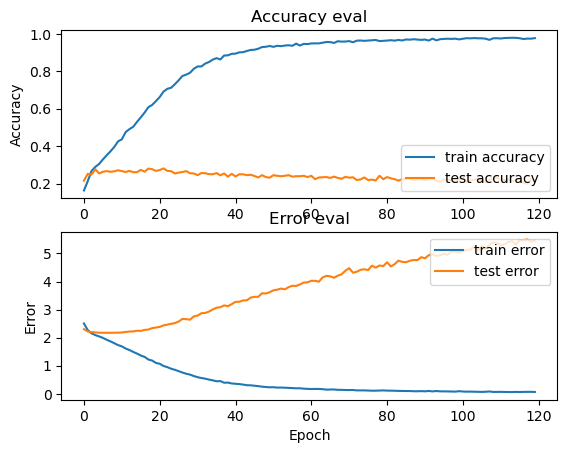

In [38]:
# plot accuracy/error for training and validation
plot_history(history)

In [39]:
# evaluate model on test set
test_loss, test_acc,test_mse = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc )

# pick a sample to predict from the test set
X_to_predict = X_test[100]
y_to_predict = y_test[100]

# predict sample
predict(model, X_to_predict, y_to_predict)

1470/1470 - 2s - loss: 5.1554 - acc: 0.2401 - mean_squared_error: 57.5597

Test accuracy: 0.24013606
Target: 5, Predicted label: [5]


*1)3 conv layers*<br>
*2)1 dense layer*<br>
*3)0.3droupout*<br>
*4)epochs=30*<br>
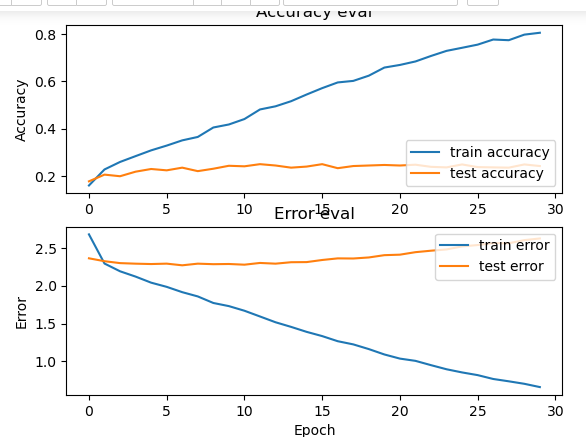

*1)3 conv layers*<br>
*2)2 dense layer*<br>
*3)0.18 droupout*<br>
*4)0.12 droupout*<br>
*5)epochs= 120*<br>
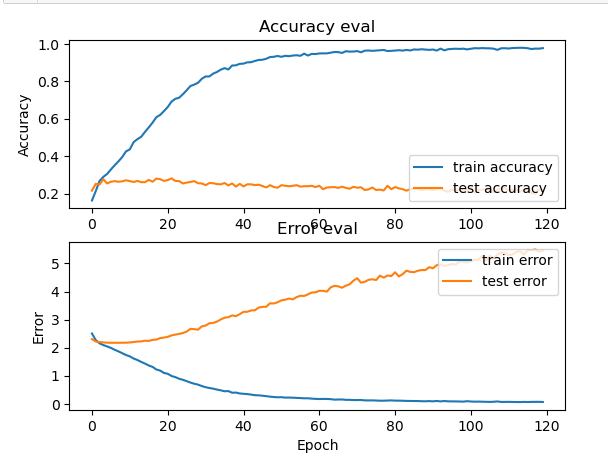

In [ ]:

# load data
X, y = load_data(DATA_PATH)

# create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# build network topology
model = keras.Sequential([

# input layer
keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

# 1st dense layer
keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
keras.layers.Dropout(0.3),

# 2nd dense layer
keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
keras.layers.Dropout(0.3),

# 3rd dense layer
keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
keras.layers.Dropout(0.3),

# output layer
keras.layers.Dense(10, activation='softmax')])
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()

# train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=100)

# plot accuracy and error as a function of the epochs
plot_history(history)